# Gene Regulatory Analysis with CellOracle

### Author: Alvaro Regano (alvaro.regano@gmail.com)

# Overview 

This notebook describes how to construct GRN models in CellOracle (Kamimoto, K., Stringa, B., Hoffmann, C. M., Jindal, K., Solnica-Krezel, L., & Morris, S. A.(2023). Dissecting cell identity via network inference and in silico gene perturbation.Nature, 614(7949), 742-751. https://doi.org/10.1038/s41586-022-05688-9). It has been adapted to the project of endothelial to hematopoietic transition with E10.5 mouse embryos.

Notebok based on this Notebook produced by Kamimoto K.:

https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb

### Data
CellOracle uses two types of input data during the GRN model construction.

- **Input data 1: scRNA-seq data**. Please look at the previous section to learn about the scRNA-seq data preprocessing. https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html.

In this project I used an h5ad anndata object of E10.5 aorta gonad mesonephros (AGM) endothelial cells (ECs)


- **Input data 2: Base-GRN**. The base GRN represents the TF-target gene connections. The data structure is a binary 2D matrix or linklist. For this project I used an already publicaly available scATAC dataset of AGM ECs (GSE137115 accession number from Zhu et al. (2020)).

### Analysis performed

 For this project I looked into the differences in GRN between conditions by performing **Network Analysis** while looking at the cell populations withing the AGM. 
 
 Furthermore I performed **in silico TF perturbation analysis**, where CellOracle uses the GRN models to simulate cell identity shifts in response to TF perturbation. This analysis is carried on in the following Notebook: KO_Perturbations.Hey1_KO_simulation_with_scAGM_EHT.ipynb
 
### Custom data classes / objects

In this notebook, CellOracle uses two custom classes, `Oracle` and `Links`.

- `Oracle` is the main class in the CellOracle package. It is responsible for almost all the GRN model construction and TF perturbation simulation. `Oracle` does the following calculations sequentially.
 1. Import scRNA-sequence data. Please refer to the data preparation notebooks to learn about data preparation procedures.
 2. Import base GRN data.
 3. scRNA-seq data processing. 
 4. GRN model construction.
 5. in silico petrurbation. We will describe how to do this in the following notebook.

- `Links` is a class to store GRN data. It also conteins many functions for network analysis and visualization.


# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [72]:
import celloracle as co
co.__version__

'0.18.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Notebooks/CellOracle'

## 0.2. Make a folder to save graph

In [5]:
save_folder = "../../Plots/Paper/CellOracle/New"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

The scRNA-seq data must be in the anndata format.



In [6]:

adata = sc.read_h5ad("../../anndata/scAGM_v4_Palantir_Final_Bmx_from_Aorta_ECs_upgrade.h5ad")

adata

AnnData object with n_obs × n_vars = 1387 × 18310
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HAL

## Rename clusters and conditions to facilitate analysis

In [6]:


adata.obs['FinalClustering'] = adata.obs['FinalClustering'].replace({'Conflux endo [AE]': 'Aorta Endothelium', 'Pre-HE [AE]': 'Pre-HE'})

adata.obs['FinalClustering'].unique()

['HE', 'Pre-HE', 'IAC', 'Aorta Endothelium']
Categories (4, object): ['Aorta Endothelium', 'HE', 'IAC', 'Pre-HE']

In [7]:
adata.obs['Condition_v2'] = adata.obs['Condition'].replace({'Control VEQ': 'Control'})

adata.obs['Condition_v2'].unique()

['Nmyc LOF', 'Mfng GOF', 'Control', 'Notch1 GOF', 'Jagged1LOF VEQ', 'NotchLOF VEQ']
Categories (6, object): ['Control', 'Jagged1LOF VEQ', 'Mfng GOF', 'Nmyc LOF', 'Notch1 GOF', 'NotchLOF VEQ']

In [124]:

cell_id = 'TTTACCACAGTGTGGA-1_2'

adata.obs["Condition"].loc[cell_id]


'Control VEQ'

loop to rename the Condition_Clustering category

this renaming is to facilitate comparison among analysis, keeping the same nomenclature

In [9]:

cond_clust = [''] *len(adata.obs_names)

for i, cell_id in  enumerate(adata.obs_names):
    a = adata.obs["Condition_v2"].loc[cell_id]
    b = adata.obs["FinalClustering"].loc[cell_id]
    cond_clust[i] = ''.join([a, "_", b])

adata.obs['Condition_Clustering_v2'] = cond_clust

adata.obs['Condition_Clustering_v2'].unique()

array(['Nmyc LOF_Aorta Endothelium', 'Mfng GOF_HE', 'Control_Pre-HE',
       'Control_IAC', 'Notch1 GOF_IAC', 'Control_Aorta Endothelium',
       'Control_HE', 'Notch1 GOF_Aorta Endothelium', 'Nmyc LOF_IAC',
       'Notch1 GOF_Pre-HE', 'Mfng GOF_IAC', 'Mfng GOF_Aorta Endothelium',
       'Notch1 GOF_HE', 'Mfng GOF_Pre-HE', 'Nmyc LOF_HE',
       'Nmyc LOF_Pre-HE', 'Jagged1LOF VEQ_HE', 'Jagged1LOF VEQ_Pre-HE',
       'NotchLOF VEQ_HE', 'Jagged1LOF VEQ_IAC', 'NotchLOF VEQ_IAC',
       'NotchLOF VEQ_Aorta Endothelium', 'NotchLOF VEQ_Pre-HE',
       'Jagged1LOF VEQ_Aorta Endothelium'], dtype=object)

In [10]:
adata.obs['Condition_Clustering_v2'].value_counts().sort_index()

Control_Aorta Endothelium            92
Control_HE                          104
Control_IAC                         315
Control_Pre-HE                      157
Jagged1LOF VEQ_Aorta Endothelium     42
Jagged1LOF VEQ_HE                    36
Jagged1LOF VEQ_IAC                   86
Jagged1LOF VEQ_Pre-HE                69
Mfng GOF_Aorta Endothelium           20
Mfng GOF_HE                          33
Mfng GOF_IAC                        128
Mfng GOF_Pre-HE                      40
Nmyc LOF_Aorta Endothelium           19
Nmyc LOF_HE                          15
Nmyc LOF_IAC                         73
Nmyc LOF_Pre-HE                      12
Notch1 GOF_Aorta Endothelium         60
Notch1 GOF_HE                        44
Notch1 GOF_IAC                      194
Notch1 GOF_Pre-HE                    29
NotchLOF VEQ_Aorta Endothelium       70
NotchLOF VEQ_HE                      48
NotchLOF VEQ_IAC                     74
NotchLOF VEQ_Pre-HE                  51
Name: Condition_Clustering_v2, dtype: in

## 1.2. Anndata info

In [8]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")


hvg = adata.var['highly_variable']

true_entries = hvg[hvg]

print(f"HVG number is :{true_entries.shape[0]}")

Cell number is :1387
Gene number is :18310
HVG number is :2000


## Setting up the Genes of Interest and Highly Variable genes for CellOracle

Since CellOracle recommends only using it with the high variable genes from the dataset, we will have to reduce the object to a matrix with only those genes. However, in addition we will add the genes that are relevant to the story, them being: 

"Notch1", "Notch2", "Notch3", "Notch4", "Dll1", "Dll4", "Jag1", "Jag2", "Hes1", "Hey1", "Hey2", "Gata2", "Gja5","Mecom", "Mllt3", "Procr", "Cd44", "Gfi1", "Kit", "Runx1", "Mycn", "Myc", "Cdh5", "Mfng", "Sox17", "Ikzf2", "Rac2", "Myb", "Mpo"


In [11]:
hvg_names = true_entries.index

# 29 genes of interest
goi = ["Notch1", "Notch2", "Notch3", "Notch4", "Dll1", "Dll4", "Jag1", "Jag2", "Hes1", "Hey1", "Hey2", "Gata2", "Gja5","Mecom", "Mllt3", "Procr", "Cd44", "Gfi1", "Kit", "Runx1", "Mycn", "Myc", "Cdh5", "Mfng", "Sox17", "Ikzf2", "Rac2", "Myb", "Mpo"]

hvg_names = hvg_names.tolist()

genes_celloracle = hvg_names + goi

genes_celloracle_set = set(genes_celloracle)

genes_celloracle = list(genes_celloracle_set)

# Only 13 are not among the HVG

print("Total HVGs:", len(genes_celloracle))

Total HVGs: 2007


Now that we have the gene list we will create the sparse matrix of only those genes

In [13]:
# Subset the adata object based on the set of genes
adata_celloracle = adata[:, adata.var_names.isin(genes_celloracle)]

adata_celloracle


View of AnnData object with n_obs × n_vars = 1387 × 2007
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING

## 1.2 Load Custom made GRN from Nancy Speck

For this project I used a publicly available scATAC dataset that presented similar celltypes as the ones we processed in this work.
(GSE137115 accession number from Zhu et al. (2020))



In [15]:
# Zhu et al

file_path =  "../../celloracle/ATAC_Zhu/"

EHT_GRN = pd.read_parquet("".join([file_path, 
    "Zhu_et_al_ATAC_GRN_dataframe.parquet" # filtered with a 10 threshold
    ]))

base_GRN = EHT_GRN

EHT_GRN.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100015425_100016651            Kitl            0.0         0.0   
1  chr10_100486568_100487889           Tmtc3            0.0         0.0   
2  chr10_100588506_100589498   4930430F08Rik            0.0         0.0   
3  chr10_100741132_100741585         Gm35722            0.0         0.0   
4  chr10_100741989_100742521         Gm35722            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     1.0   0.0     0.0   
2         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      1.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

In [16]:
target_Gata2 = base_GRN[base_GRN['Myc'] > 0]['gene_short_name']

# target_Runx1.to_csv("target_Runx1.txt", index=False, header=False)

target_Gata2

0                 Kitl
1                Tmtc3
2        4930430F08Rik
4              Gm35722
6               Rassf9
             ...      
18049           Tmem28
18051              Eda
18052          Eif2s3y
18053              Uty
18055            Kdm5d
Name: gene_short_name, Length: 12969, dtype: object

In [17]:
Gata2_targets = base_GRN[base_GRN['gene_short_name'] == "Myc"]

Gata2_targets_merge = Gata2_targets.iloc[:, 2:]

Gata2_targets_merge_sum = Gata2_targets_merge.sum(axis=0)

Gata2_targets_merge_sum_pos = Gata2_targets_merge_sum[Gata2_targets_merge_sum > 0]

# Gata2_targets_merge_sum_pos.to_csv("Gata2_targets_EHT_GRN.txt", index=True, header=True)

# print(Gata2_targets_merge_sum_pos)

Gata2_targets

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
4595  chr15_61984270_61985901             Myc            0.0         0.0   

      Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
4595         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

      Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
4595    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[1 rows x 1096 columns]

Further data exploration

In [47]:
# base_GRN[base_GRN.columns[base_GRN.columns.str.contains('Runx1')]]

target_Runx1 = base_GRN[base_GRN['Runx1'] > 0]['gene_short_name']

target_Runx1.to_csv("target_Runx1.txt", index=False, header=False)

target_Runx1

9                 Alx1
19                Grm1
43               Acss3
52                Myf6
73       4930432B10Rik
             ...      
91856          Arhgef9
91858          Arhgef9
91920              Otc
91939             Gjb1
91974            Ddx3y
Name: gene_short_name, Length: 6199, dtype: object

# 2. Make Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [19]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

For the CellOracle analysis, the anndata previously included (1) gene expression counts, (2) clustering information, (3) trajectory (dimensional reduction embedding) data andd (4) pseudotime trajectory data.

 - The clustering data should be to be stored in the `obs` the attribute of anndata. 
  > You can check it using the following command.
  >
  > `adata.obs.columns`
  
 - Dimensional reduction data is stored in the `obsm` the attribute of anndata. 
  > You can check it with the following command.
  > 
  > `adata.obsm.keys()`
  


In [21]:

# norm_counts = adata_celloracle.layers["normalized_counts"]

norm_counts = adata_celloracle.X

# norm_counts = adata.X

norm_counts_array = norm_counts.toarray()
norm_counts_df = pd.DataFrame(norm_counts_array, columns=[f'Col_{i}' for i in range(norm_counts_array.shape[1])])


The anndata object was imported with the normalized counts so as to mainain coherenc among analysis

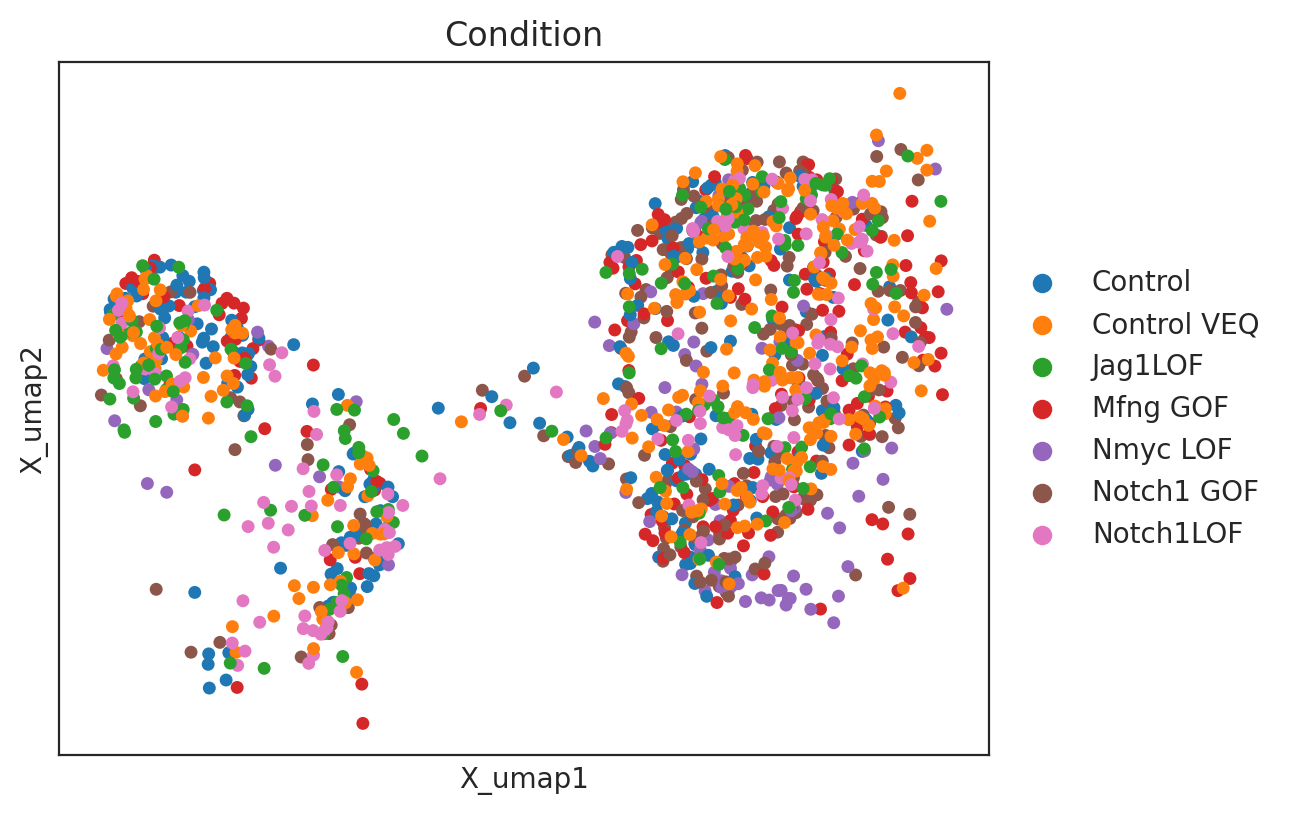

Mycn    0.0
dtype: float64

In [22]:
# In this notebook, we use a previous normalized mRNA count for the nput of Oracle object.
# adata.X = adata.layers["raw_count"].copy()

adata_celloracle.layers["raw_count"] = adata_celloracle.X

adata_celloracle.layers["normalized_count"] = adata_celloracle.X

# Instantiate Oracle object.

oracle.import_anndata_as_normalized_count(adata=adata_celloracle,
                                   cluster_column_name="Condition",
                                   embedding_name="X_umap")

adata_celloracle[adata_celloracle.obs["Condition"][adata_celloracle.obs["Condition"] == "Nmyc LOF"].index, "Mycn"].to_df().sum()

## 2.2. Load base-GRN data into oracle object

In [23]:
base_GRN.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100015425_100016651            Kitl            0.0         0.0   
1  chr10_100486568_100487889           Tmtc3            0.0         0.0   
2  chr10_100588506_100589498   4930430F08Rik            0.0         0.0   
3  chr10_100741132_100741585         Gm35722            0.0         0.0   
4  chr10_100741989_100742521         Gm35722            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     1.0   0.0     0.0   
2         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      1.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

In [24]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

In [139]:
os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Notebooks/CellOracle'

# 3. KNN imputation
CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

For KO perturbation the dataset was KNN imputated. However for looking at GRN differences among conditions **no imputation was performed**, as the imputation affects each condition averaging the gene expression values, and therefore altering the differences among them

## 3.1. PCA

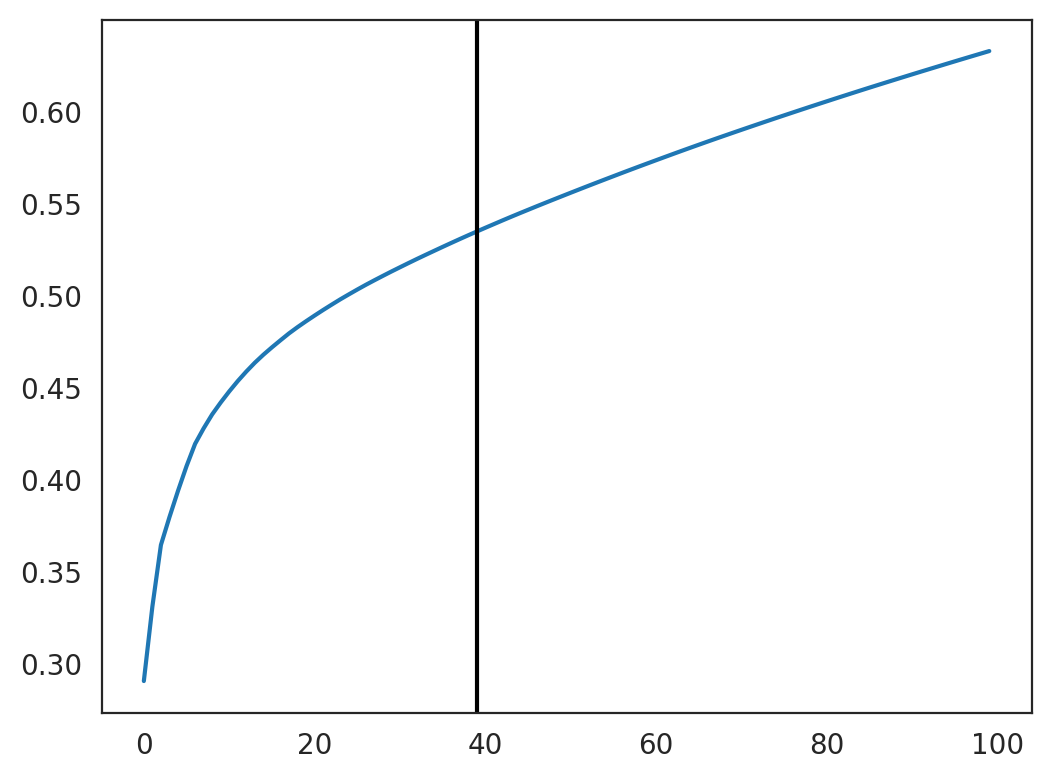

39


In [25]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [26]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :1387


In [27]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :34


In [33]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [34]:
# Traspass dataframe onto counts matrix

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Convert DataFrame to CSR sparse matrix of type numpy.float64
sparse_matrix = csr_matrix(layer_imputed.values, dtype=np.float64)

oracle.adata.layers["imputed_count"] = sparse_matrix


## Dispense from KNN imputed counts in oracle object

In [32]:
# Traspass dataframe onto counts matrix

oracle.adata.layers["imputed_count"] = oracle.adata.layers["normalized_count"]

# 4. Save and Load.




In [192]:
# Save the file locally

# save_dir = "/home/aregano/PhD/"

save_dir = "/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/celloracle/"

# Save oracle object.
oracle.to_hdf5(save_dir + "scAGM_EHT_byCondition.celloracle.oracle")

In [36]:
# save_dir = "../../celloracle/"

save_dir = "/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/celloracle/"

# Load file.

# baseGRN
# oracle = co.load_hdf5(save_dir + "scAGM_EHT_byCondition_baseGRN.celloracle.oracle")

# EHT GRN

oracle = co.load_hdf5(save_dir + 
    "scAGM_EHT_Zhu_wo_imputation_byCondition_from_Aorta_ECs.celloracle.oracle"
    )

In [35]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 1387
    n_genes: 2007
    cluster_name: Condition
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 16077 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 142 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1583 genes
    k_for_knn_imputation: 34
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [37]:
# Check if Mycn is deleted in NMyc LOF condition

oracle.adata[oracle.adata.obs["Condition"][oracle.adata.obs["Condition"] == "Nmyc LOF"].index, "Mycn"].to_df().sum()

Mycn    0.0
dtype: float64

In [38]:
adata.obsm_keys()

['DM_EigenVectors',
 'DM_EigenVectors_multiscaled',
 'X_pca',
 'X_umap',
 'branch_masks',
 'dm_res',
 'palantir_fate_probabilities']

# 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

- You can calculate GRNs with the `get_links` function, and it will return the results as a `Links` object.
The `Links` object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the `Links` object.

- A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.



## 5.1. Get GRNs

In [8]:
import inspect

print(inspect.getsource(oracle.get_links))



    def get_links(self, cluster_name_for_GRN_unit=None, alpha=10, bagging_number=20, verbose_level=1, test_mode=False, model_method="bagging_ridge", ignore_warning=False, n_jobs=-1):
        """
        Makes GRN for each cluster and returns results as a Links object.
        Several preprocessing should be done before using this function.

        Args:
            cluster_name_for_GRN_unit (str): Cluster name for GRN calculation. The cluster information should be stored in Oracle.adata.obs.

            alpha (float or int): The strength of regularization.
                If you set a lower value, the sensitivity increases, and you can detect weaker network connections. However, there may be more noise.
                If you select a higher value, it will reduce the chance of overfitting.

            bagging_number (int): The number used in bagging calculation.


            verbose_level (int): if [verbose_level>1], most detailed progress information will be shown.
               

In [194]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="Condition", alpha=10,
                         verbose_level=10)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for Control...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Control VEQ...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Jag1LOF...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Mfng GOF...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Nmyc LOF...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Notch1 GOF...


  0%|          | 0/1514 [00:00<?, ?it/s]

Inferring GRN for Notch1LOF...


  0%|          | 0/1514 [00:00<?, ?it/s]

CPU times: user 5min, sys: 9.07 s, total: 5min 9s
Wall time: 6min 13s


## 5.2. (Optional) Export GRNs

Although CellOracle has many functions for network analysis, you can export and analyze GRNs using another software if you chose.
The raw GRN data is stored as a dictionary of dataframe in the `links_dict` attribute.

For example, you can get the GRN for the "Ery_0" cluster with the following commands.

In [43]:
links.links_dict.keys()

dict_keys(['Control', 'Control VEQ', 'Jag1LOF', 'Mfng GOF', 'Nmyc LOF', 'Notch1 GOF', 'Notch1LOF'])

In [44]:
links.links_dict["Control"]

source         target  coef_mean  coef_abs             p     -logp
0         Sp5  1700007K13Rik   0.000000  0.000000           NaN -0.000000
1        Hey1  1700007K13Rik   0.004048  0.004048  1.570716e-03  2.803902
2        Thrb  1700007K13Rik  -0.002345  0.002345  4.235766e-03  2.373068
3       Fosl2  1700007K13Rik  -0.004302  0.004302  6.668415e-06  5.175977
4       Foxq1  1700007K13Rik  -0.006482  0.006482  3.598910e-03  2.443829
...       ...            ...        ...       ...           ...       ...
53997    Klf6         Zswim6   0.037372  0.037372  5.502212e-03  2.259463
53998  Tcf7l2         Zswim6   0.098191  0.098191  1.256706e-08  7.900766
53999    Egr4         Zswim6   0.000000  0.000000           NaN -0.000000
54000   Klf12         Zswim6   0.105125  0.105125  1.761648e-10  9.754081
54001    Atf3         Zswim6   0.041445  0.041445  9.802388e-04  3.008668

[54002 rows x 6 columns]

You can export the file as follows.

In [39]:
# Set cluster name
cluster = "Ery_0"

# Save as csv
#links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")

## 5.3. (Optional) Change order

The links object stores color information in the `palette` attribute.
This information is used when visualizing the clusters.

The sample will be visualized in that order. 
Here we can change both the cluster colors and order.

In [42]:
# Show the contents of pallete
links.palette

palette
Control      #1F77B4
Control VEQ  #FF7F0E
Jag1LOF      #2CA02C
Mfng GOF     #D62728
Nmyc LOF     #9467BD
Notch1 GOF   #8C564B
Notch1LOF    #E377C2

In [107]:
# Change the order of pallete
# order = ['MEP_0', 'Mk_0', 'Ery_0', 
#          'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9',
#          'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1',
#          'Mo_0', 'Mo_1', 'Mo_2', 
#          'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3']
# links.palette = links.palette.loc[order]
# links.palette

In [197]:
# Save Links object.

# Save the file locally as it does not work with Tierra

# save_dir = "/home/aregano/PhD/"

links.to_hdf5(file_path= save_dir+"scAGM_EHT_byCondition.links.celloracle.links")

# 6. Network preprocessing

## 6.1. Filter network edges 

Using the base GRN, CellOracle constructs the GRN models as a lits of directed edges between a TF and its target genes.
We need to remove the weak edges or insignificant edges before doing network structure analysis.

We filter the network edges as follows.

1. Remove uncertain network edges based on the p-value.
 
2. Remove weak network edge. In this tutorial, we keep the top 2000 edges ranked by edge strength.


The raw network data is stored in the `links_dict` attribute, while the filtered network data is stored in the `filtered_links` attribute. 


In [158]:
import inspect


In [22]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [23]:
links.filtered_links["Control"]

source   target  coef_mean  coef_abs             p      -logp
40173     Id3    Ramp2   0.485872  0.485872  3.067120e-15  14.513269
35127    Nfib    Pcsk5   0.412031  0.412031  5.402965e-14  13.267368
29105  Prdm16    Mecom   0.407041  0.407041  1.238035e-15  14.907267
42609    Spi1     Sat1  -0.392762  0.392762  1.372516e-09   8.862482
46499    Sox6    Sparc   0.375500  0.375500  1.711010e-15  14.766747
...       ...      ...        ...       ...           ...        ...
12482   Sox18  Dennd5b   0.083095  0.083095  1.034271e-06   5.985366
53224   Fosl2    Zdbf2   0.083070  0.083070  1.181948e-06   5.927402
28616   Sox13   Map4k4   0.083065  0.083065  5.492597e-07   6.260222
52777   Tead1     Wwc2   0.083062  0.083062  8.950612e-07   6.048147
19473     Fos      Gem   0.083051  0.083051  7.718714e-06   5.112455

[2000 rows x 6 columns]

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.

>Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [45]:
plt.rcParams["figure.figsize"] = [9, 4.5]

In [121]:
# print(inspect.getsource(co.network_analysis.links_object.plot_degree_distributions))

# print(inspect.getsource(co.load_hdf5))


In [41]:
# You can load files with the following command.
dir = "../../celloracle/"

# Zhu et al GRN

# links = co.load_hdf5(dir + "scAGM_Zhu_EHT_byCondition.links.celloracle.links")

# Zhu et al GRN without imputation

links = co.load_hdf5(dir + "scAGM_EHT_Zhu_wo_imputation_byCondition_from_Aorta_ECs.links.celloracle.links")



In [46]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [11]:
os.getcwd()


'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Notebooks/CellOracle'

## Important:  
In order to save the plot files in pdf form, remember to change the settings dictionary to pdf instead on png in the

celloracle_env/lib/python3.8/site-packages/celloracle/network_analysis/network_analysis_utility.py, network_structure_analysis.py and gene_analysis.py

# Degree distribution among Conditions

In order to look at the stability of the analysis among conditions, we can look at how the degree distribution looks among conditions

Control


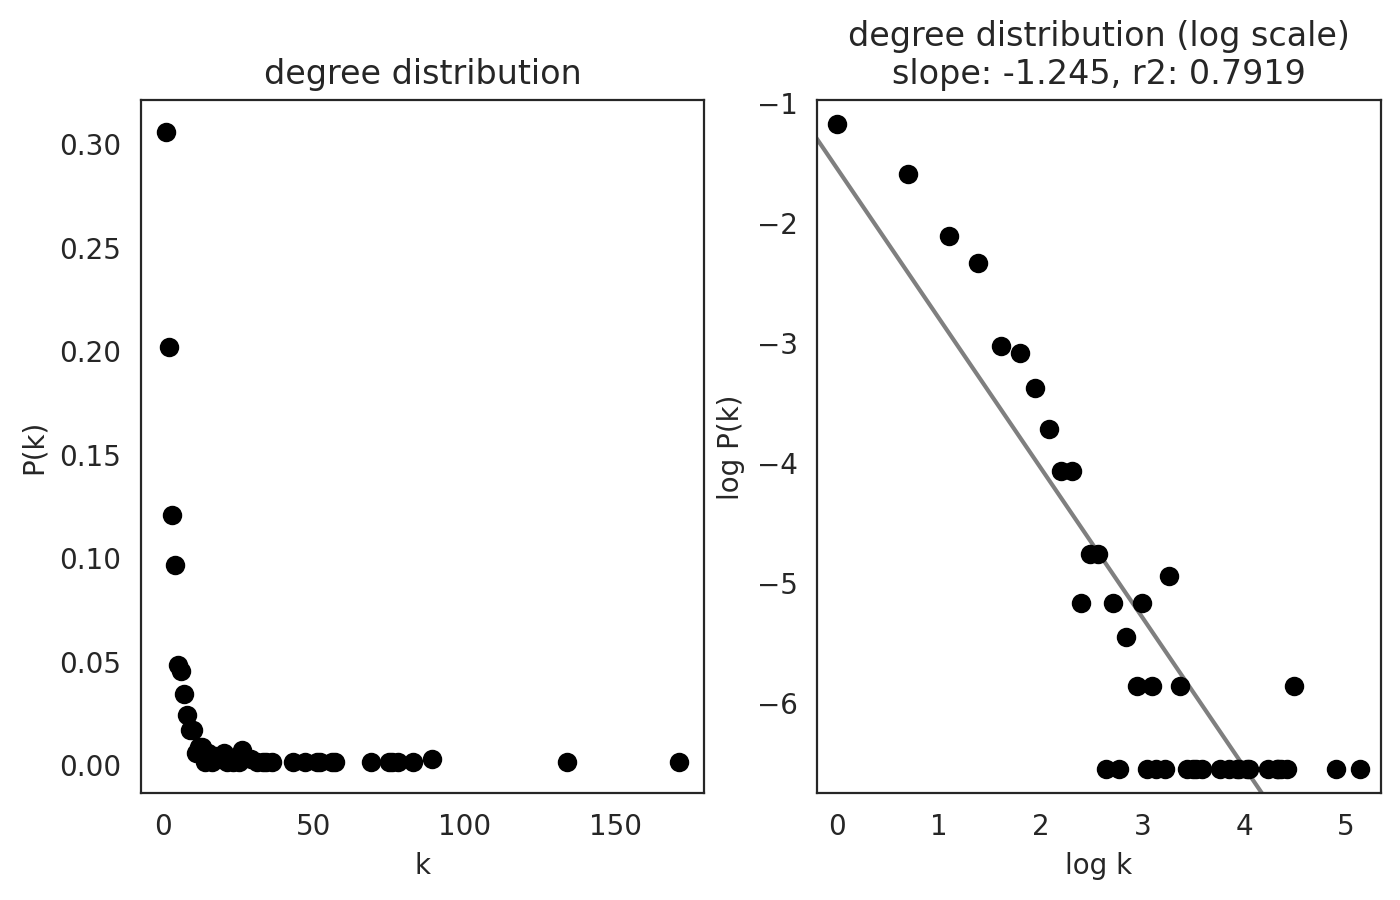

Control VEQ


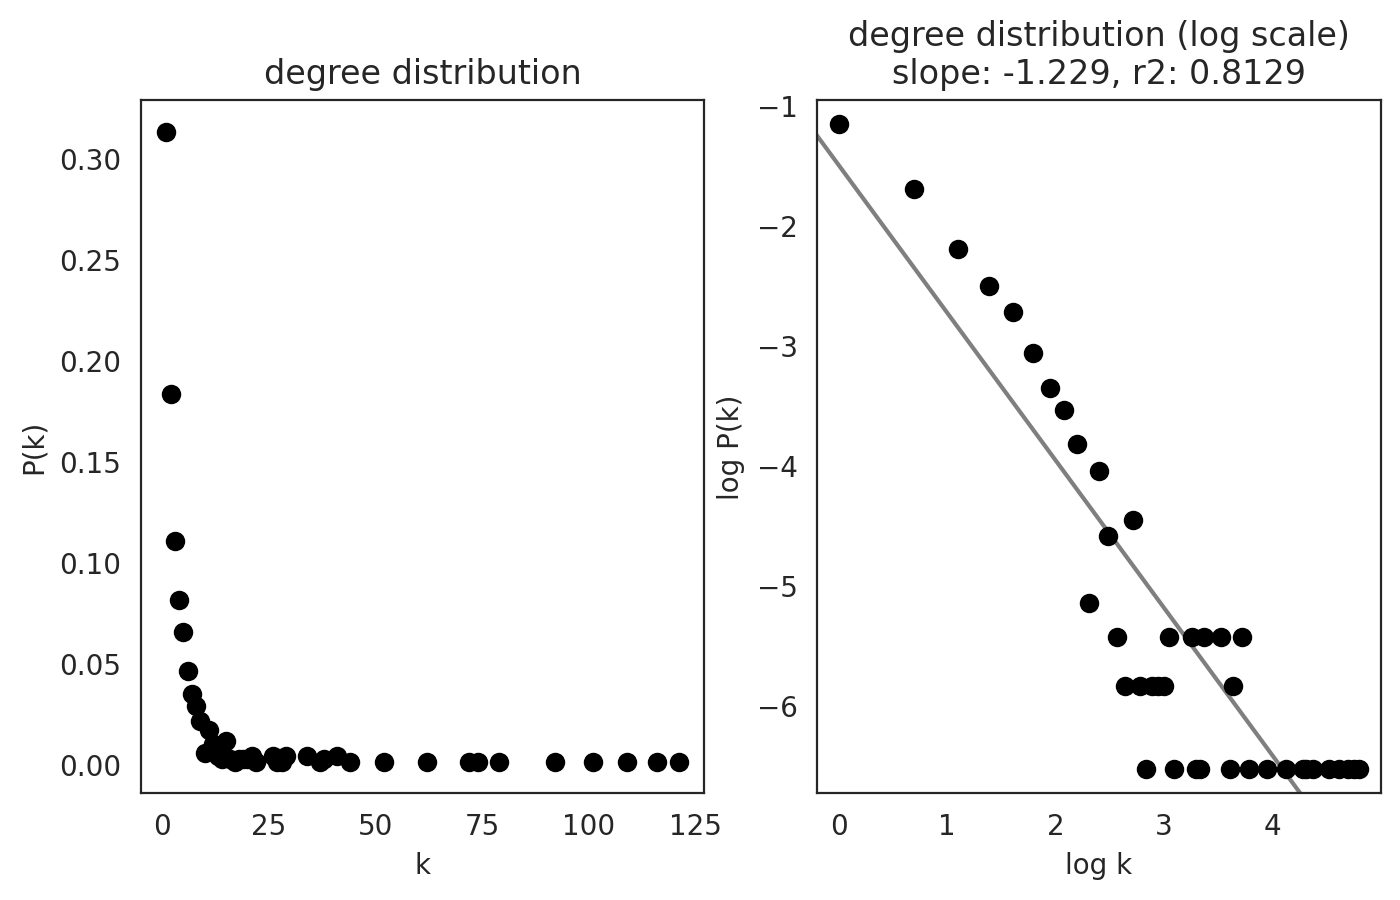

Jag1LOF


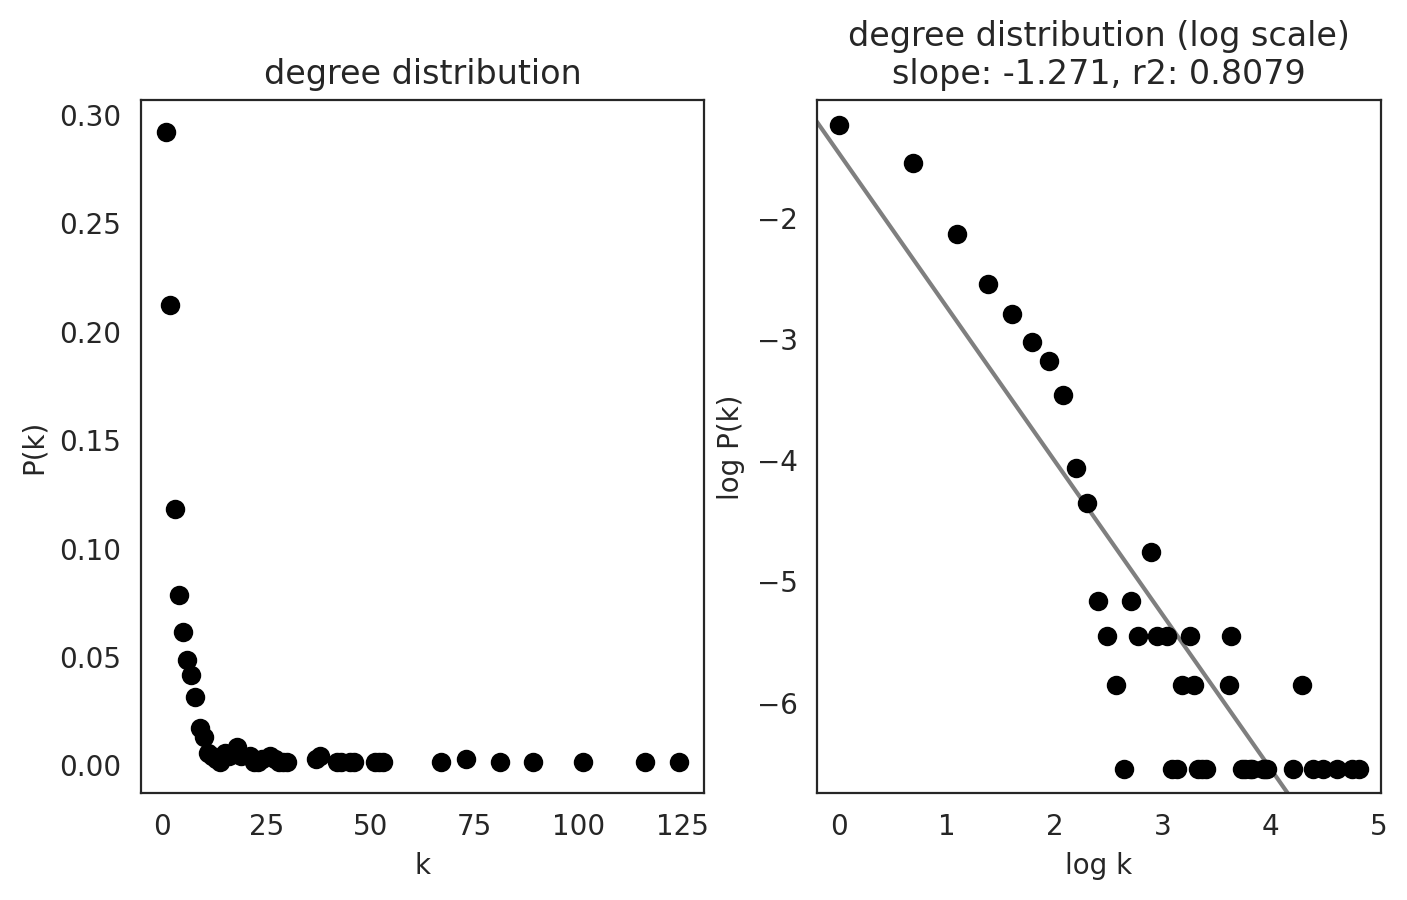

Mfng GOF


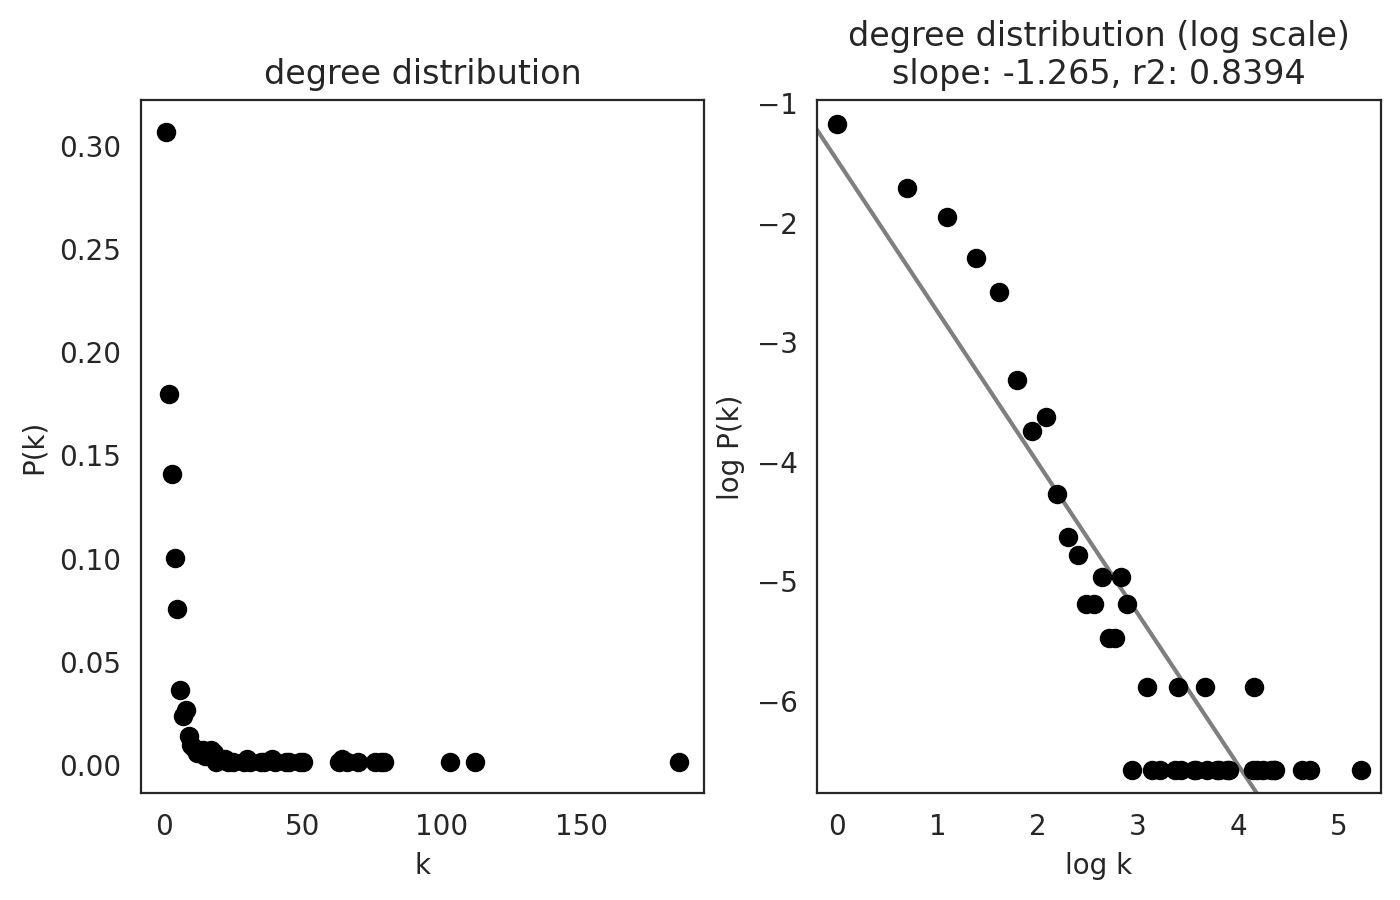

Nmyc LOF


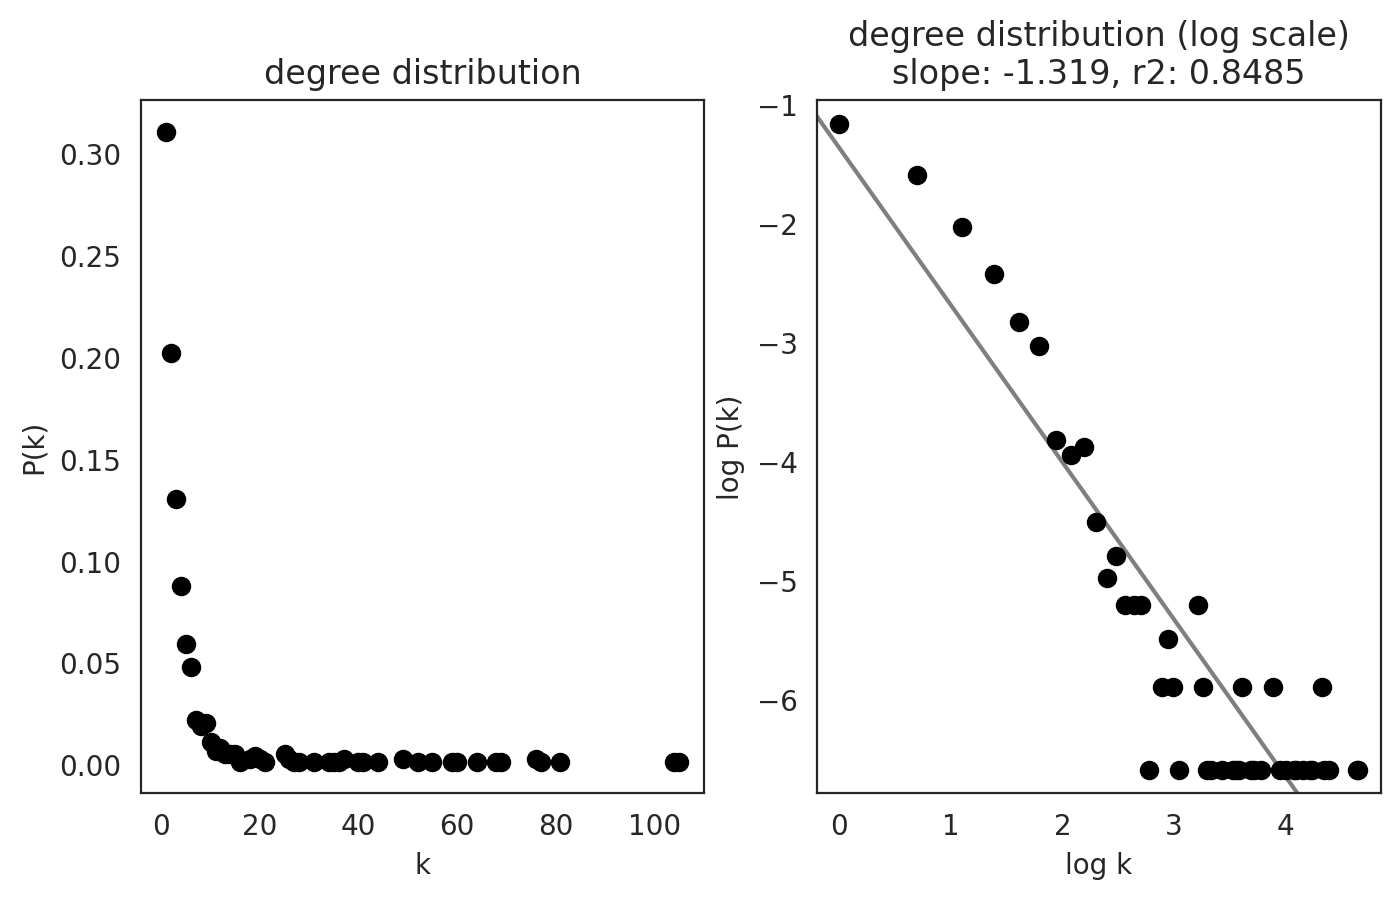

Notch1 GOF


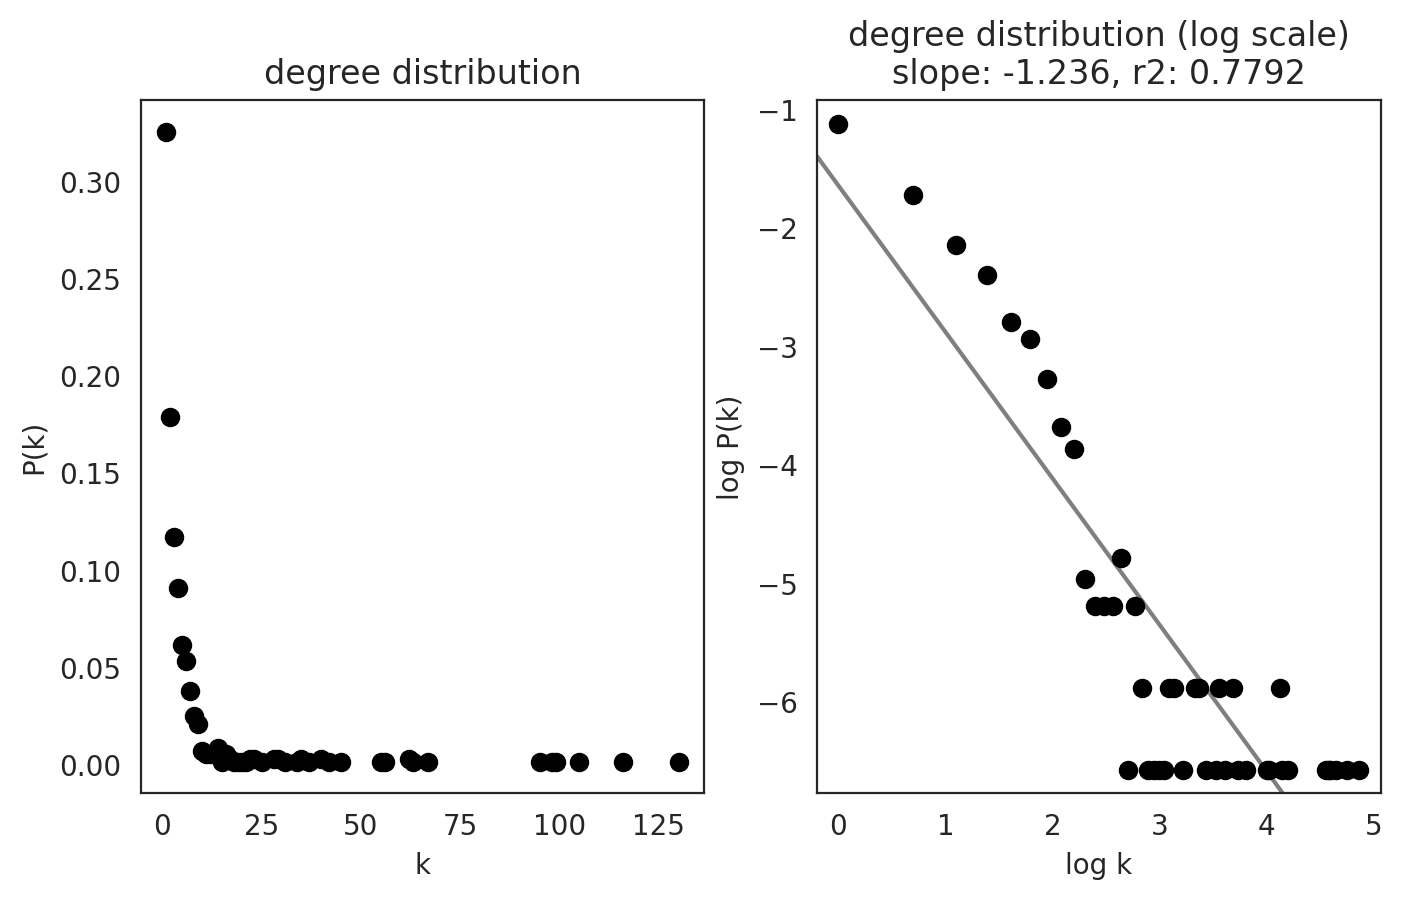

Notch1LOF


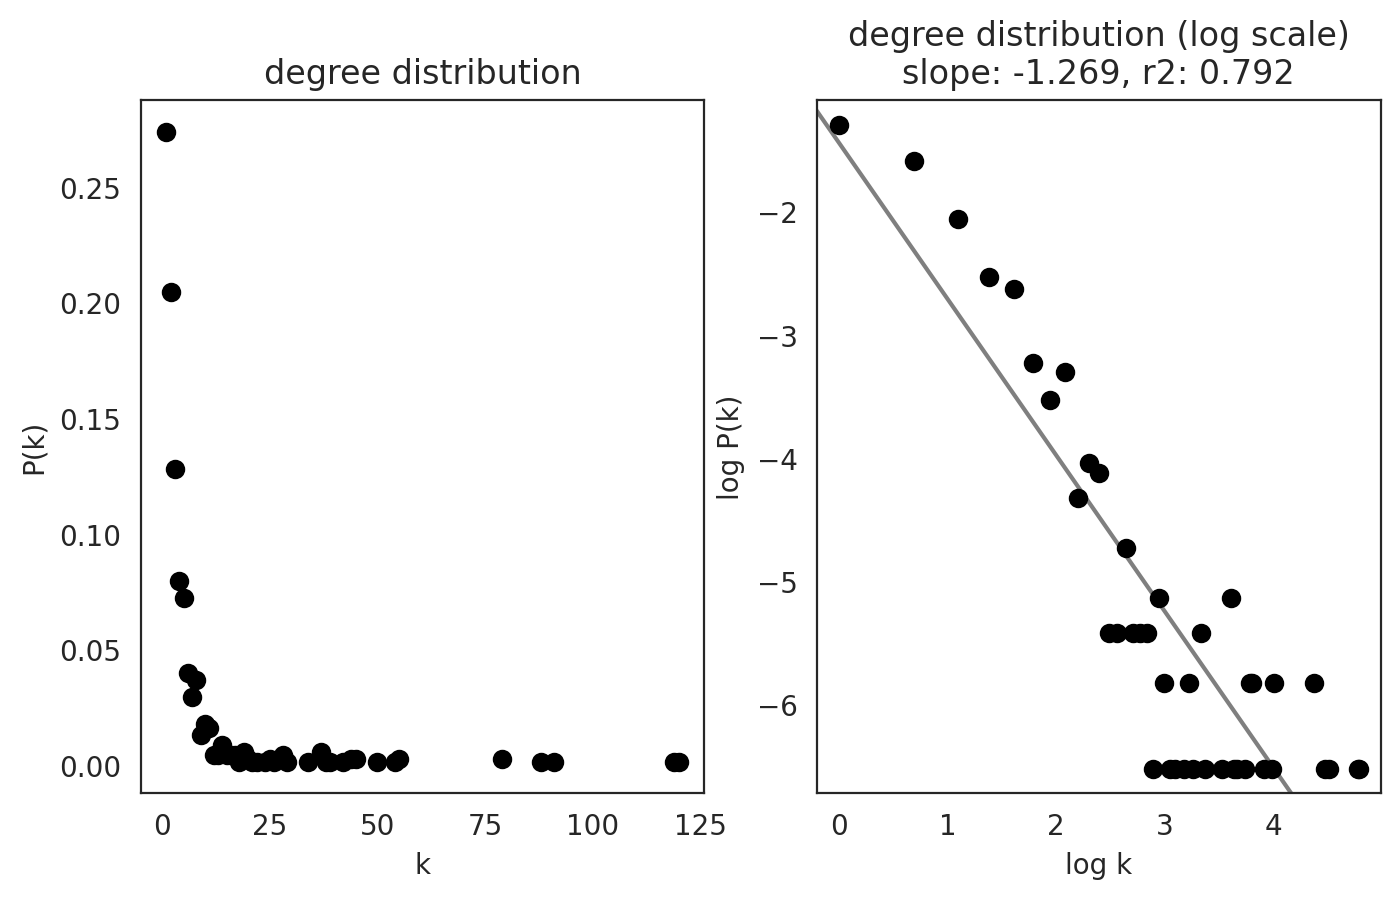

In [49]:
save_folder = "../../Plots/Paper/CellOracle/New/"

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams["savefig.dpi"] = 300
# plt.rcParams['axes.facecolor'] = 'white'


links.plot_degree_distributions(plot_model=True, 
                                            #    save=f"{save_folder}/degree_distribution/",
                                               )

They all look very similar, which indicates that networks are similar among conditions

In [48]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 6.3. Calculate network score

Next, we calculate several network scores.


In [51]:
# Calculate network scores. 
links.get_network_score()

The score is stored as a attribute `merged_score`.

In [52]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Id3             89               0.126781          8              0.011396   
Ramp2           10               0.014245         10              0.014245   
Nfib            47               0.066952          4              0.005698   
Pcsk5            7               0.009972          7              0.009972   
Prdm16          22               0.031339          2              0.002849   

        degree_out  degree_centrality_out  betweenness_centrality  \
Id3             81               0.115385                  4807.0   
Ramp2            0               0.000000                     0.0   
Nfib            43               0.061254                  1029.0   
Pcsk5            0               0.000000                     0.0   
Prdm16          20               0.028490                    32.0   

        eigenvector_centrality  cluster  
Id3                   0.645265  Control  
Ramp2                 0.277774  Control  
Nfib                  0.287646  Control  
Pcsk5                 0.121372  Control  
Prdm16                0.077391  Control

In [28]:
links.merged_score[links.merged_score.index == "Mycn"]

# links.merged_score.index == "Mycn"

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Mycn          15               0.021368          2              0.002849   
Mycn           8               0.011679          2              0.002920   
Mycn          14               0.019971          1              0.001427   
Mycn          17               0.023710          1              0.001395   
Mycn           6               0.008392          2              0.002797   
Mycn           3               0.004425          0              0.000000   

      degree_out  degree_centrality_out  betweenness_centrality  \
Mycn          13               0.018519                   283.0   
Mycn           6               0.008759                  1046.0   
Mycn          13               0.018545                    19.0   
Mycn          16               0.022315                    76.0   
Mycn           4               0.005594                   566.0   
Mycn           3               0.004425                     0.0   

      eigenvector_centrality      cluster  
Mycn                0.081701      Control  
Mycn                0.083124  Control VEQ  
Mycn                0.082638      Jag1LOF  
Mycn                0.044930     Mfng GOF  
Mycn                0.032328   Notch1 GOF  
Mycn                0.028997    Notch1LOF

In [36]:
links.merged_score[links.merged_score.index == "Hey1"]

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Hey1          84               0.119658          1              0.001425   
Hey1         121               0.176642          1              0.001460   
Hey1          89               0.126961          1              0.001427   
Hey1         104               0.145049          2              0.002789   
Hey1         105               0.144628          1              0.001377   
Hey1         131               0.183217          1              0.001399   
Hey1         120               0.176991          0              0.000000   

      degree_out  degree_centrality_out  betweenness_centrality  \
Hey1          83               0.118234                  1331.0   
Hey1         120               0.175182                  8689.0   
Hey1          88               0.125535                  1855.0   
Hey1         102               0.142259                  1236.0   
Hey1         104               0.143251                   262.0   
Hey1         130               0.181818                  1602.0   
Hey1         120               0.176991                     0.0   

      eigenvector_centrality      cluster  
Hey1                0.507338      Control  
Hey1                0.950024  Control VEQ  
Hey1                0.543038      Jag1LOF  
Hey1                0.519742     Mfng GOF  
Hey1                1.000000     Nmyc LOF  
Hey1                1.000000   Notch1 GOF  
Hey1                0.623805    Notch1LOF

## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

In [207]:
# Save Links object.
links.to_hdf5(file_path=save_dir+"links_scAGM_EHT.celloracle.links")

**If you are not interested in network analysis you can skip the steps described below. 
Please go to the next step: in silico gene perturbation with GRNs**

https://morris-lab.github.io/CellOracle.documentation/tutorials/simulation.html

# 7. Network analysis; Network score for each gene
The `Links` class has many functions to visualize network score.
See the web documentation to learn more about these functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
>Centrality matrics are is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [208]:
# Check cluster name
links.cluster

['Control',
 'Control VEQ',
 'Jag1LOF',
 'Mfng GOF',
 'Nmyc LOF',
 'Notch1 GOF',
 'Notch1LOF']

## Looking at the various Network analysis indicators per each condition

These indicators are degree centrality, betweennes and eigenvector centrality

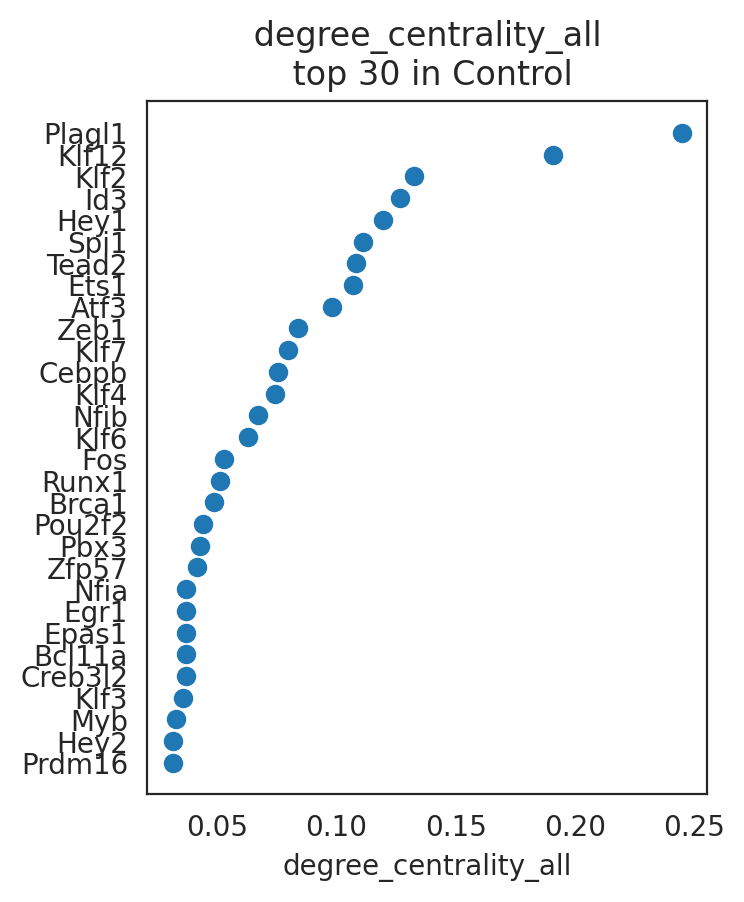

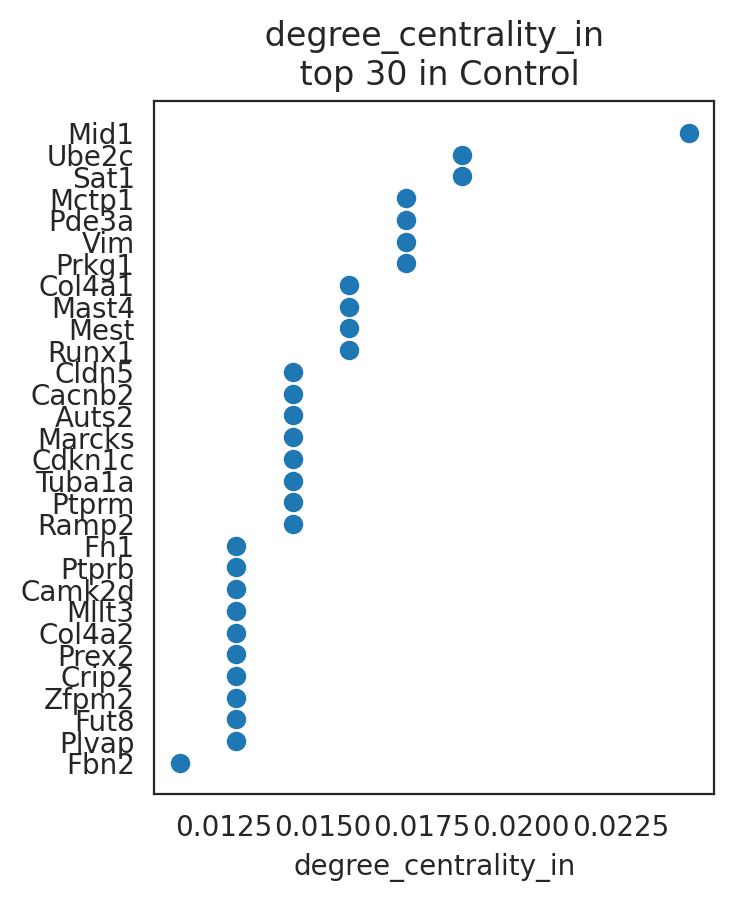

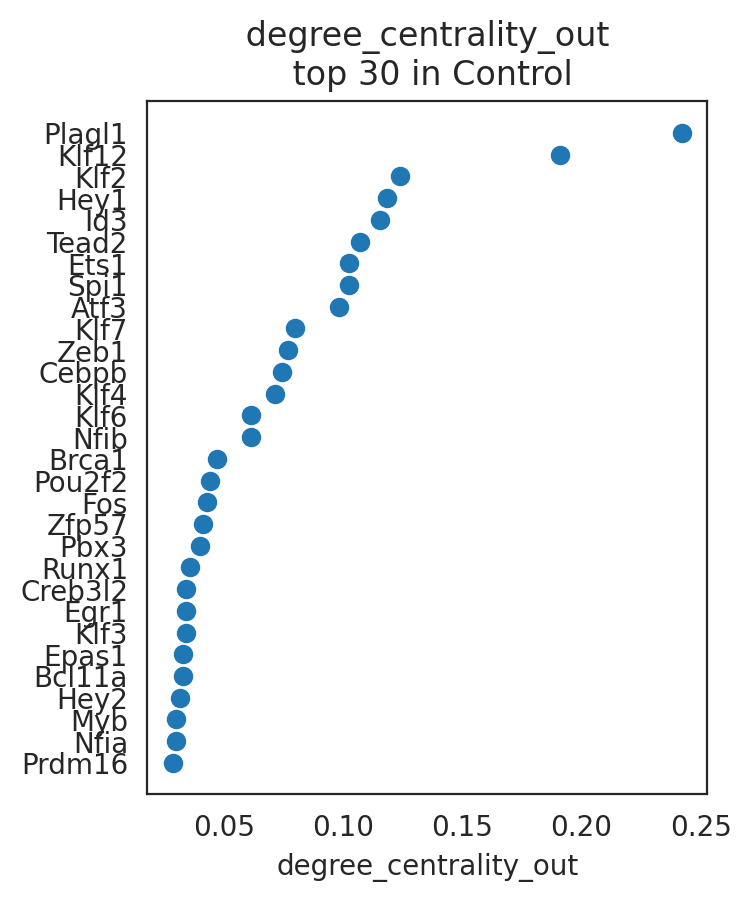

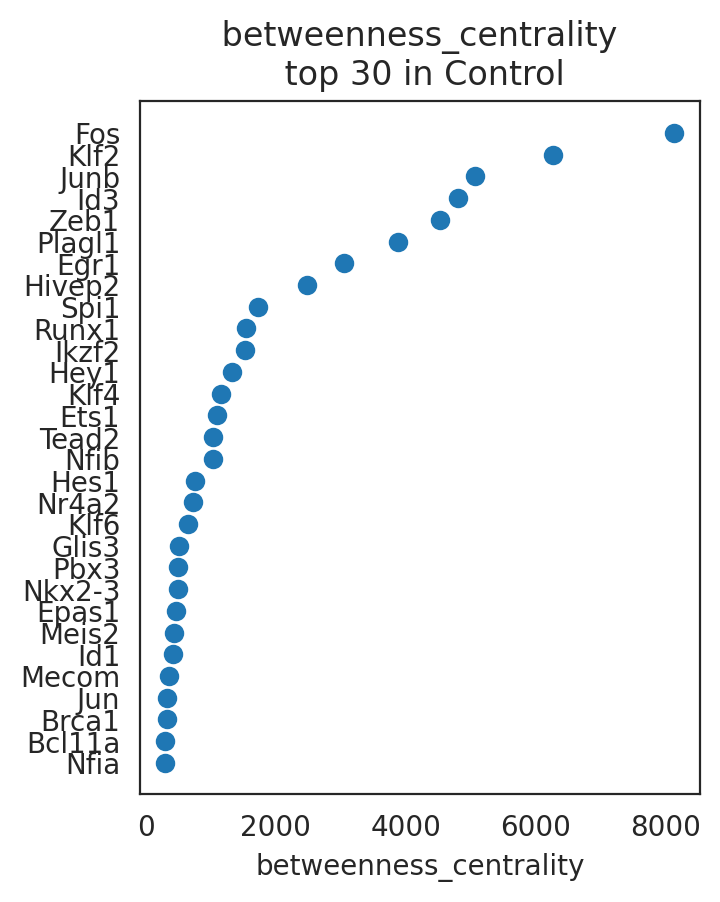

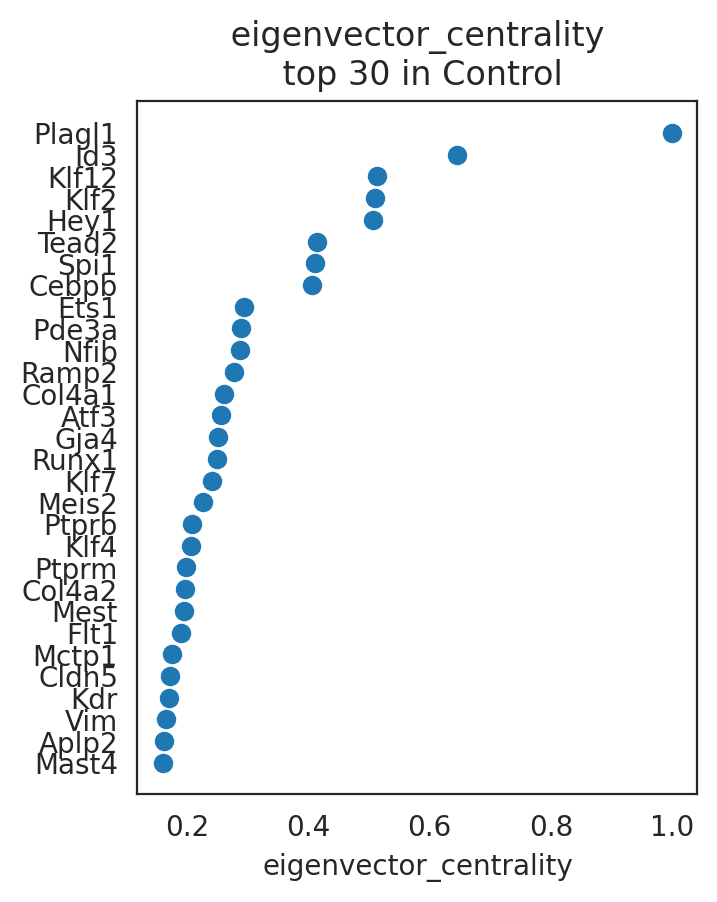

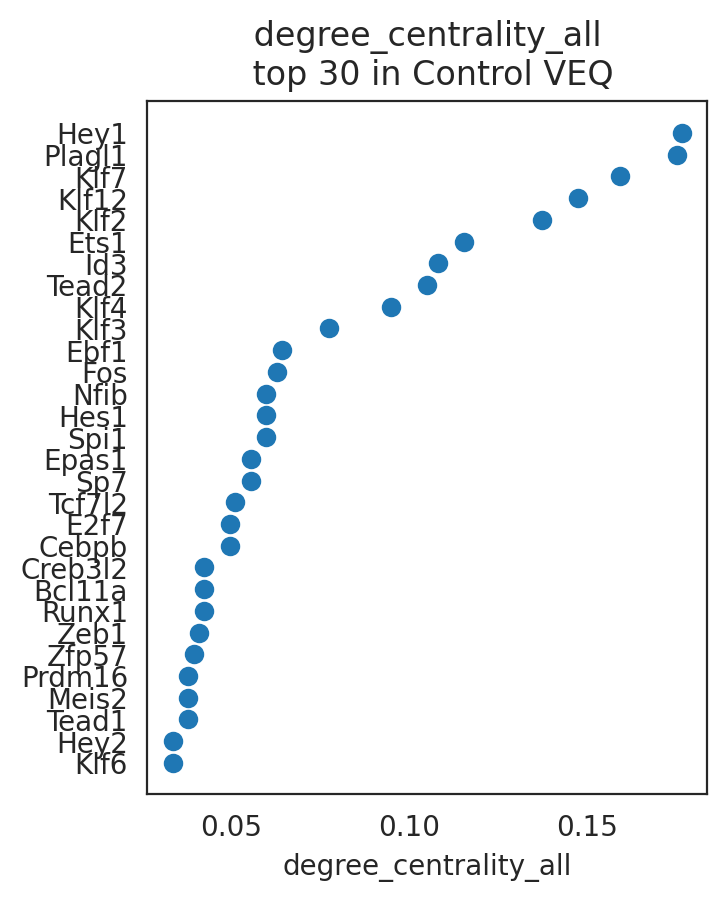

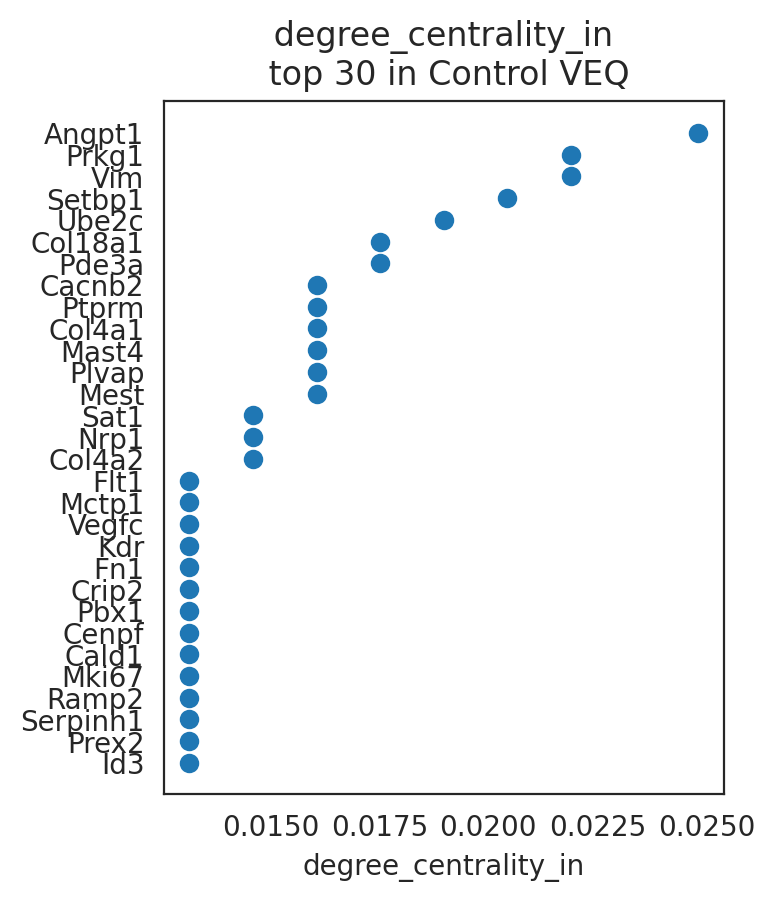

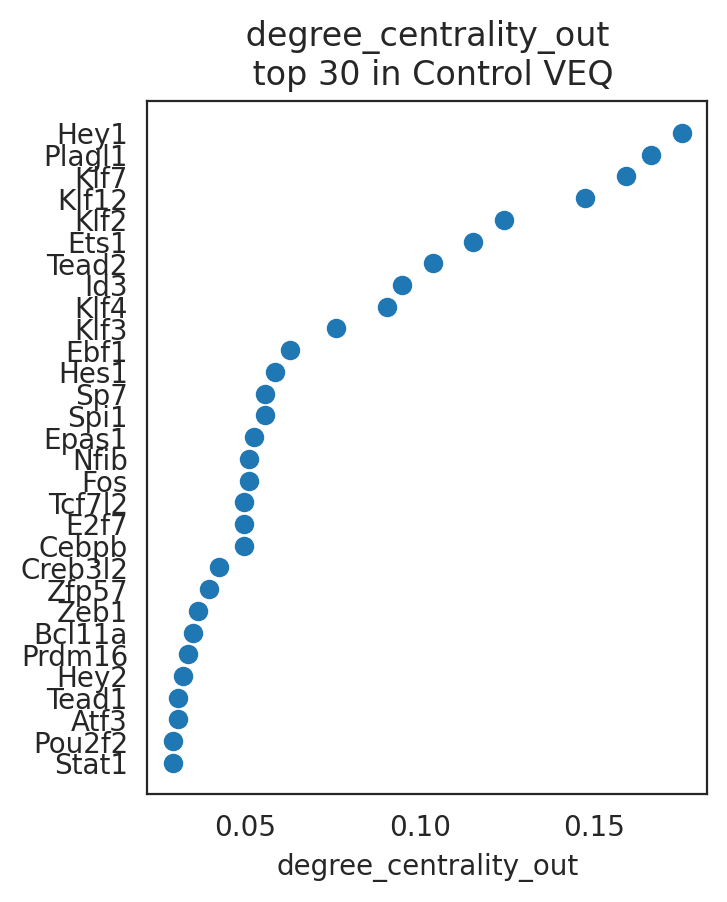

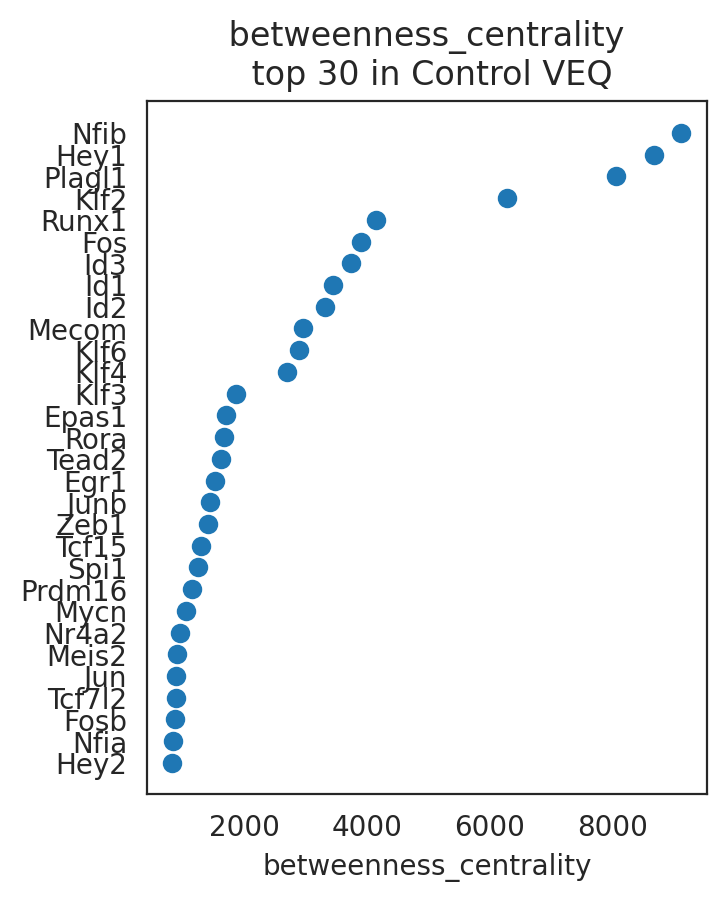

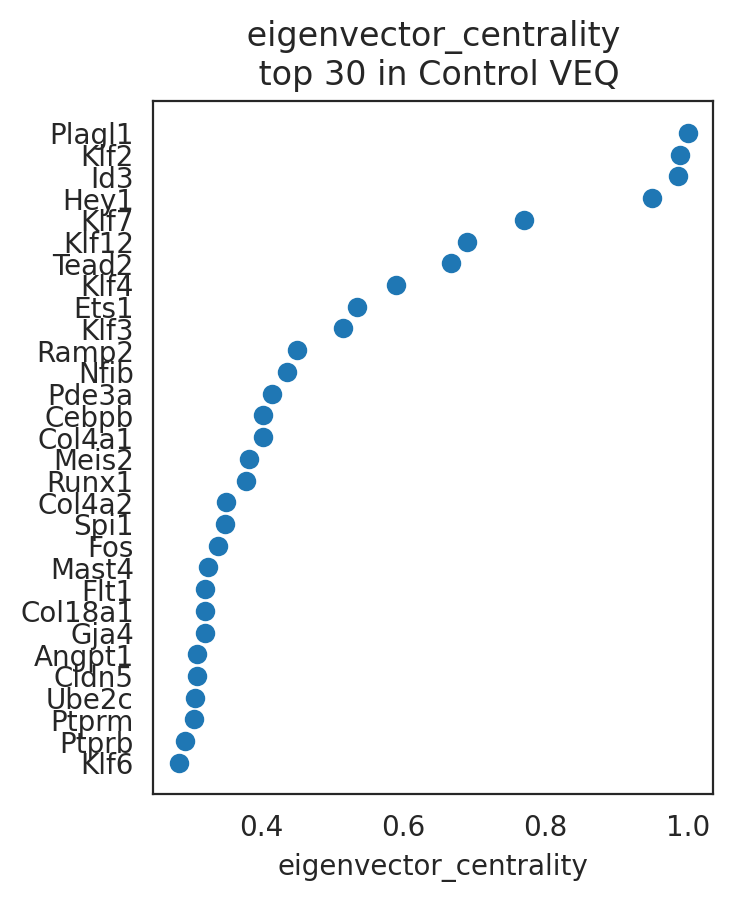

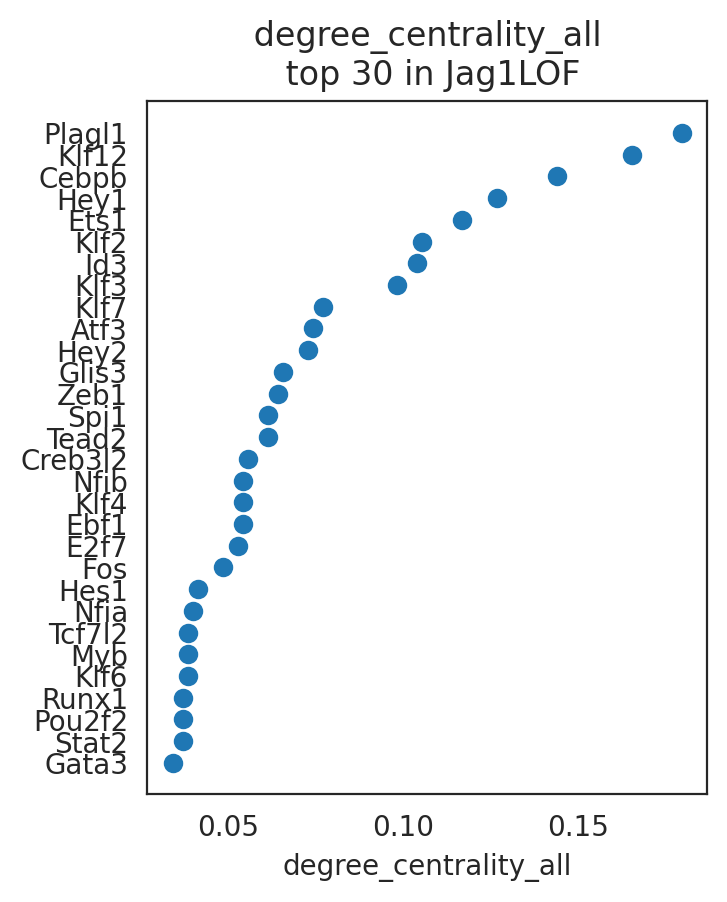

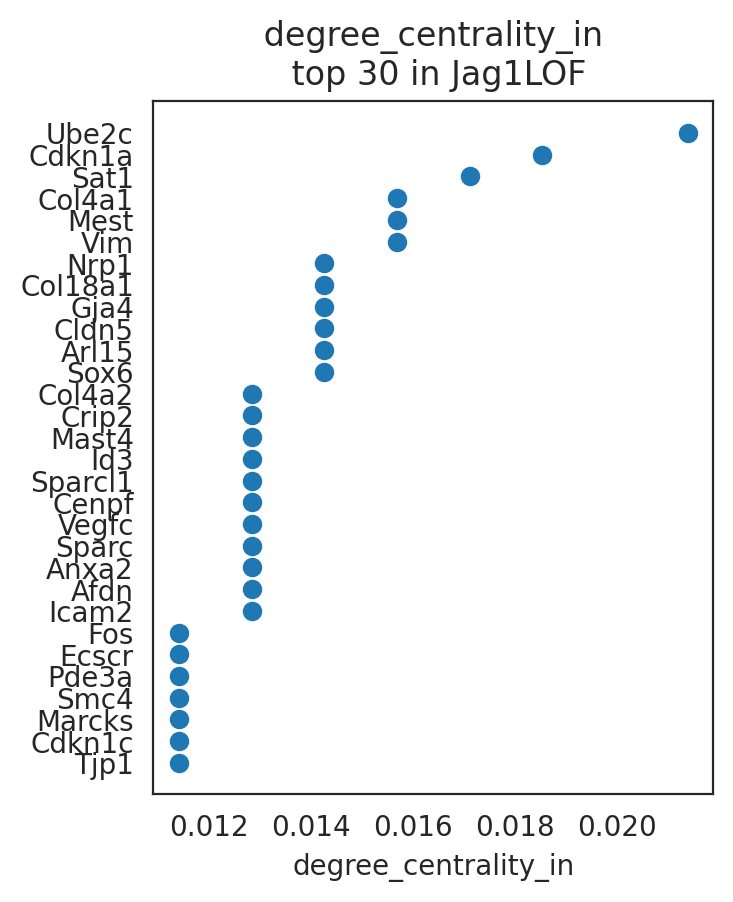

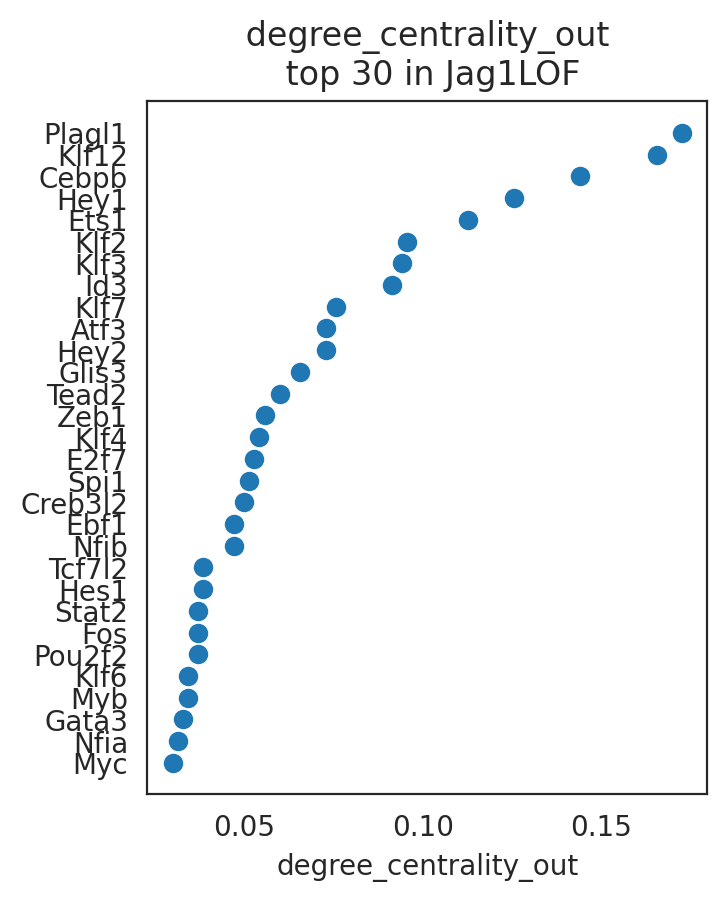

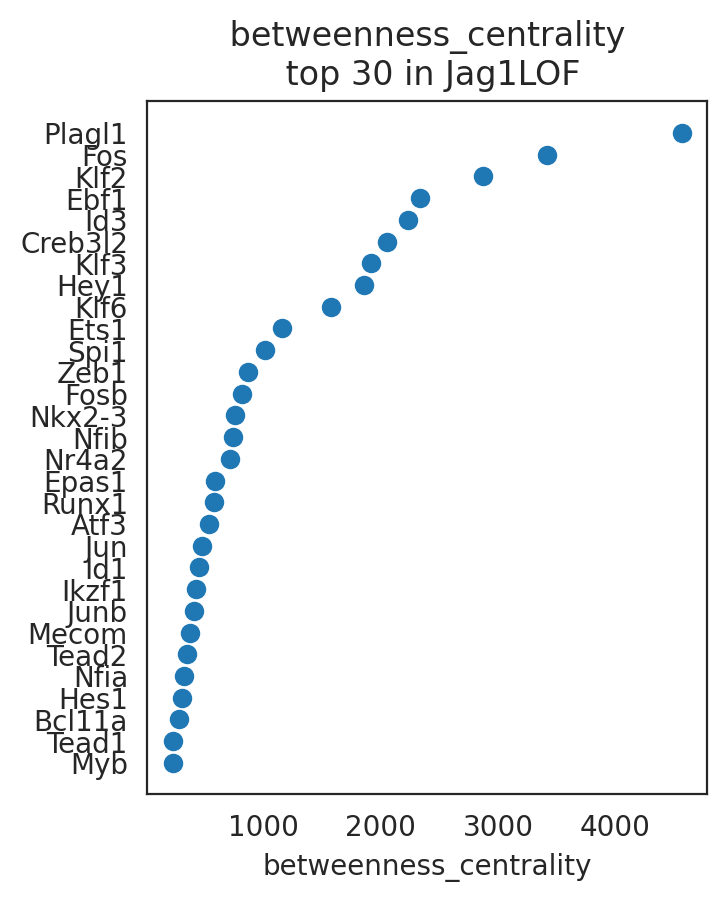

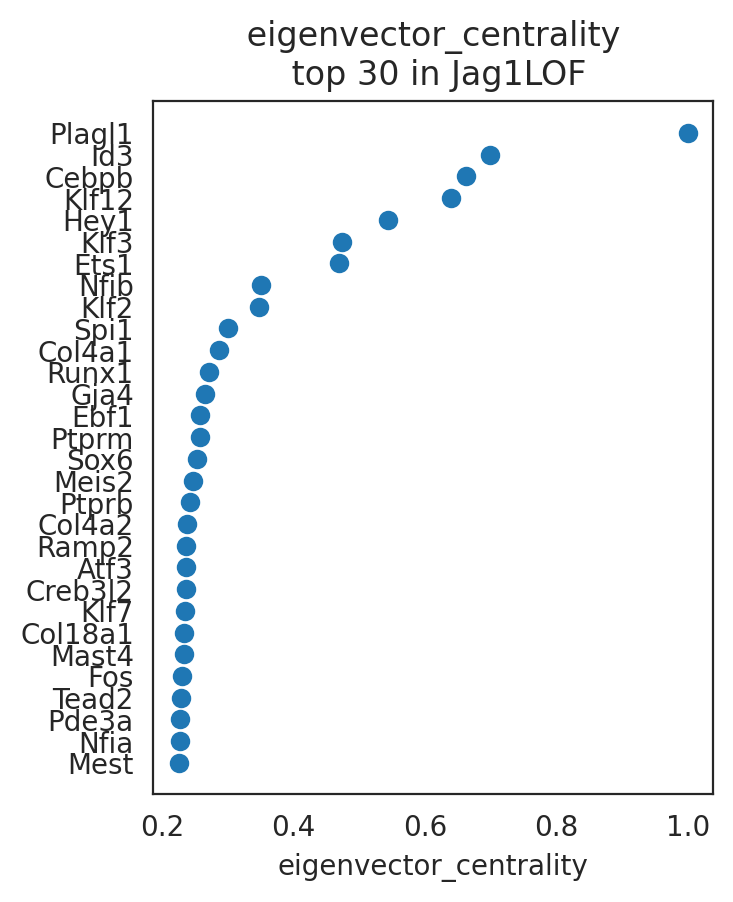

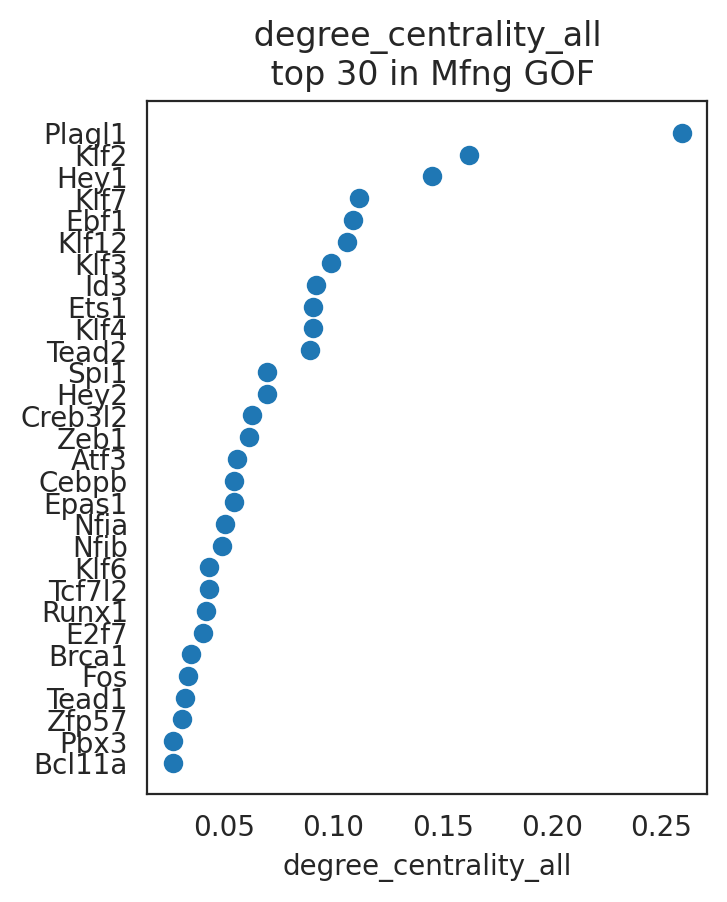

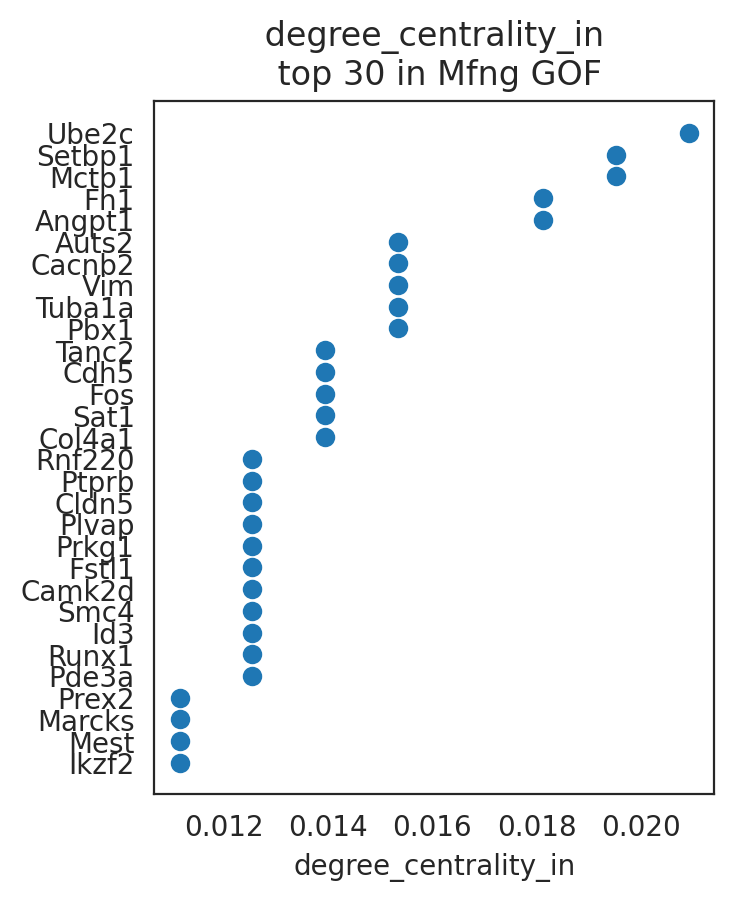

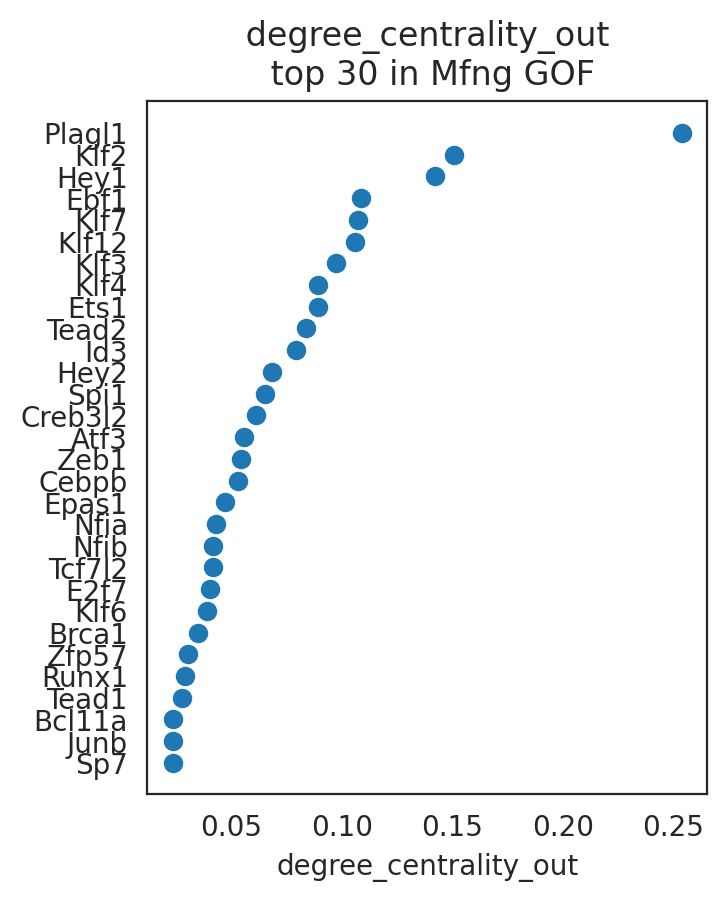

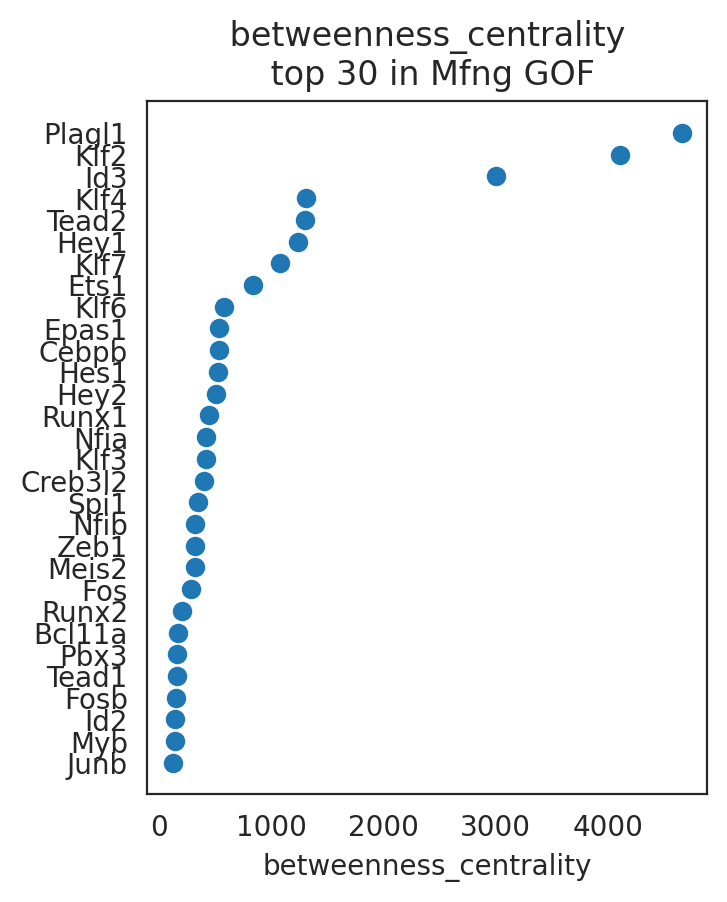

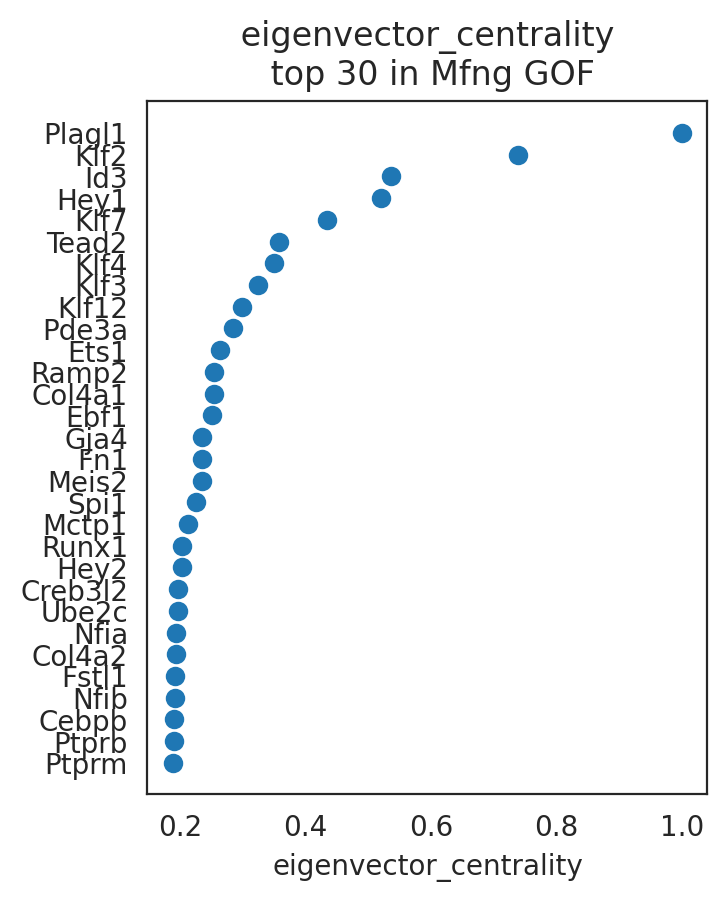

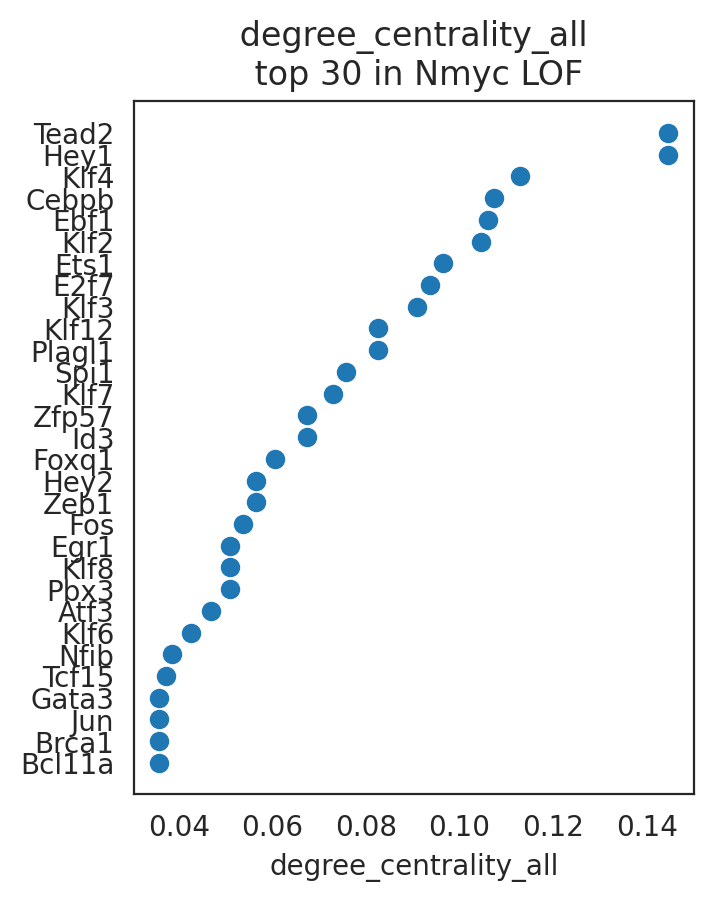

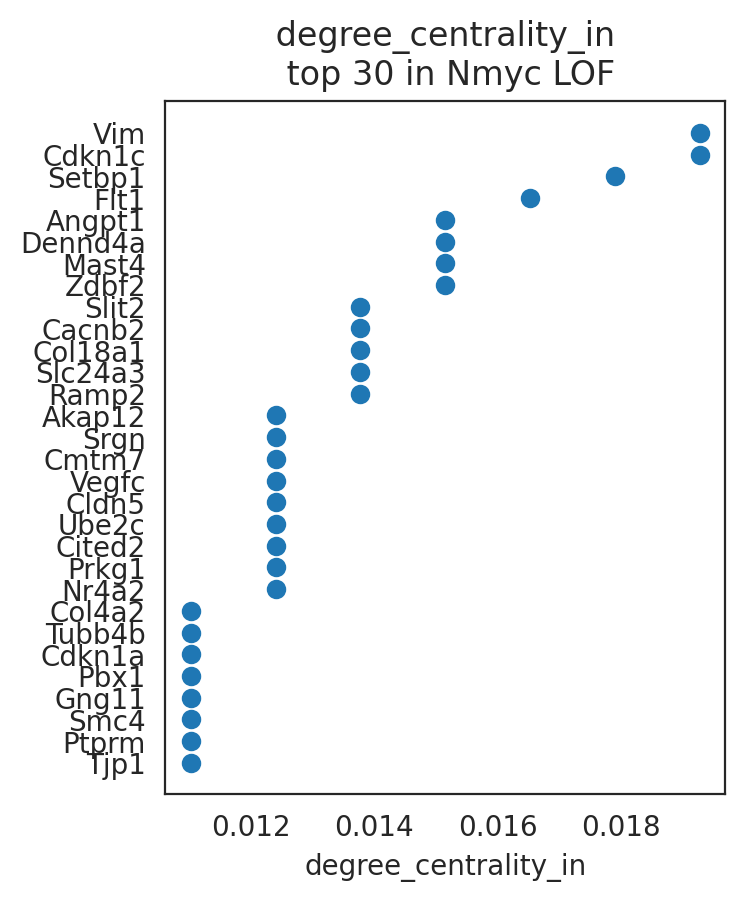

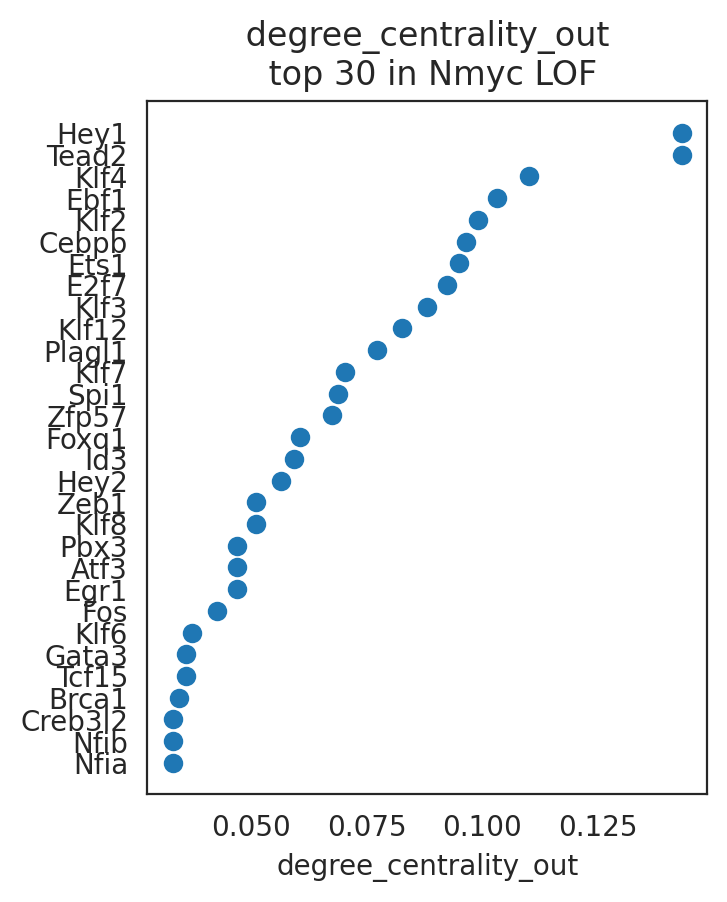

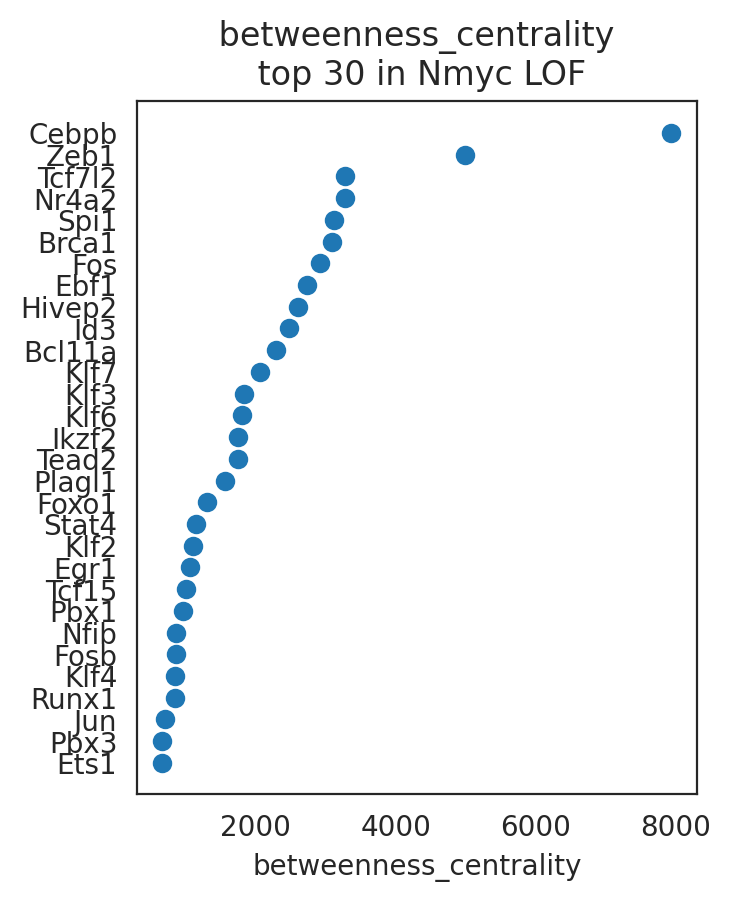

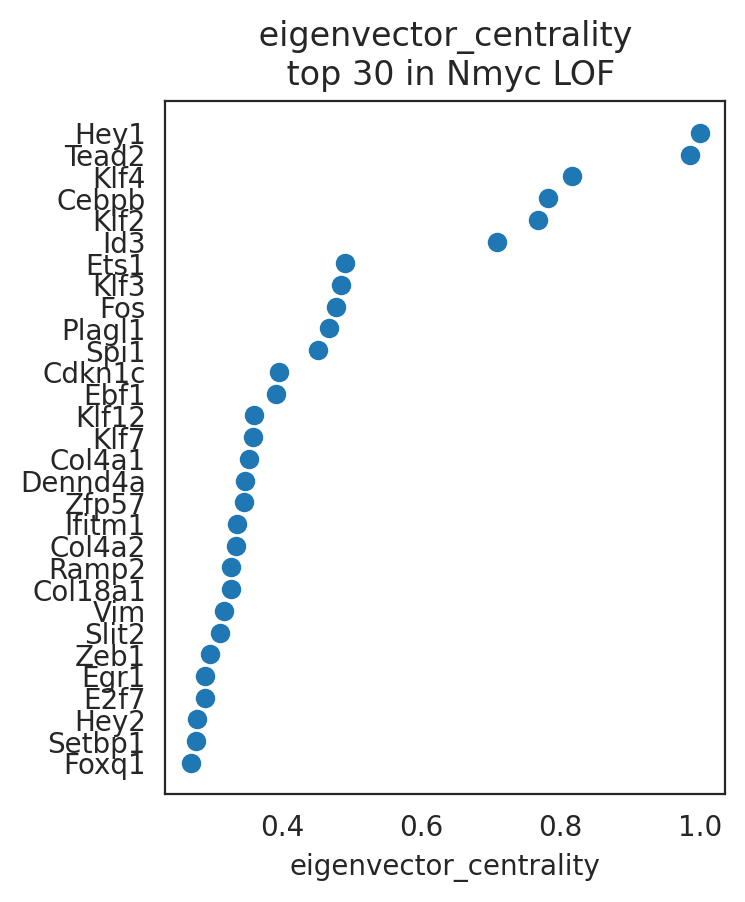

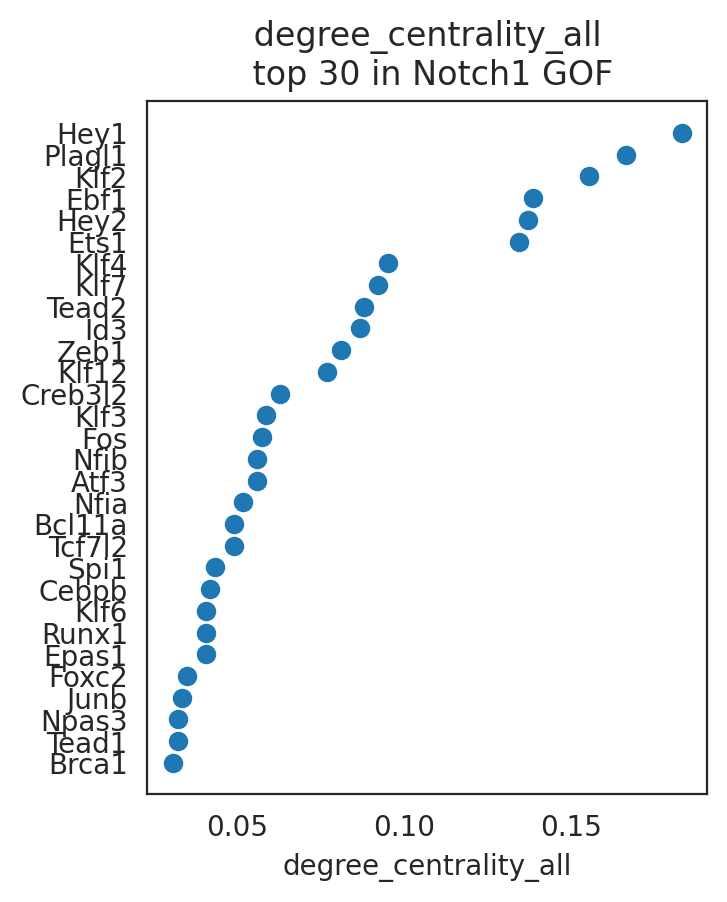

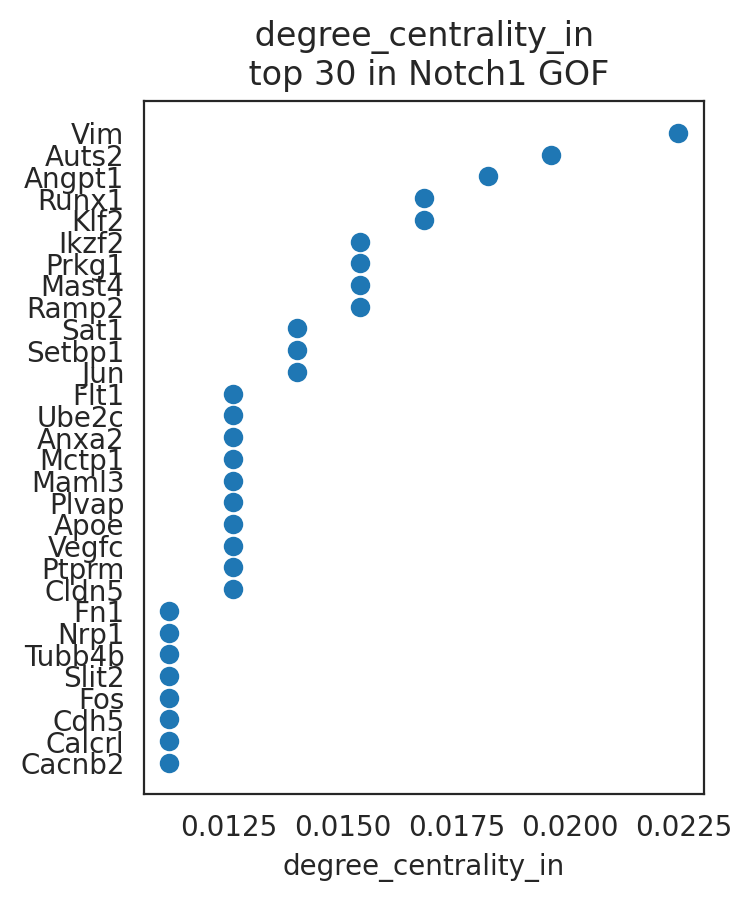

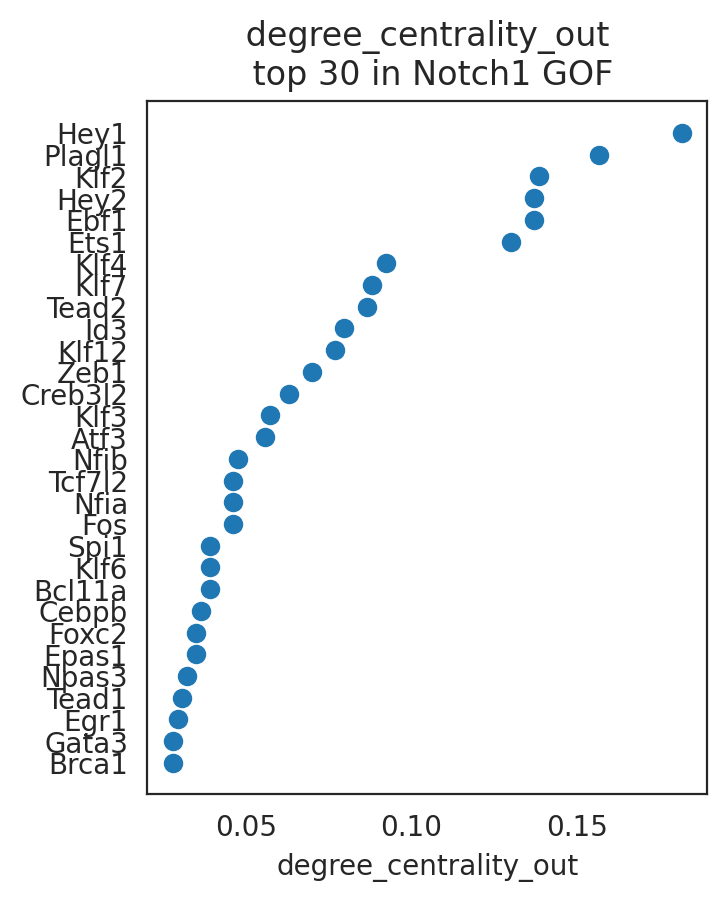

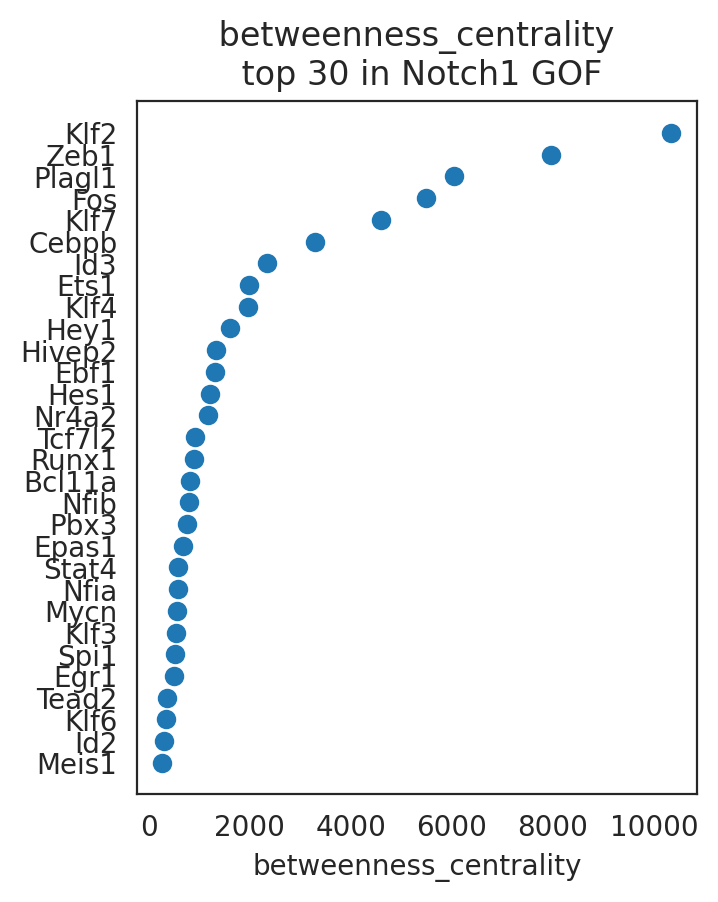

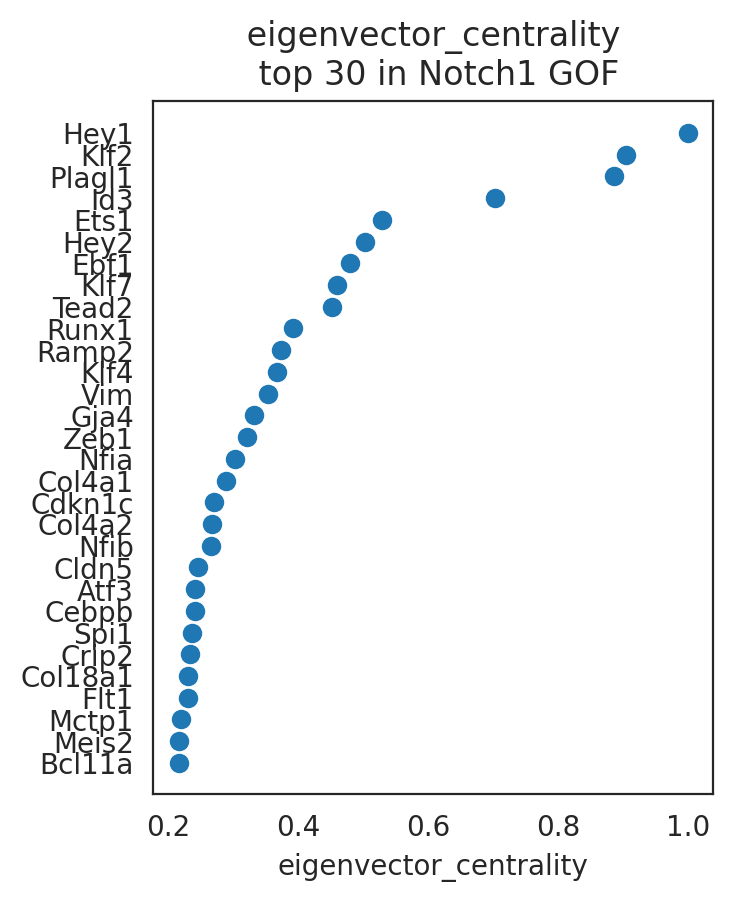

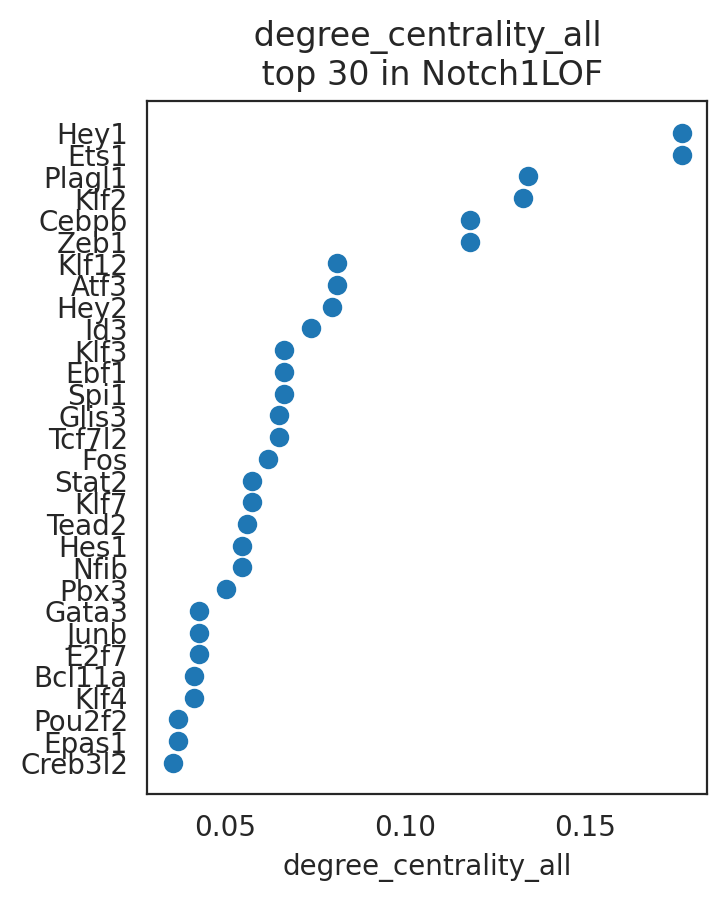

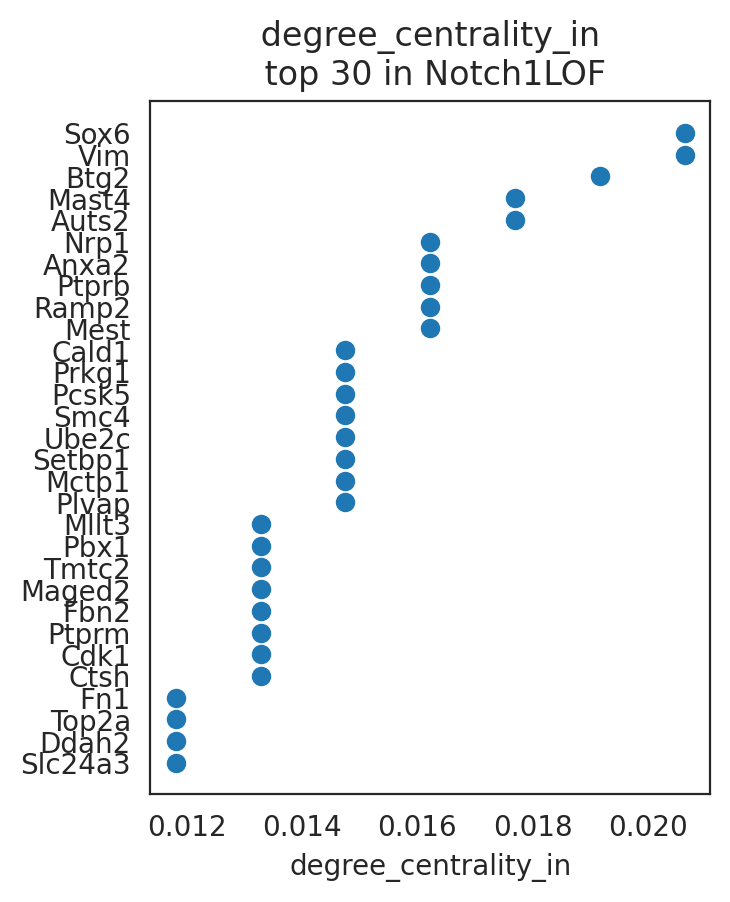

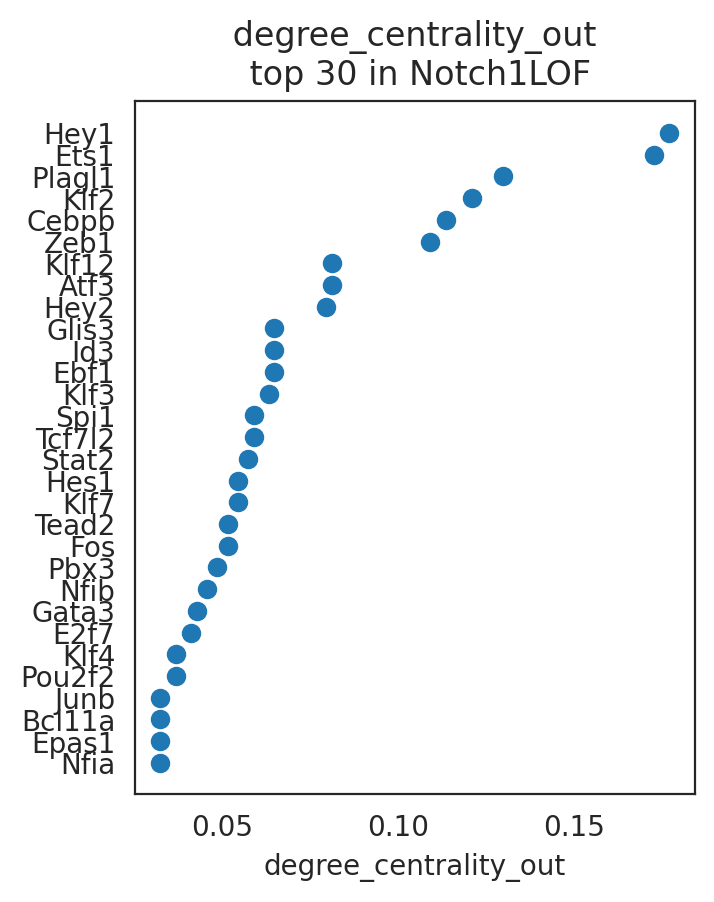

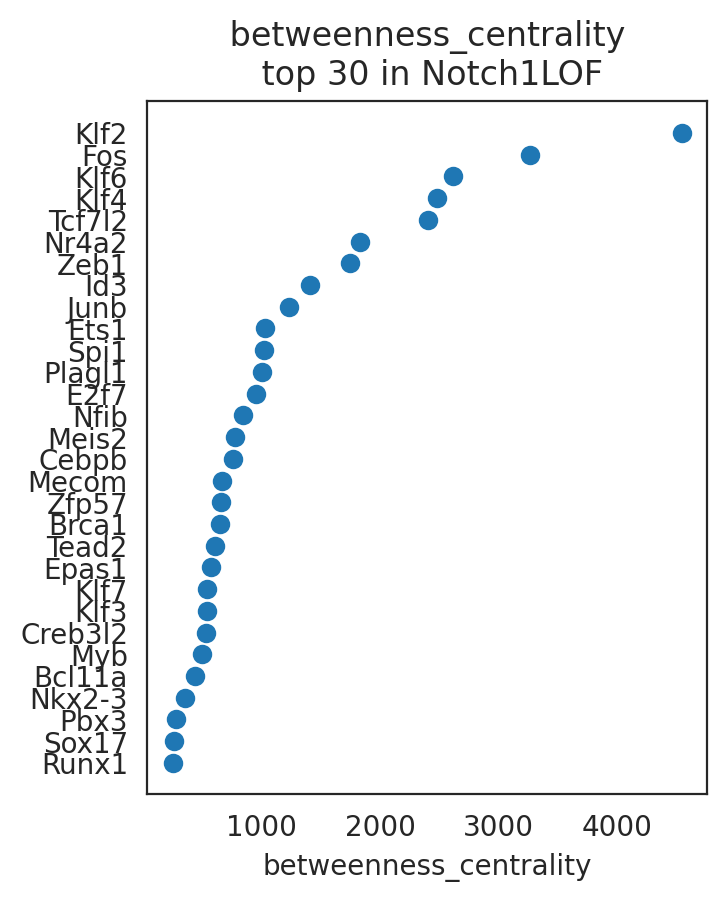

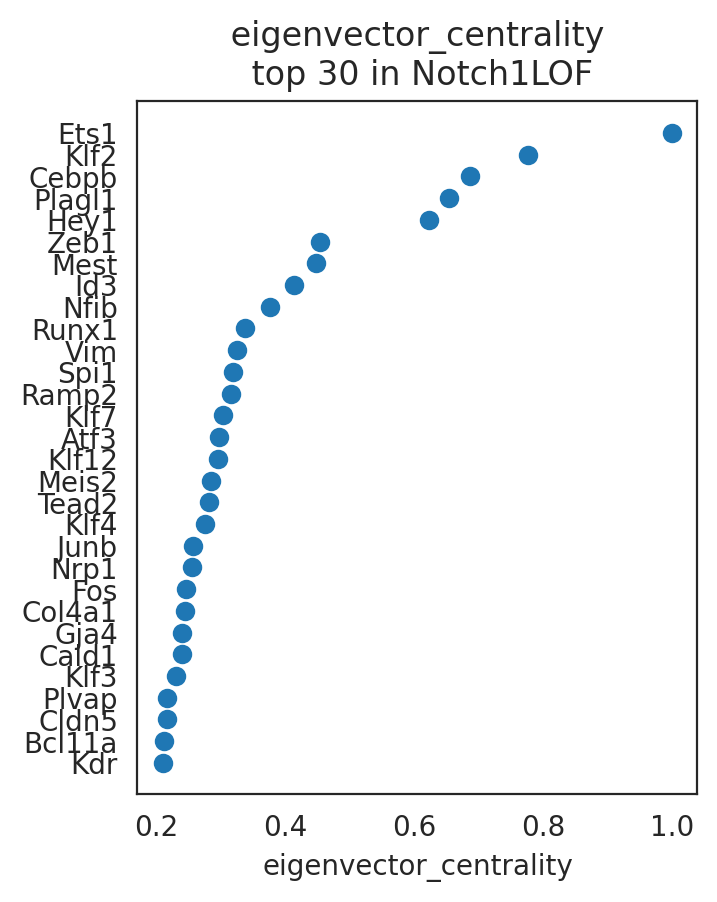

In [53]:
# Loop for rank plots

conditions = links.cluster
conditions

for i, cond in enumerate(conditions):
    save_folder_cond = ''.join([save_folder, '/', cond])
    os.makedirs(save_folder_cond, exist_ok=True)
    links.plot_scores_as_rank(cluster=cond, n_gene=30, 
                            #   save=f"{save_folder_cond}/ranked_score"
                              )

# links.plot_scores_as_rank(cluster="Control", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two conditions


By comparing network scores between two conditions, we can analyze differences in GRN structure between Control and the various modified conditions.

In [55]:
from adjustText import adjust_text

def _plot_goi_repel(x, y, gois, args_annot, scatter=False, x_shift=0.1, y_shift=0.1):
    """
    Plot an annoation to highlight one point in scatter plot.

    Args:
        x (float): Cordinate-x.
        y (float): Cordinate-y.
        args_annot (dictionary): arguments for matplotlib.pyplot.annotate().
        scatter (bool): Whether to plot dot for the point of interest.
        x_shift (float): distance between the annotation and the point of interest in the x-axis.
        y_shift (float): distance between the annotation and the point of interest in the y-axis.
    """

    default = {"size": 10}
    default.update(args_annot)
    args_annot = default.copy()

    arrow_dict = {"width": 0.5, "headwidth": 0.5, "headlength": 1, "color": "red"}
    if scatter:
        plt.scatter(x, y, c="red", edgecolor="none")
        # plt.annotate(f"{gois}", xy=(x, y), xytext=(x+x_shift, y+y_shift),
        #          color="red", arrowprops=arrow_dict, **args_annot)
    
    # Repel annotations to avoid overlap
    else:
        texts = [plt.text(x[i], y[i], goi, color="black", **args_annot) for i, goi in enumerate(gois)]
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))


## plot_score_comparison_2D_manual Function

To produce a more eye pleasing scatterplot of the various network indicator comparisons I produced the plot_score_comparison_2D_manual function.

In this function I make it possible to change the dot color palettes, to fine tune label text repel and to select goi that you can easily distinguish from the rest of transcritpion factors.

In [57]:
settings = {"save_figure_as": "pdf", "fig": "jpeg"}


def plot_score_comparison_2D_manual(links, value, cluster1, cluster2, cluster1_name = None, cluster2_name = None, percentile=99, annot_shifts=None, label_goi = None, save=None, fillna_with_zero=True, plt_show=True):
    """
    Make a scatter plot that shows the relationship of a specific network score in two groups.

    Args:
        links (Links object): See network_analisis.Links class for detail.
        value (srt): The network score to be shown.
        cluster1 (str): Cluster nome to analyze. Network scores in the cluste1 are shown as x-axis.
        cluster2 (str): Cluster nome to analyze. Network scores in the cluste2 are shown as y-axis.
        percentile (float): Genes with a network score above the percentile will be shown with annotation. Default is 99.
        annot_shifts ((float, float)): Shift x and y cordinate for annotations.
        save (str): Folder path to save plots. If the folde does not exist in the path, the function create the folder.
            If None plots will not be saved. Default is None.
    """
    res = links.merged_score[links.merged_score.cluster.isin([cluster1, cluster2])][[value, "cluster"]]
    res = res.reset_index(drop=False)
    piv = pd.pivot_table(res, values=value, columns="cluster", index="index")
    if fillna_with_zero:
        piv = piv.fillna(0)
    else:
        piv = piv.fillna(piv.mean(axis=0))

    goi1 = piv[piv[cluster1] > np.percentile(piv[cluster1].values, percentile)].index
    goi2 = piv[piv[cluster2] > np.percentile(piv[cluster2].values, percentile)].index

    gois = np.union1d(goi1, goi2)

    x, y = piv[cluster1], piv[cluster2]
    plt.scatter(x, y, c="lightgray", edgecolor="none")

    if annot_shifts is None:
        x_shift, y_shift = (x.max() - x.min())*0.03, (y.max() - y.min())*0.03
    else:
        x_shift, y_shift = annot_shifts

    if label_goi is not None:
        for i, goi in enumerate(label_goi):
            x[i], y[i] = piv.loc[goi, cluster1], piv.loc[goi, cluster2]
            _plot_goi_repel(x[i], y[i], goi, {}, scatter=True, x_shift=x_shift, y_shift=y_shift)
            
    if label_goi is not None:
        gois = np.setdiff1d(gois, label_goi)
        gois = np.union1d(gois, label_goi)

    for i, goi in enumerate(gois):
        x[i], y[i] = piv.loc[goi, cluster1], piv.loc[goi, cluster2]

        # _plot_goi_repel(x, y, goi, {}, scatter=False, x_shift=x_shift, y_shift=y_shift)

    # print(x, y, gois)
        
    _plot_goi_repel(x, y, gois, {}, scatter=False, x_shift=x_shift, y_shift=y_shift)
    
    if x.max() == y.max():
        plt.plot([0, x.max()], [0, y.max()], 'k--')
    else:
        plt.plot([0, max(x.max(), y.max())], [0, max(x.max(), y.max())], 'k--')


    if cluster1_name and cluster2_name is not None:
        plt.xlabel(cluster1_name)
        plt.ylabel(cluster2_name)
    else:
        plt.xlabel(cluster1)
        plt.ylabel(cluster2)
    
    text_value = f"{value}"
    title = text_value.replace("_", " ")
    title = title.capitalize()
    
    plt.title(title)
    if not save is None:
        os.makedirs(save, exist_ok=True)
        path = os.path.join(save, f"values_comparison_in_{links.name}_{value}_{links.threshold_number}_{cluster1}_vs_{cluster2}.{settings['save_figure_as']}")
        plt.savefig(path, transparent=True)
        path = os.path.join(save, f"values_comparison_in_{links.name}_{value}_{links.threshold_number}_{cluster1}_vs_{cluster2}.{settings['fig']}")
        plt.savefig(path, transparent=False)
    if plt_show:
        plt.show()



In [58]:
adata_celloracle.obs['Condition'].unique()

['Mfng GOF', 'Control', 'Notch1 GOF', 'Nmyc LOF', 'Control VEQ', 'Jag1LOF', 'Notch1LOF']
Categories (7, object): ['Control', 'Control VEQ', 'Jag1LOF', 'Mfng GOF', 'Nmyc LOF', 'Notch1 GOF', 'Notch1LOF']

In [21]:
save_folder = "../../Plots/Paper/CellOracle/New/"

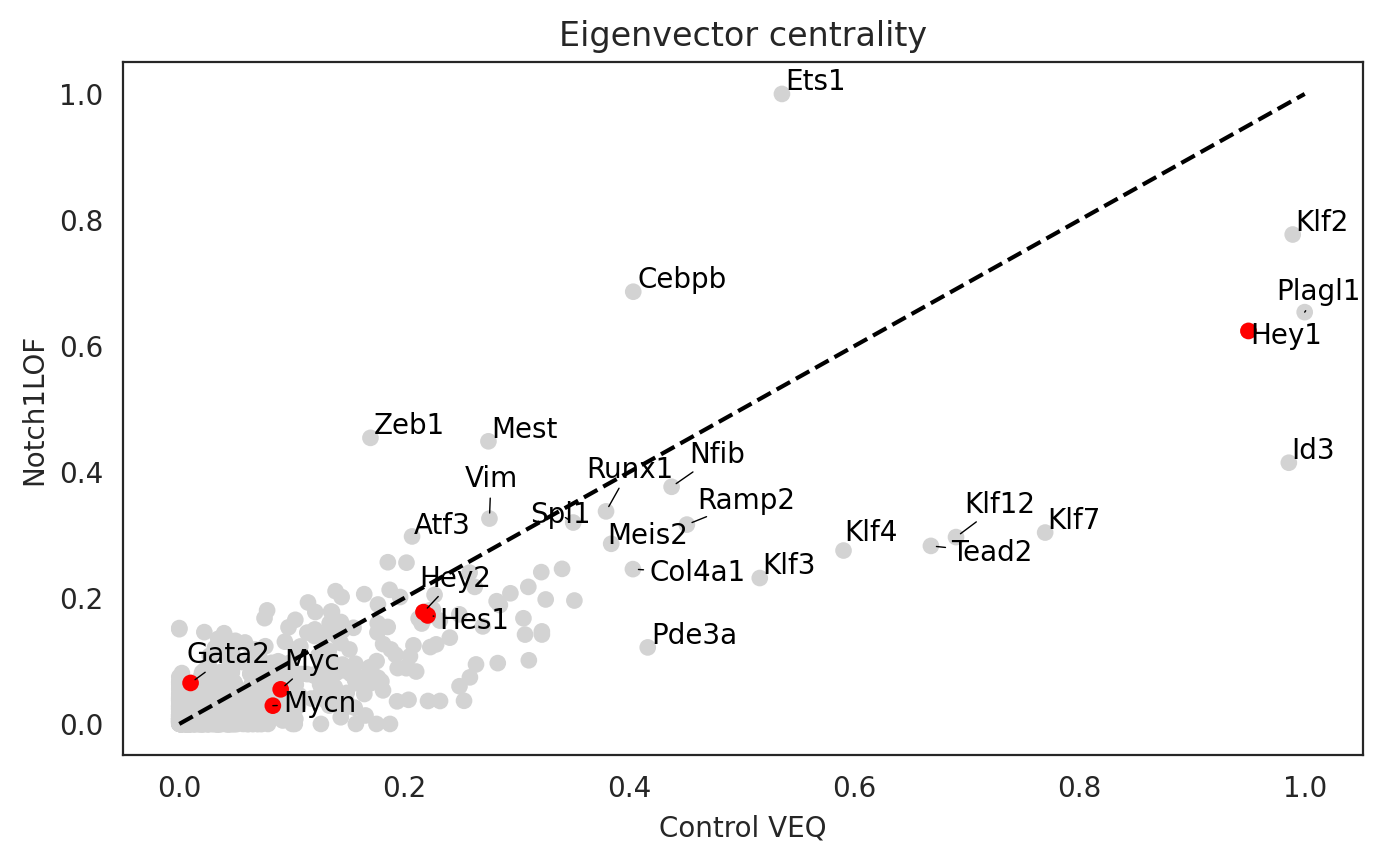

In [59]:
# Compare GRN score between two clusters
plot_score_comparison_2D_manual(links, value="eigenvector_centrality",
                               cluster1="Control VEQ", cluster2="Notch1LOF", 
                               percentile=98,
                               label_goi=["Hey1", "Hey2", "Hes1", "Gata2", "Myc", "Mycn"],
                               plt_show=True,
                            #    save=f"{save_folder}/score_comparisons"
                               )

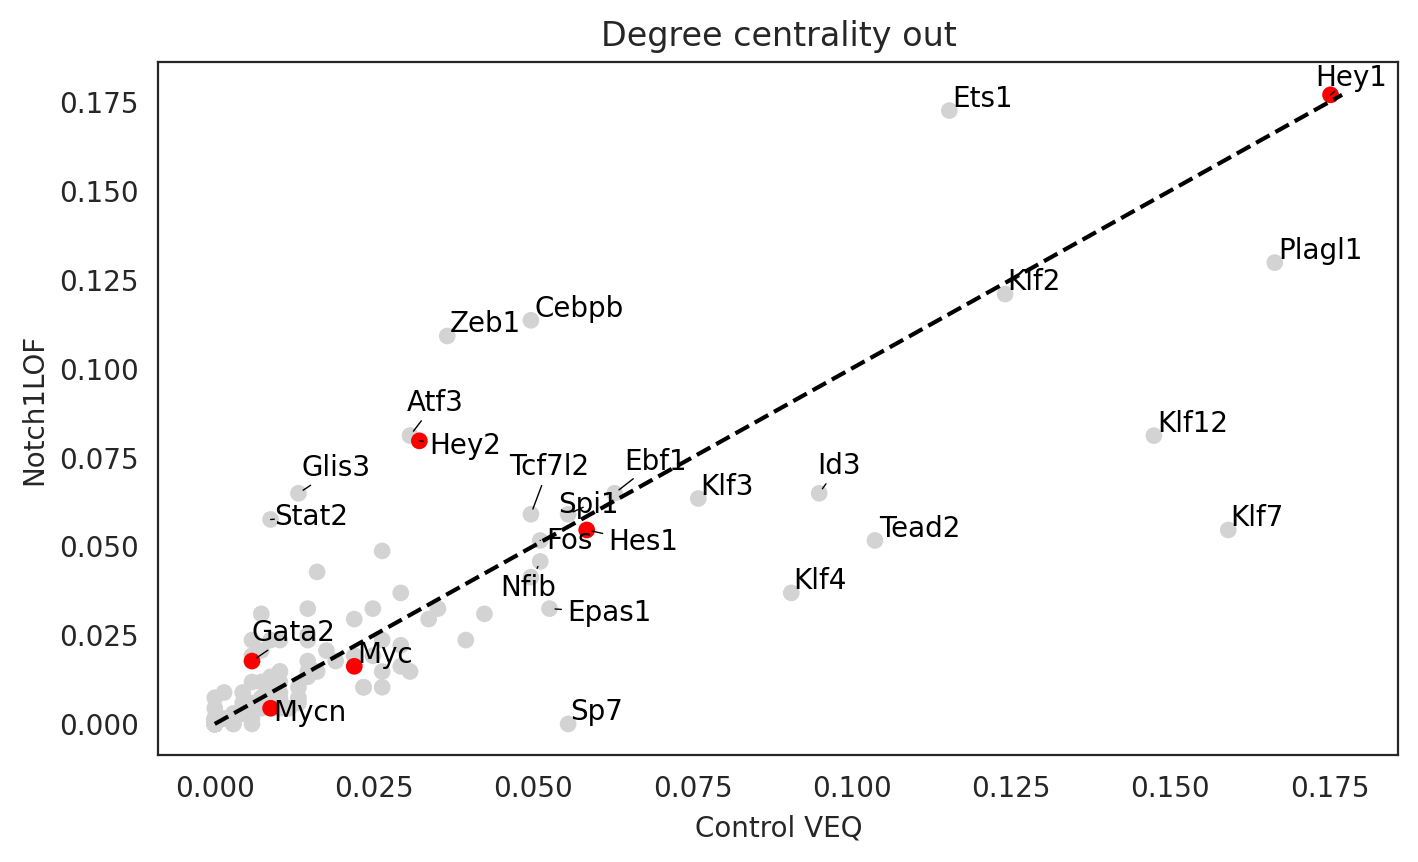

In [60]:
# Compare GRN score between two clusters
plot_score_comparison_2D_manual(links, value="degree_centrality_out",
                               cluster1="Control VEQ", cluster2="Notch1LOF", 
                               percentile=98,
                               label_goi=["Hey1", "Hey2", "Hes1", "Gata2", "Myc", "Mycn"],
                            #    save=f"{save_folder}/score_comparisons"
                               )

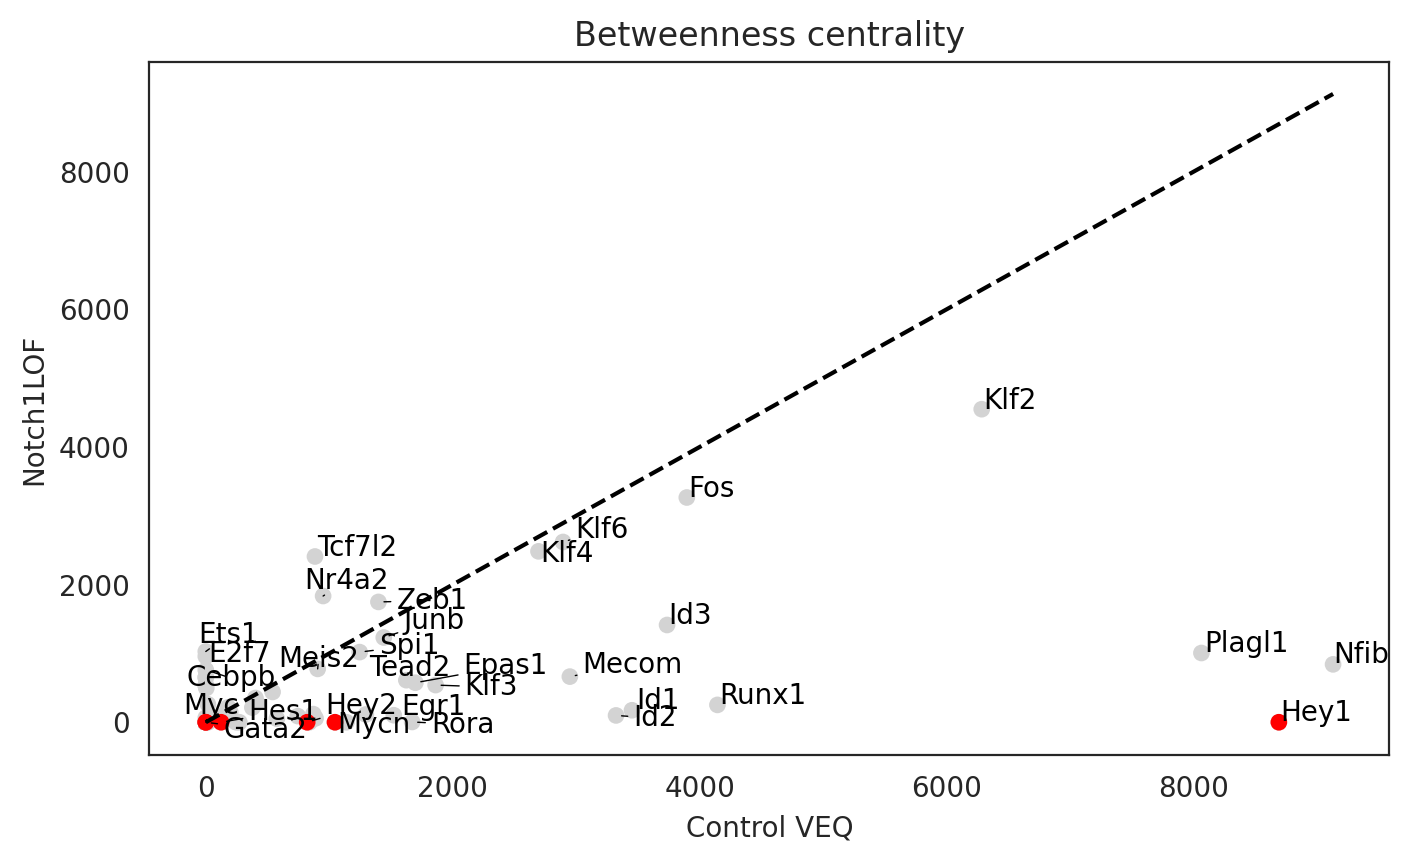

In [24]:
# Compare GRN score between two clusters
plot_score_comparison_2D_manual(links, value="betweenness_centrality",
                               cluster1="Control VEQ", cluster2="Notch1LOF", 
                               label_goi=["Hey1", "Hey2", "Hes1", "Gata2", "Myc", "Mycn"],
                               percentile=98, 
                               save=f"{save_folder}/score_comparisons")

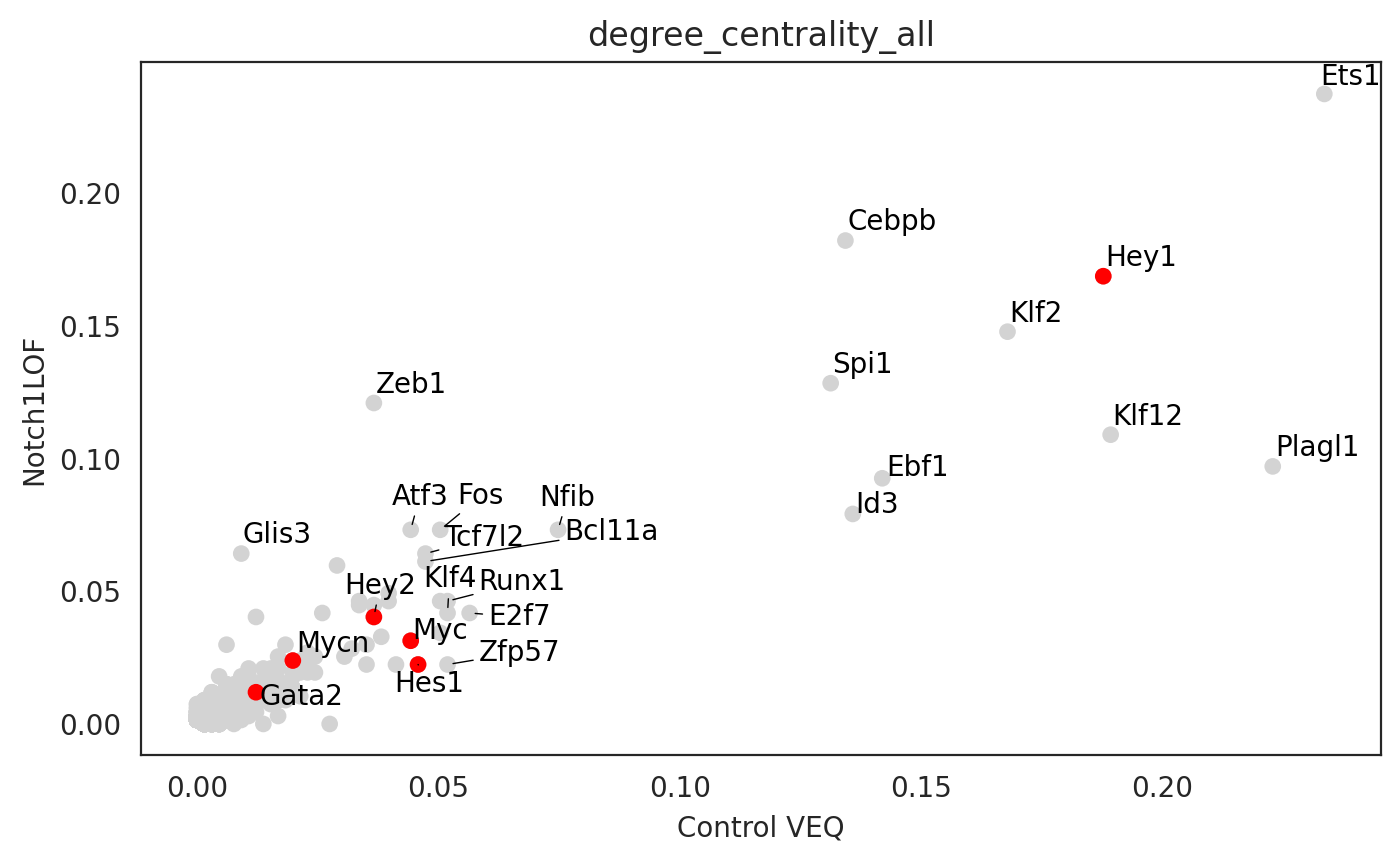

In [217]:
# Compare GRN score between two clusters
plot_score_comparison_2D_manual(links, value="degree_centrality_all",
                                label_goi=["Hey1", "Hey2", "Hes1", "Gata2", "Myc", "Mycn"],
                               cluster1="Control VEQ", cluster2="Notch1LOF", 
                               percentile=98, save=f"{save_folder}/score_comparisons")

## Loop Score comparison Control v Conditions

In [61]:
# function to convert to superscript 
def get_super(x): 
	normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
	super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
	res = x.maketrans(''.join(normal), ''.join(super_s)) 
	return x.translate(res) 

# display superscipt 
print(get_super('GeeksforGeeks')) #ᴳᵉᵉᵏˢᶠᵒʳᴳᵉᵉᵏˢ 


ᴳᵉᵉᵏˢᶠᵒʳᴳᵉᵉᵏˢ


In [62]:
conditions = links.cluster
cond_tie2cre = [conditions[i] for i in [3,4,5]]
cond_veq = [conditions[i] for i in [2, 6]]

cluster1_names = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']
cluster2_name_veq = ["$Jag1^{\mathrm{iDEC}}$", "$Notch1^{\mathrm{iDEC}}$"]
cluster2_name_tie2cre = ["$Mfng^{\mathrm{iOE Tie2Cre}}$", "$NMyc^{\mathrm{LOF Tie2Cre}}$", "$Notch1^{\mathrm{iOE Tie2Cre}}$"]

cluster2_name_veq

['$Jag1^{\\mathrm{iDEC}}$', '$Notch1^{\\mathrm{iDEC}}$']

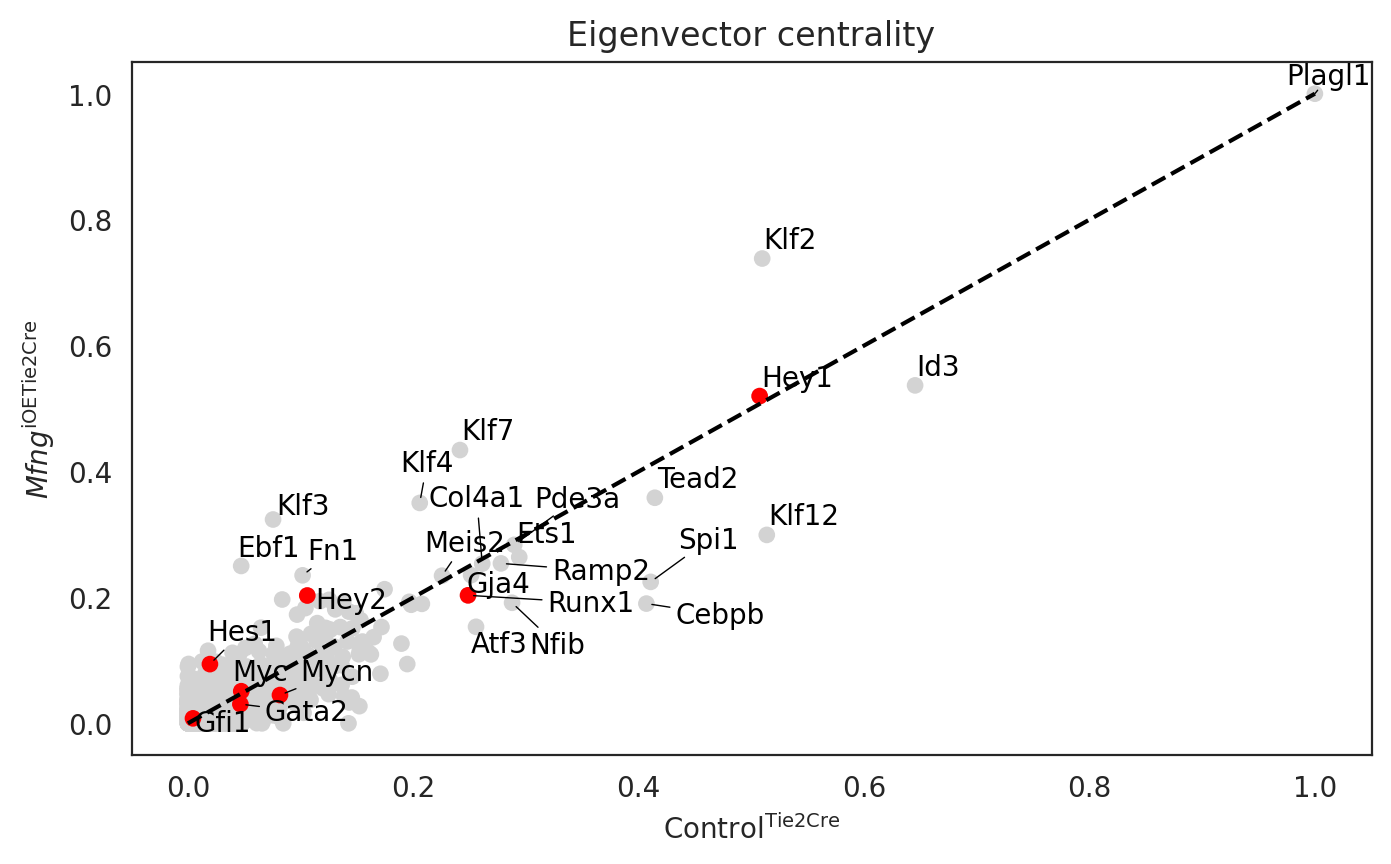

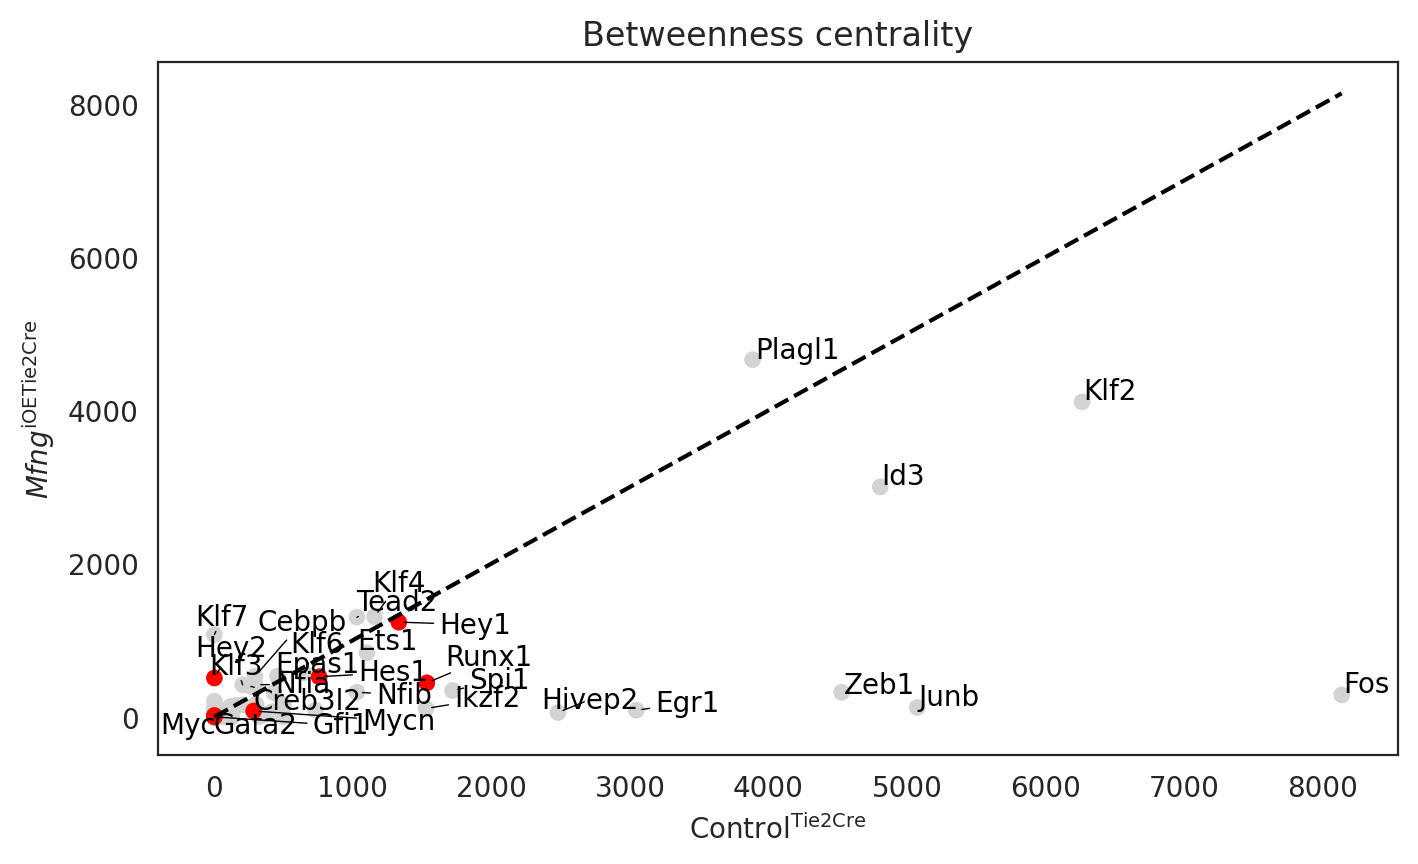

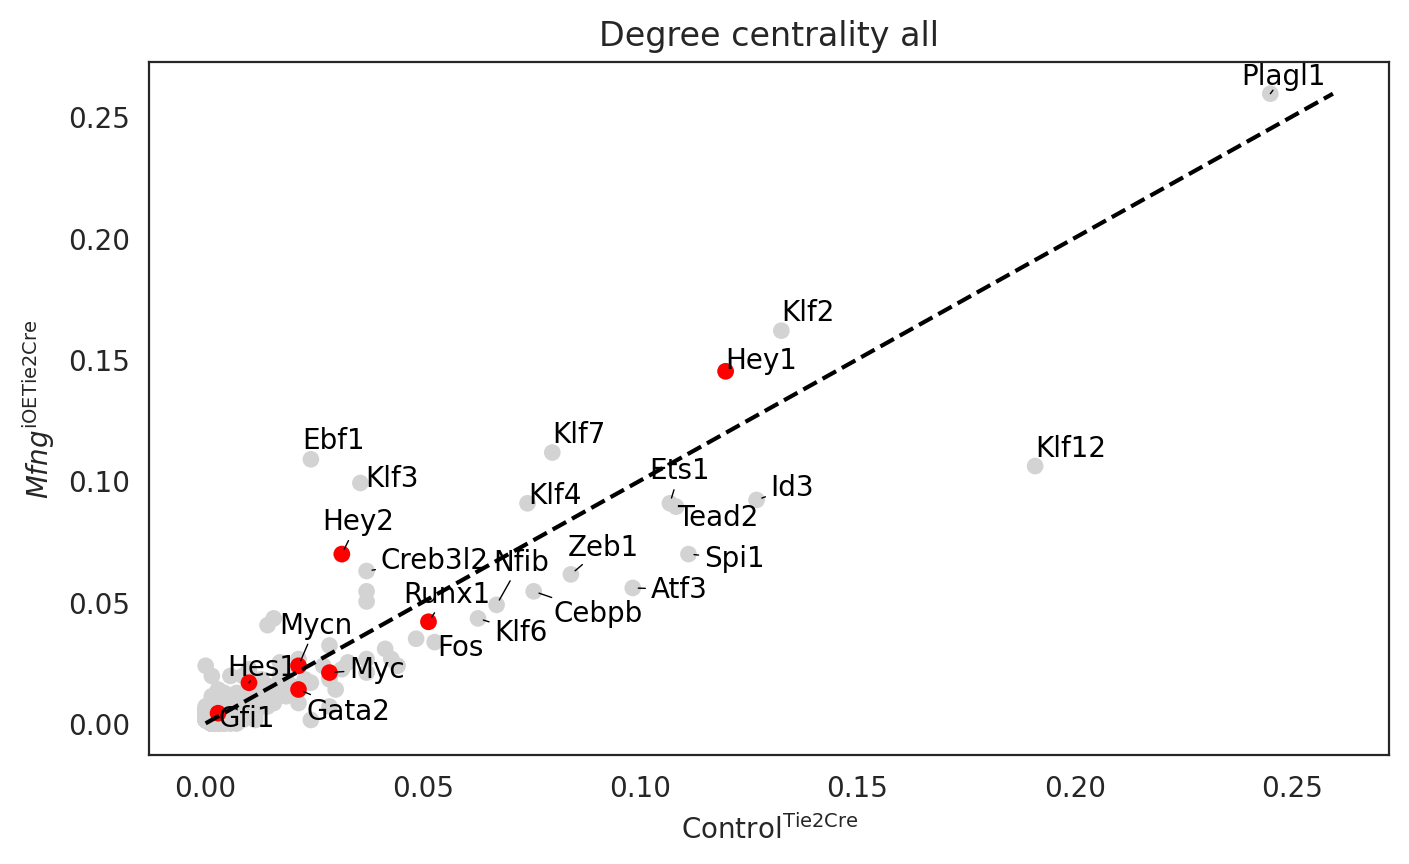

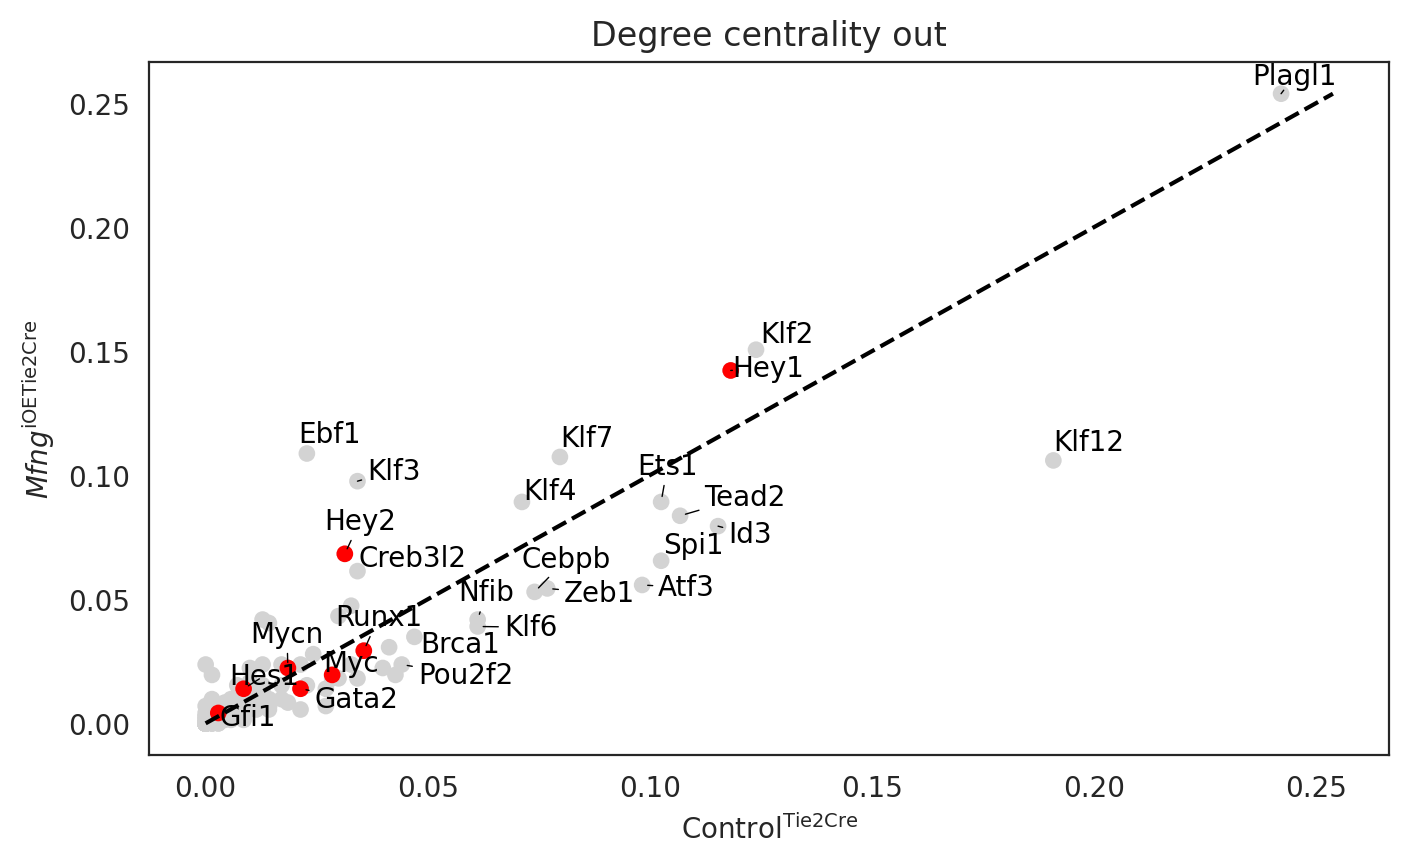

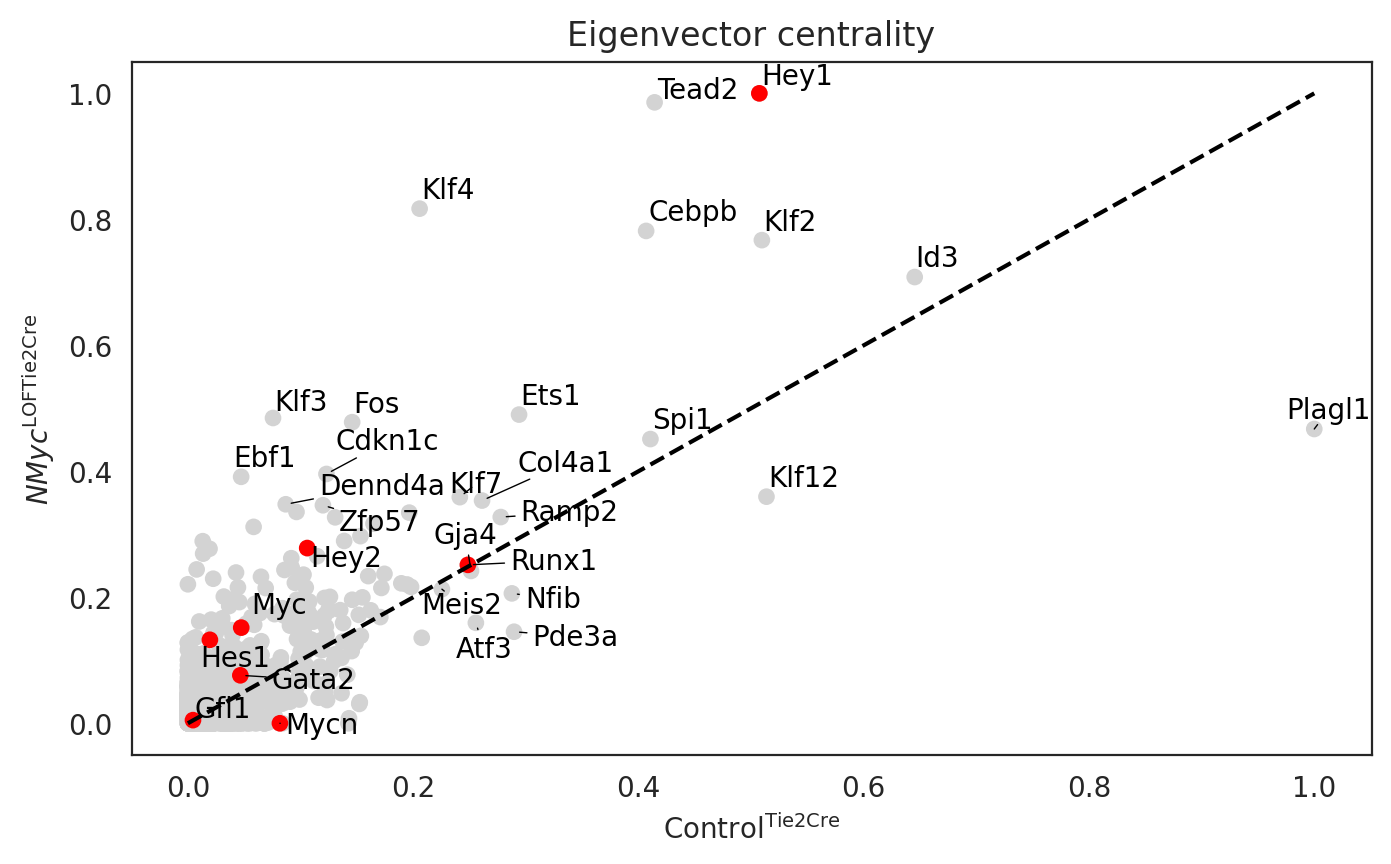

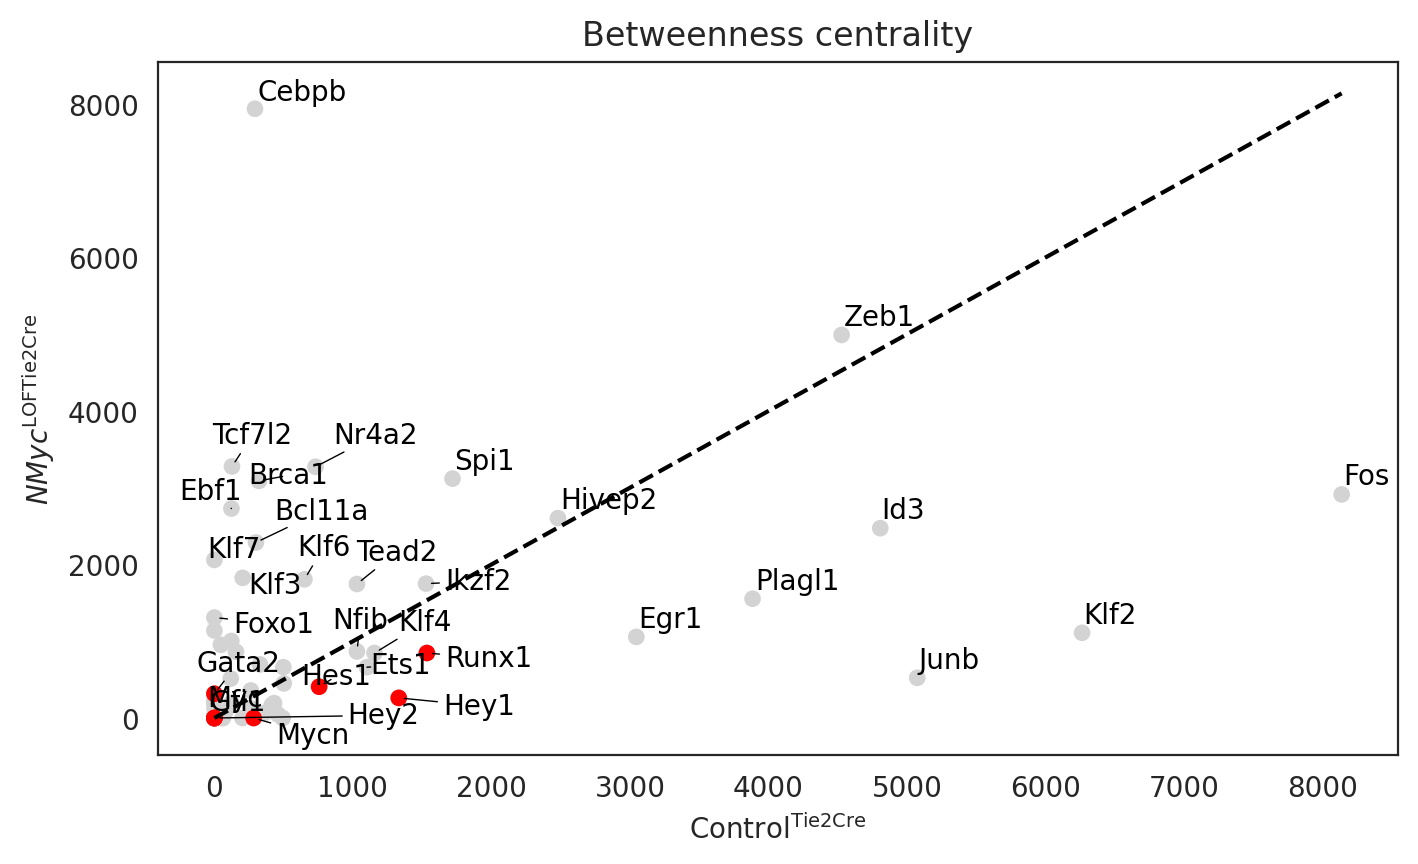

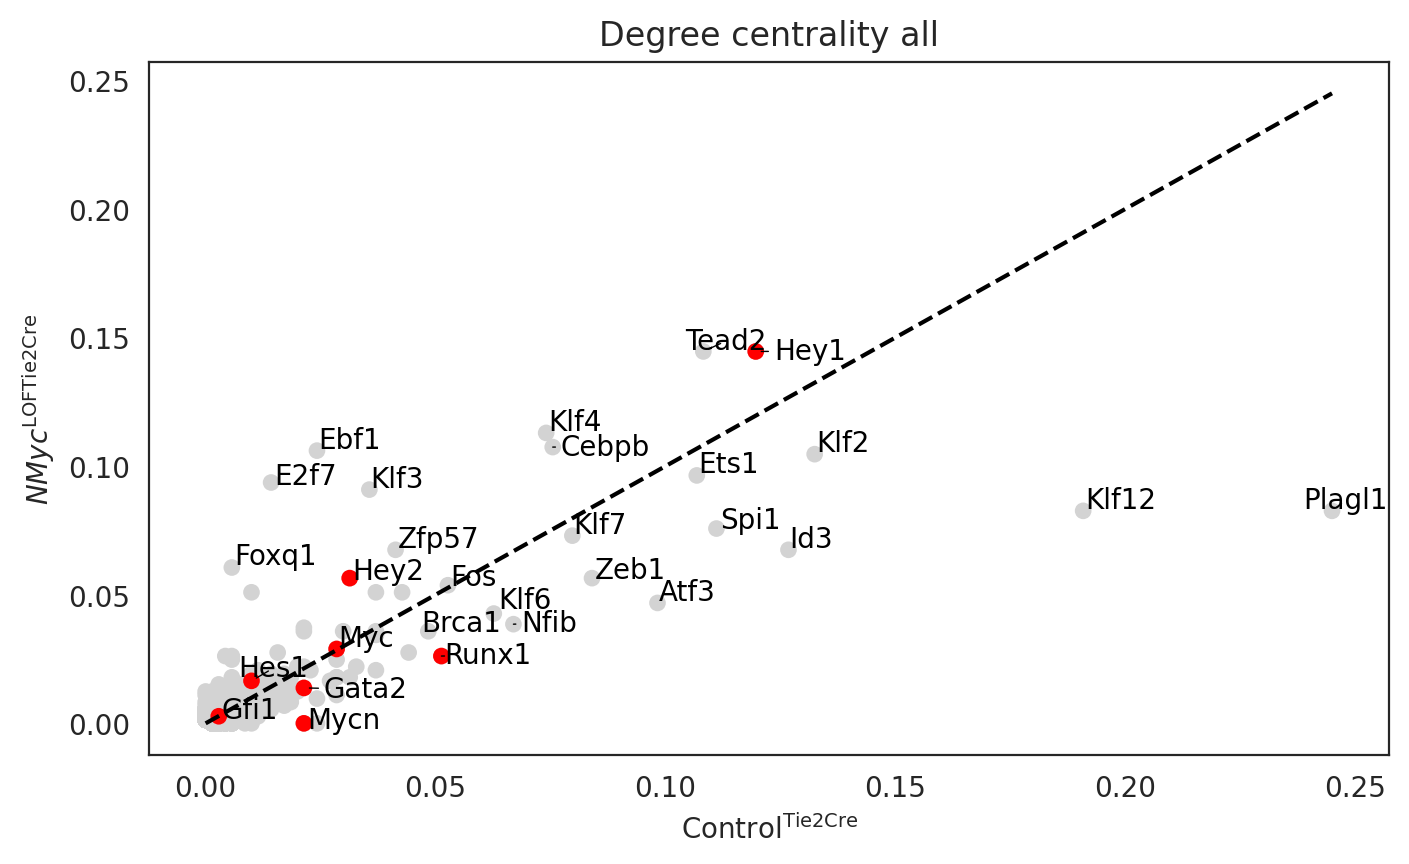

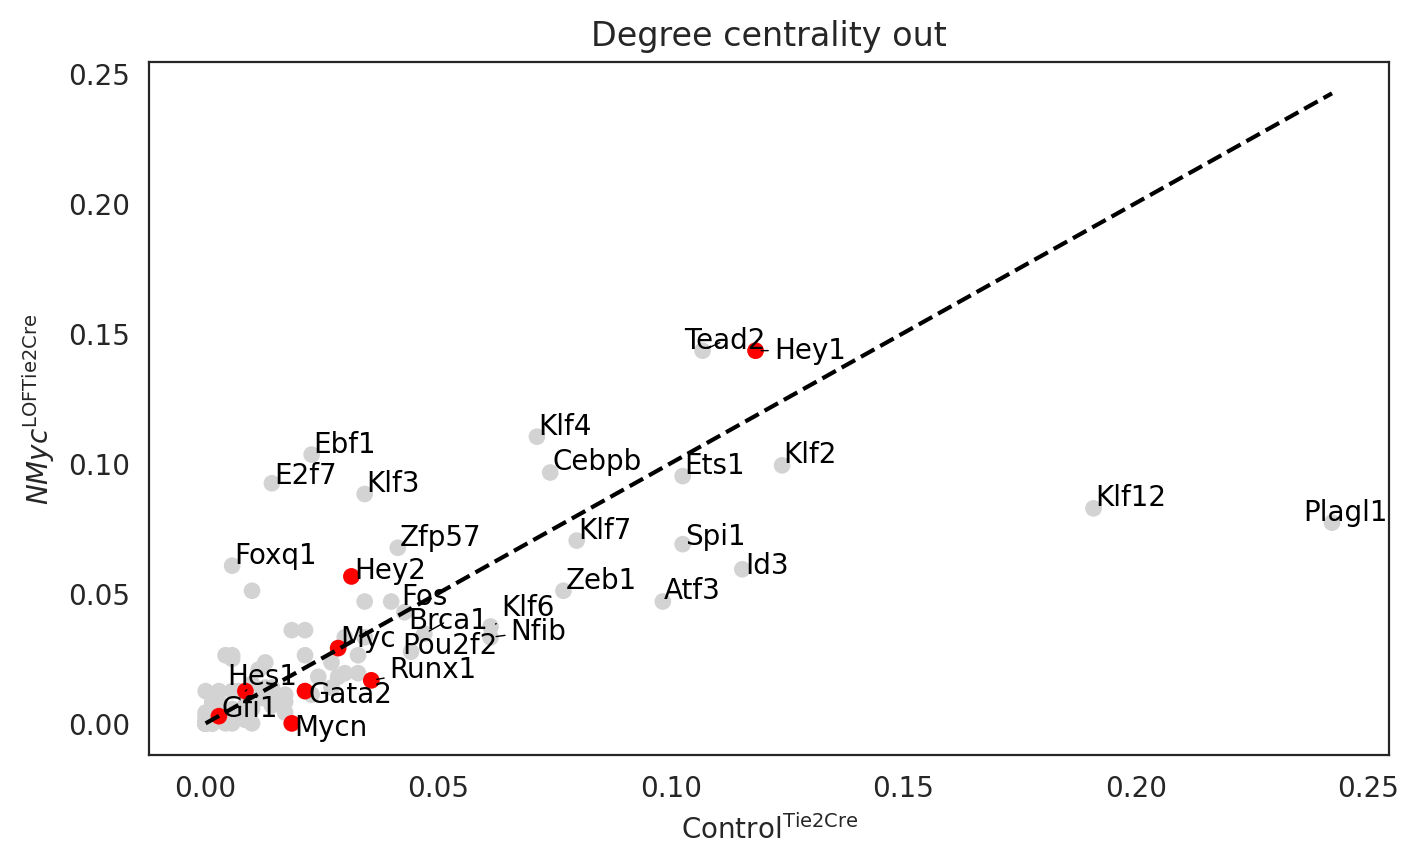

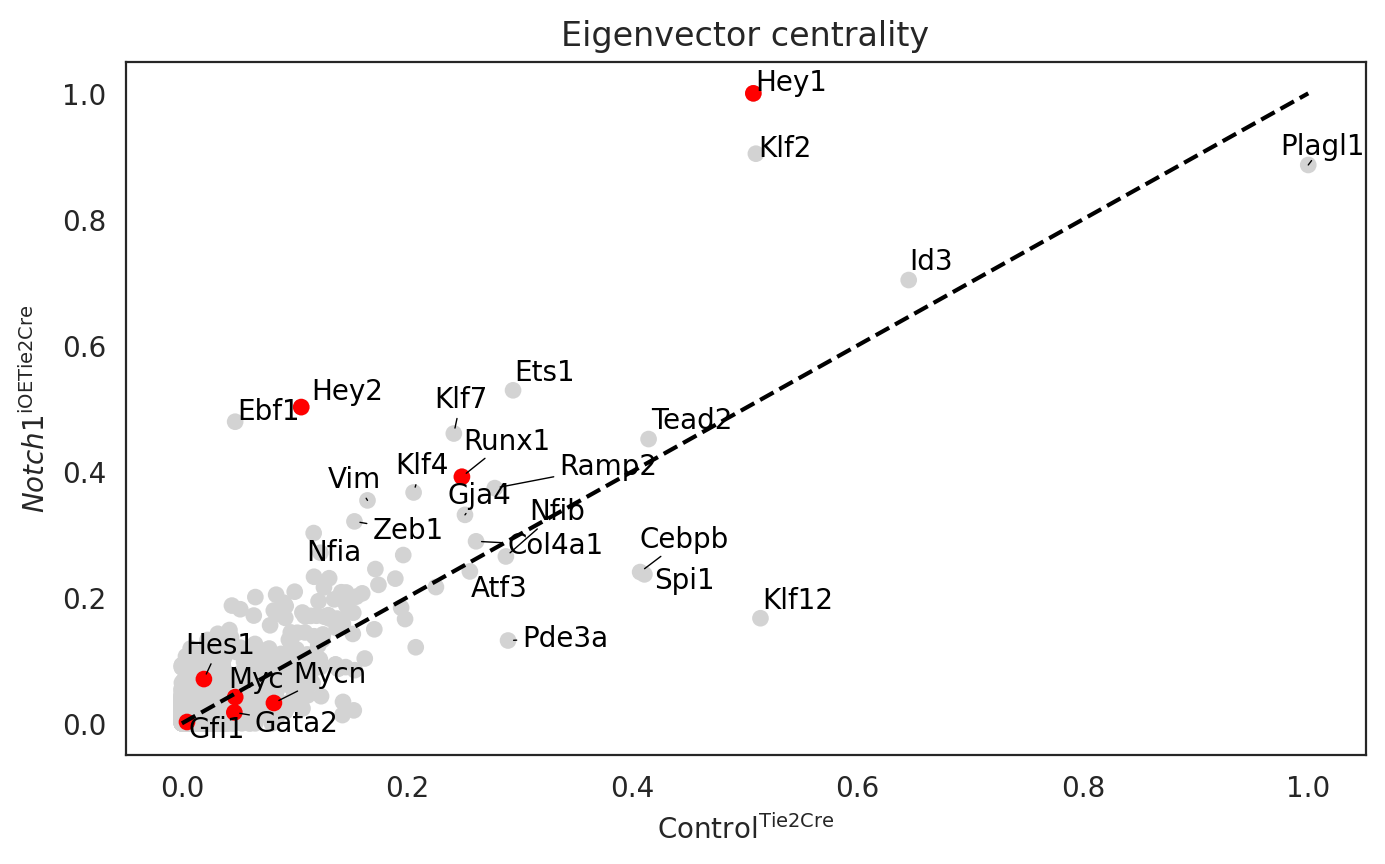

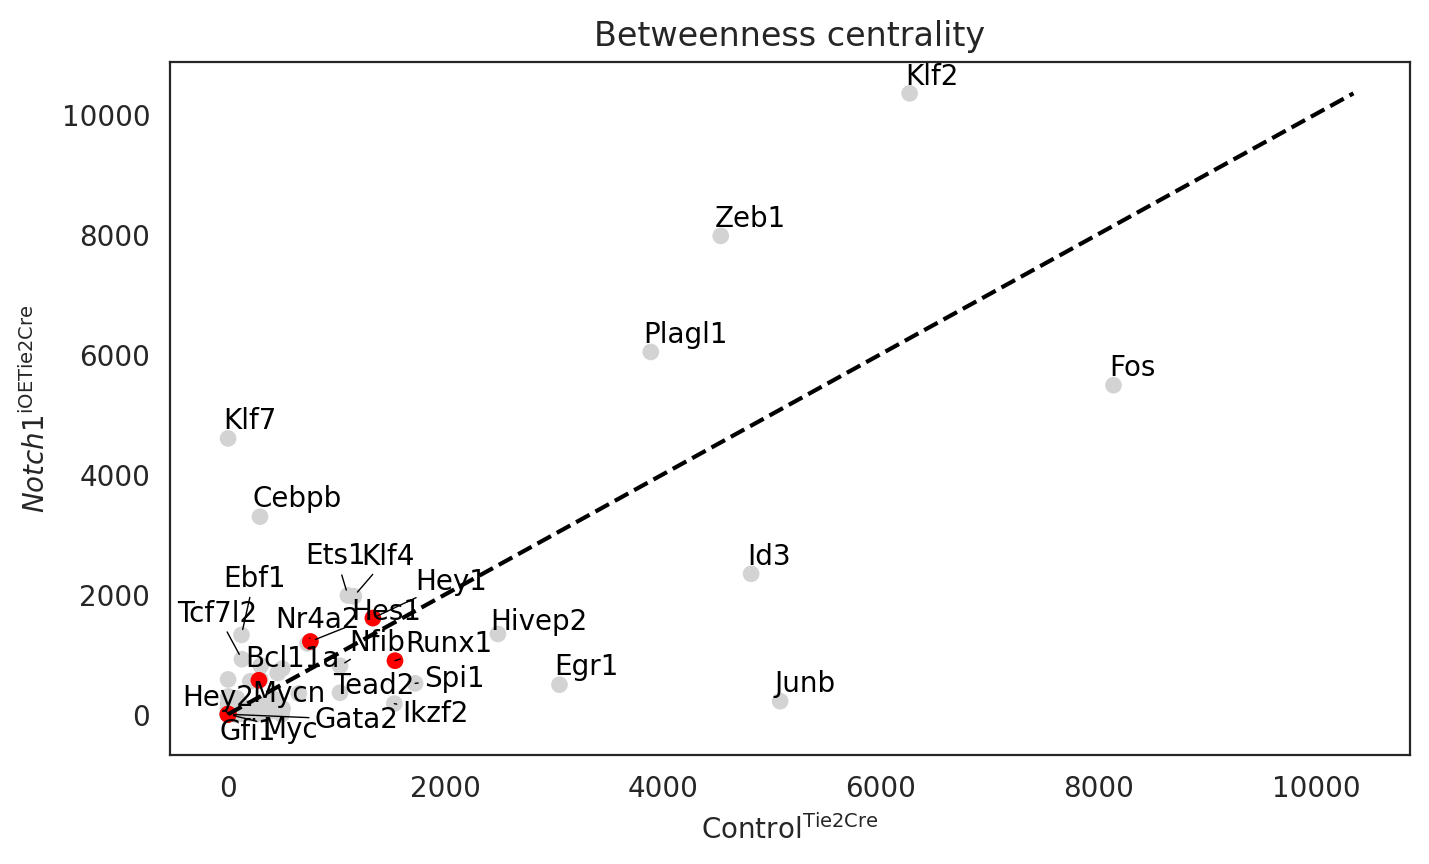

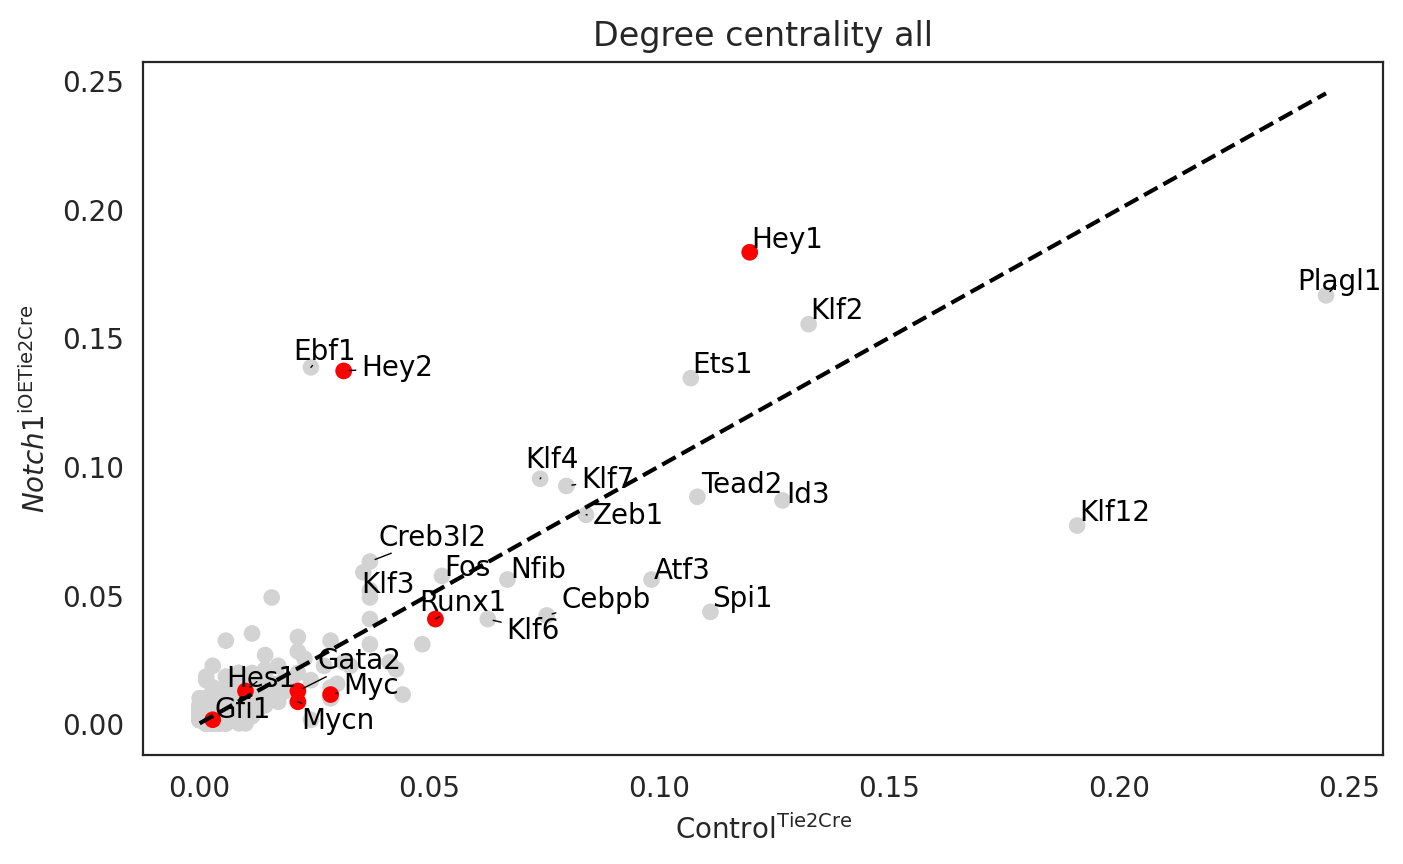

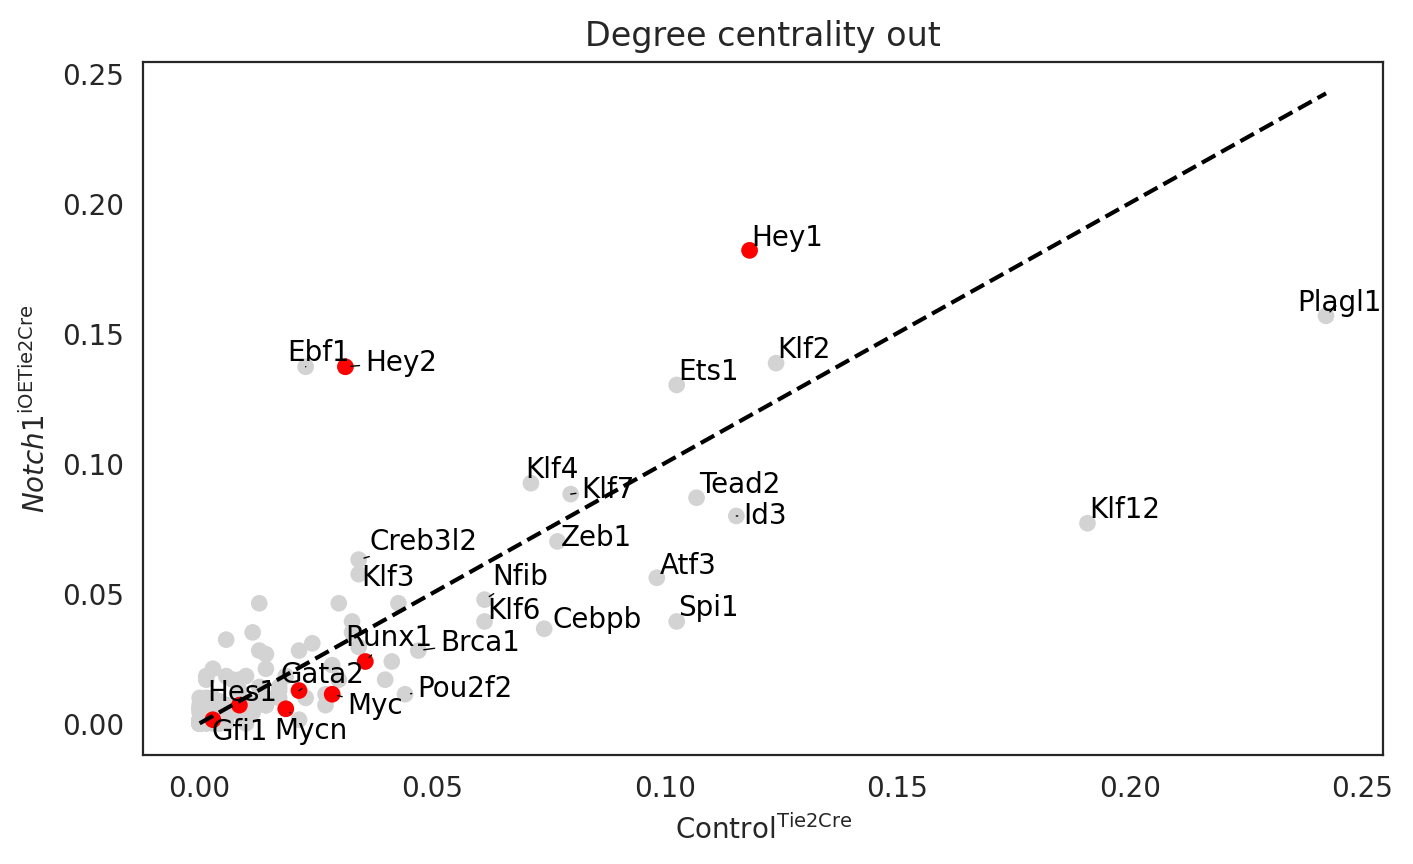

In [28]:
label_goi = ["Hey1", "Hey2", "Hes1", "Gata2", "Myc", "Mycn", "Runx1", "Gfi1"]

cluster2_name = cluster2_name_tie2cre 
# cluster2_name = cluster2_name_veq
cluster1_name = cluster1_names[0]

# Control cluster
cluster1 = conditions[0]
# cluster1 = conditions[1]

for i,cond in enumerate(
    cond_tie2cre
    # cond_veq
    ):

    save_folder_cond = ''.join([save_folder, '/', cond])

# Compare GRN eigenevector centrality score between two clusters
    plot_score_comparison_2D_manual(links, value="eigenvector_centrality",
                               cluster1=cluster1, cluster2=cond, 
                               percentile=98, 
                               cluster1_name=cluster1_name, 
                               cluster2_name=
                                cluster2_name[i],
                               label_goi= label_goi,
                               save=f"{save_folder_cond}/score_comparisons")

# Compare GRN betweenness centrality score between two clusters
    plot_score_comparison_2D_manual(links, value="betweenness_centrality",
                               cluster1=cluster1, cluster2=cond, 
                               cluster1_name=cluster1_name, 
                               cluster2_name=
                               cluster2_name[i],
                               label_goi= label_goi,
                               percentile=98, 
                               save=f"{save_folder_cond}/score_comparisons")

# Compare GRN degree centrality score between two clusters
    plot_score_comparison_2D_manual(links, value="degree_centrality_all",
                                label_goi= label_goi,
                               cluster1=cluster1, cluster2=cond, 
                               cluster1_name=cluster1_name, 
                               cluster2_name=
                               cluster2_name[i],
                               percentile=98, save=f"{save_folder_cond}/score_comparisons")
    
    # Compare GRN degree centrality score between two clusters
    plot_score_comparison_2D_manual(links, value="degree_centrality_out",
                                label_goi= label_goi,
                               cluster1=cluster1, cluster2=cond, 
                               cluster1_name=cluster1_name, 
                               cluster2_name=
                               cluster2_name[i],
                               percentile=98, save=f"{save_folder_cond}/score_comparisons")

## 7.3. Network score dynamics
In the following section, we focus on how a gene's network score changes during the differentiation.

We will introduce how to visualize networks scores dynamics using Mycn as an example.

Mycn


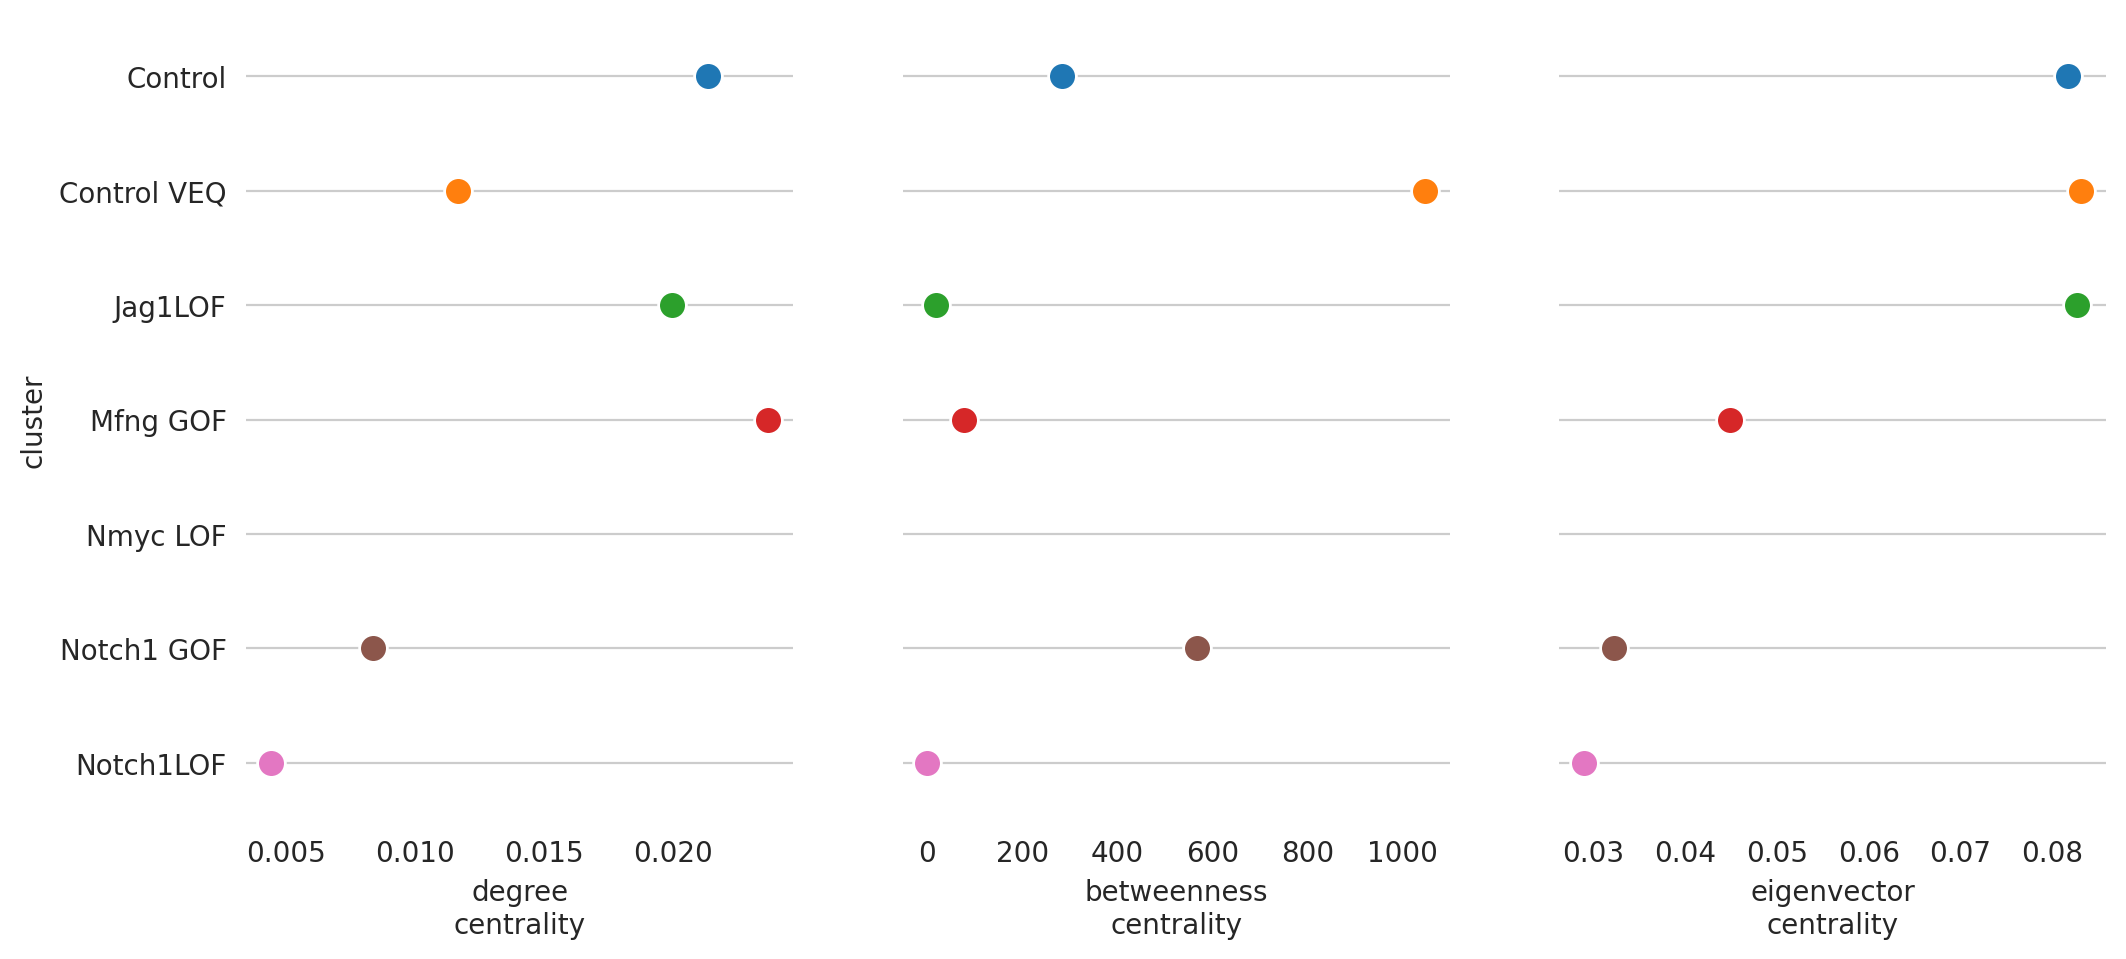

In [64]:
plt.rcParams["figure.figsize"] = [12, 5.2]

links.plot_score_per_cluster(goi="Mycn", 
                            #  save=f"{save_folder}/network_score_per_gene/"
                             )

# 8. Network analysis; network score distribution

Next, we visualize the network score distributions to get insight into the global network trends.

## 8.1. Distribution of network degree

In [68]:
plt.rcParams["figure.figsize"] = [6, 5]

degree_centrality_all


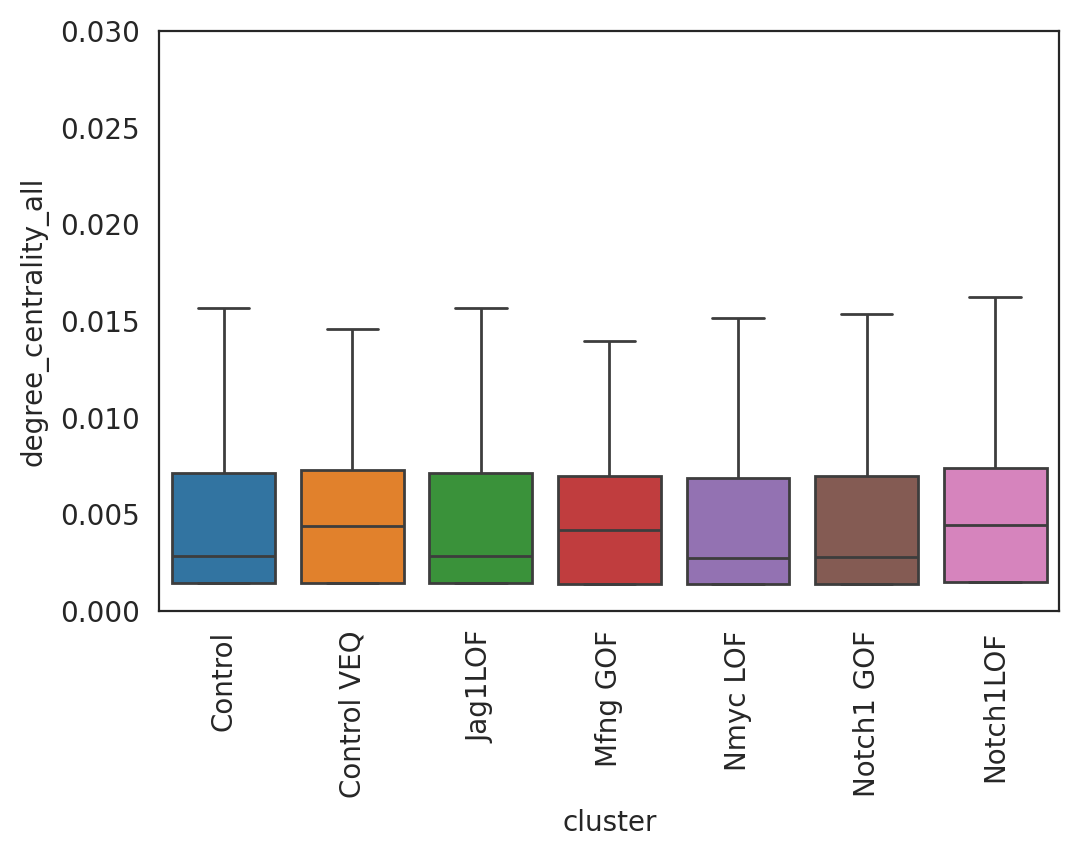

In [69]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.03])
links.plot_score_discributions(values=["degree_centrality_all"], 
                               method="boxplot", 
                            #    save=f"{save_folder}",
                              )



eigenvector_centrality


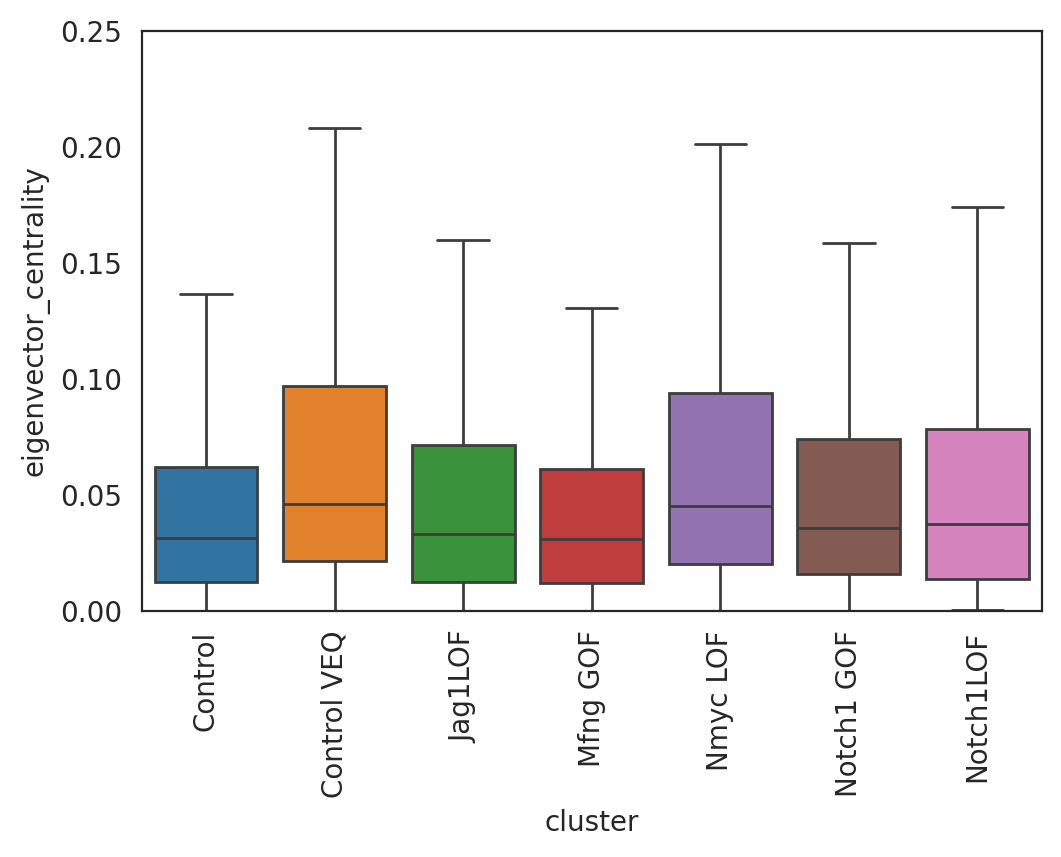

In [71]:
# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.25])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                            #    save=f"{save_folder}"
                               )




## 8.2. Distribution of network entropy

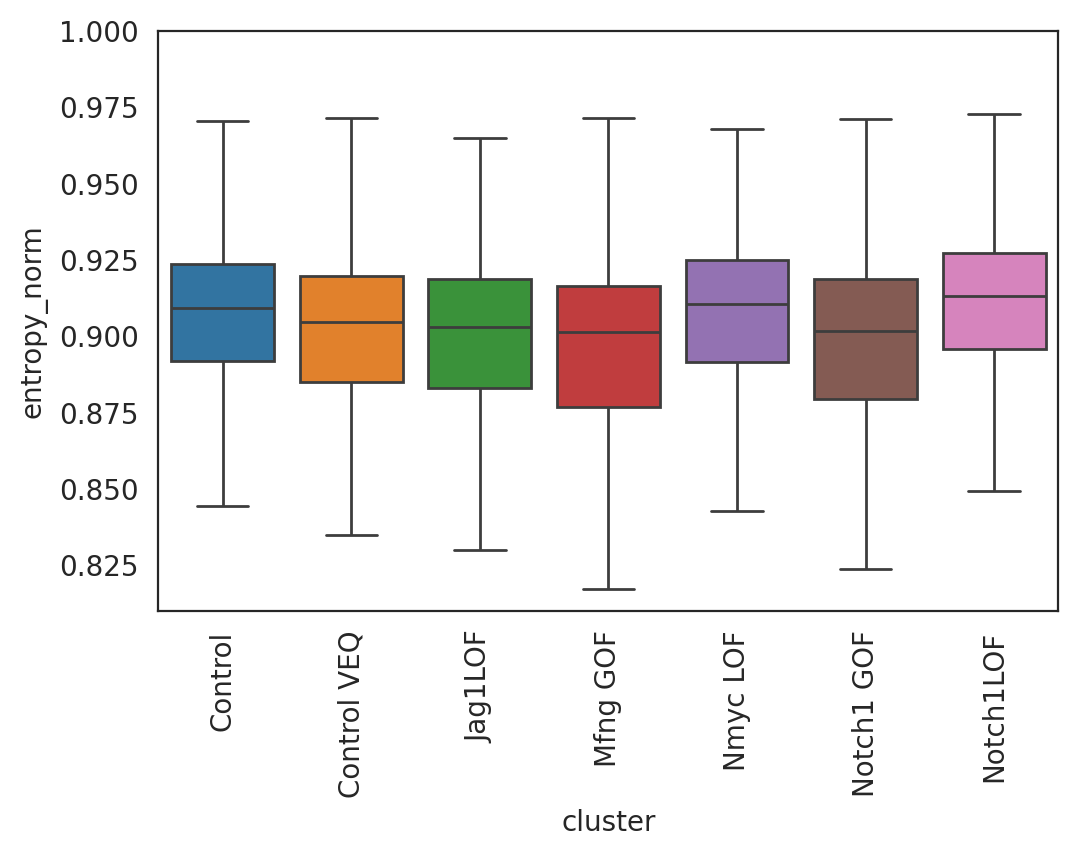

In [70]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(
    # save=f"{save_folder}"
    )



The global distribution among conditions is very similar

In [118]:
import session_info

session_info.show()